# Analysis Structure

1. exp sbs freqs versus chemical distance
2. fit quality 
    - on codon positions
    - on genes
    - on terminal and internal
    - on random spectra
    - on site rate cats

In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from Bio import SeqIO

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons
# from pymutspec.io import read_genbank_ref

from scipy.spatial.distance import euclidean, cityblock, pdist, squareform
from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
import pingouin as pg
from sklearn.metrics import mean_squared_error, r2_score
import tqdm

from utils import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities, plot_exp_heatmap,
    prepare_aa_subst, plot_aa_eq_freqs, prepare_exp_aa_subst,
    calc_metrics,weighted_average_percentage_error, get_equilibrium_freqs,
    plot_subst_freqs, categorize_site_rates_robust_plus_invariant,
    grantham_long
)

In [2]:
coda = CodonAnnotation(1)

## Load data

- amino acid content
- clades spectra
- observed substitutions

In [3]:
aa_freqs_total_dct = pd.read_json('./data/ref_aa_freqs_mean.json', orient='index')[0].to_dict()
aa_freqs_total_dct

{'Arg': 350,
 'Val': 782,
 'Cys': 296,
 'Gly': 577,
 'Ser': 661,
 'Ala': 659,
 'Leu': 930,
 'Thr': 718,
 'Pro': 394,
 'Asp': 511,
 'Tyr': 448,
 'Phe': 501,
 'Ile': 513,
 'Asn': 532,
 'Lys': 562,
 'Gln': 365,
 'Glu': 442,
 'His': 189,
 'Met': 207,
 'Trp': 111}

In [4]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_24A = clades_spectra[clades_spectra['clade'] == '24A'].copy()
spectrum_24A['rate'] /= spectrum_24A['rate'].sum()
spectrum_20A

subset clade mut_type  count  total_count  fraction parent_nt  \
0     all   20A     AtoC    305        18970  0.016078         A   
1     all   20A     AtoG   1778        18970  0.093727         A   
2     all   20A     AtoT    588        18970  0.030996         A   
3     all   20A     CtoA    384        18970  0.020242         C   
4     all   20A     CtoG    135        18970  0.007117         C   
5     all   20A     CtoT   7840        18970  0.413280         C   
6     all   20A     GtoA    878        18970  0.046284         G   
7     all   20A     GtoC    140        18970  0.007380         G   
8     all   20A     GtoT   2906        18970  0.153190         G   
9     all   20A     TtoA    639        18970  0.033685         T   
10    all   20A     TtoC   2912        18970  0.153510         T   
11    all   20A     TtoG    465        18970  0.024512         T   

    parent_nt_frac      rate  Mut  
0         0.289560  0.007540  A>C  
1         0.289560  0.043953  A>G  
2         0.289560  0.014536  A>T  
3         0.135130  0.020341  C>A  
4         0.135130  0.007151  C>G  
5         0.135130  0.415293  C>T  
6         0.064585  0.097310  G>A  
7         0.064585  0.015516  G>C  
8         0.064585  0.322075  G>T  
9         0.510720  0.008956  T>A  
10        0.510720  0.040812  T>C  
11        0.510720  0.006517  T>G

In [5]:
_clades_order = clades_spectra.drop_duplicates(subset='clade').set_index('clade')

_1 = {x:'Early clades' for x in _clades_order.loc[:'21J'].index.unique()}
_2 = {x:'Late clades\n(Omicron+)' for x in _clades_order.loc['21K':].index.unique()}

_clade2label = {**_1, **_2}
_clade2label

{'20A': 'Early clades',
 '20B': 'Early clades',
 '20C': 'Early clades',
 '20E': 'Early clades',
 '20G': 'Early clades',
 '20I': 'Early clades',
 '20J': 'Early clades',
 '21C': 'Early clades',
 '21I': 'Early clades',
 '21J': 'Early clades',
 '21K': 'Late clades\n(Omicron+)',
 '21L': 'Late clades\n(Omicron+)',
 '22A': 'Late clades\n(Omicron+)',
 '22B': 'Late clades\n(Omicron+)',
 '22C': 'Late clades\n(Omicron+)',
 '22D': 'Late clades\n(Omicron+)',
 '22E': 'Late clades\n(Omicron+)',
 '22F': 'Late clades\n(Omicron+)',
 '23A': 'Late clades\n(Omicron+)',
 '23B': 'Late clades\n(Omicron+)',
 '23C': 'Late clades\n(Omicron+)',
 '23D': 'Late clades\n(Omicron+)',
 '23F': 'Late clades\n(Omicron+)',
 '24A': 'Late clades\n(Omicron+)'}

In [6]:
obs_raw = pd.read_csv('data/bloom_etal/aggregated.csv').query('subset == "all" & exclude == False')
obs_raw['Mut'] = obs_raw['nt_mutation'].str[0] + '>' + obs_raw['nt_mutation'].str[-1]
obs = obs_raw.query('synonymous == False & noncoding == False').drop(['synonymous', 'noncoding', 'four_fold_degenerate'], axis=1)

def _same_aa_mut(aa_mutation: str):
    variants = aa_mutation.split(';')
    return variants.count(variants[0]) == len(variants)

obs = obs[obs.aa_mutation.apply(_same_aa_mut)]
obs['aa1'] = obs['aa_mutation'].str[0]
obs['aa2'] = obs['aa_mutation'].str[-1]
# same as in the paper table
# obs[obs.four_fold_degenerate].groupby('clade')['count'].sum().sort_index()
obs

protein    aa_mutation nt_mutation     codon_change  nt_site  \
0              ORF1ab         P5401L     C16466T          CCA>CTA    16466   
1                   M           I82T     T26767C          ATC>ACC    26767   
3              ORF1ab         P4715L     C14408T          CCT>CTT    14408   
4              ORF1ab         A6319V     C19220T          GCT>GTT    19220   
5              ORF1ab         I5658V     A17236G          ATA>GTA    17236   
...               ...            ...         ...              ...      ...   
1553870  ORF1a;ORF1ab  V4369A;V4369A     T13371C  GTC>GCC;GTC>GCC    13371   
1553871  ORF1a;ORF1ab  V4350A;V4350A     T13314C  GTA>GCA;GTA>GCA    13314   
1553874  ORF1a;ORF1ab  V3763F;V3763F     G11552T  GTT>TTT;GTT>TTT    11552   
1553875  ORF1a;ORF1ab  V3759G;V3759G     T11541G  GTT>GGT;GTT>GGT    11541   
1553876  ORF1a;ORF1ab  V4102A;V4102A     T12570C  GTA>GCA;GTA>GCA    12570   

        reference_nt clade_founder_nt  exclude  count  count_terminal  \
0                  C                C    False     70              37   
1                  T                T    False     58              18   
3                  C                C    False     52              26   
4                  C                C    False     50              15   
5                  A                A    False     48              24   
...              ...              ...      ...    ...             ...   
1553870            T                T    False      1               1   
1553871            T                T    False      1               1   
1553874            G                G    False      1               1   
1553875            T                T    False      1               0   
1553876            T                T    False      1               0   

         count_non_terminal  mean_log_size clade subset    codon  \
0                        33       0.708825   19A    all      CCA   
1                        40       1.237886   19A    all      ATC   
3                        26       0.678436   19A    all      CCT   
4                        35       1.097059   19A    all      GCT   
5                        24       0.581333   19A    all      ATA   
...                     ...            ...   ...    ...      ...   
1553870                   0       0.000000   24E    all  GTC;GTC   
1553871                   0       0.000000   24E    all  GTA;GTA   
1553874                   0       0.000000   24E    all  GTT;GTT   
1553875                   1       0.693147   24E    all  GTT;GTT   
1553876                   1       1.098612   24E    all  GTA;GTA   

        codon_position codon_site  Mut aa1 aa2  
0                    2       5401  C>T   P   L  
1                    2         82  T>C   I   T  
3                    2       4715  C>T   P   L  
4                    2       6319  C>T   A   V  
5                    1       5658  A>G   I   V  
...                ...        ...  ...  ..  ..  
1553870            2;2  4369;4369  T>C   V   A  
1553871            2;2  4350;4350  T>C   V   A  
1553874            1;1  3763;3763  G>T   V   F  
1553875            2;2  3759;3759  T>G   V   G  
1553876            2;2  4102;4102  T>C   V   A  

[440648 rows x 20 columns]

## stuff

### Plots

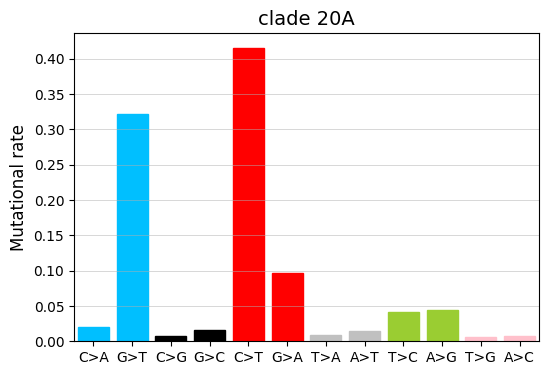

In [11]:
ax = plot_mutspec12(spectrum_20A, 'rate', 'clade 20A', 
               ylabel='Mutational rate', ticksize=10,
            #    savepath='./figures/20A_spectrum.png'
)

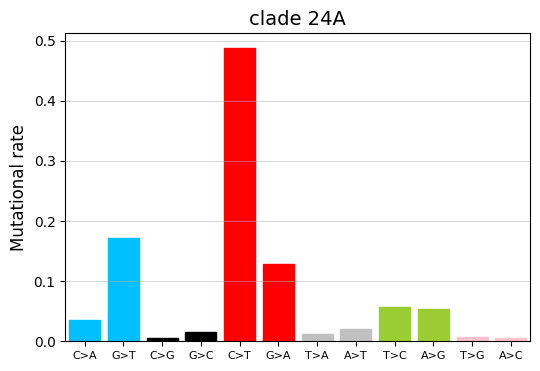

In [12]:
ax = plot_mutspec12(spectrum_24A, 'rate', 'clade 24A', 
               ylabel='Mutational rate', 
            #    savepath='./figures/20A_spectrum.png'
)

### qualitative model

In [105]:
aa_flows = df_changes\
    .query('(sbs == "C>T" | sbs == "G>T") & aa1 != "*" & aa2 != "*" & aa1 != aa2')\
    .groupby(['aa1', 'aa2']).rate.count().reset_index()

inflow = aa_flows.groupby('aa2').rate.sum().rename('inflow')
outflow = aa_flows.groupby('aa1').rate.sum().rename('outflow')
inflow.index.name='aa'
outflow.index.name='aa'
_flow = inflow.to_frame().join(outflow, how='outer').fillna(0).astype(int)
_flow['flow'] = _flow['inflow'] - _flow['outflow']
_flow.sort_values('flow')[['flow']].T

aa    Arg  Ala  Pro  Gly  Thr  Glu  His  Gln  Lys  Asp  Trp  Asn  Met  Cys  \
flow  -10   -8   -8   -7   -4   -1   -1   -1   -1   -1    0    1    1    3   

aa    Ser  Tyr  Val  Ile  Phe  Leu  
flow    3    4    4    7    9   10

In [106]:
aa_flows.query('aa1 == "Ser" | aa2 == "Ser"')

aa1  aa2  rate
0   Ala  Ser     4
6   Arg  Ser     1
20  Pro  Ser     4
21  Ser  Ile     2
22  Ser  Leu     2
23  Ser  Phe     2

In [107]:
_flow.sort_values('flow')

inflow  outflow  flow
aa                        
Arg       0       10   -10
Ala       0        8    -8
Pro       0        8    -8
Gly       0        7    -7
Thr       0        4    -4
Glu       0        1    -1
His       1        2    -1
Gln       0        1    -1
Lys       0        1    -1
Asp       1        2    -1
Trp       2        2     0
Asn       1        0     1
Met       2        1     1
Cys       5        2     3
Ser       9        6     3
Tyr       4        0     4
Val       8        4     4
Ile       7        0     7
Phe       9        0     9
Leu      13        3    10

In [ ]:
eq_freqs_aa = eq_freqs_cdn[eq_freqs_cdn.aa !='*'].groupby('aa')['freq'].sum()
eq_freqs_aa /= eq_freqs_aa.sum()
eq_freqs_aa = eq_freqs_aa.sort_values(ascending=False).reset_index()
eq_freqs_aa.T

0         1         2         3         4         5         6   \
aa         Phe       Leu       Ser       Ile       Tyr       Val       Cys   
freq  0.314637  0.197825  0.119281  0.086898  0.073639  0.044165  0.035283   

            7         8         9         10        11        12        13  \
aa         Thr       His       Pro       Asn       Arg       Asp       Ala   
freq  0.025257  0.020183  0.017862  0.017199  0.009142  0.008012  0.007127   

            14        15        16        17        18        19  
aa         Met       Gln       Lys       Gly       Glu       Trp  
freq  0.006878  0.005073  0.004677  0.002844  0.002015  0.002004

## Explore OBS

### Basic features

In [6]:
obs_raw['count'].sum()

np.int64(5635999)

In [51]:
obs.codon_position.value_counts()

codon_position
1      110949
2      100113
1;1     89804
2;2     87542
3       29004
3;3     23236
Name: count, dtype: int64

In [52]:
obs_raw['count'].sum(), obs['count'].sum()

(np.int64(5635999), np.int64(3175359))

In [53]:
print('Number of mutations:')
obs_raw.groupby(['clade', 'synonymous'])['count'].sum().unstack()

Number of mutations:


synonymous    False   True 
clade                      
19A            7462    3999
20A           67405   43933
20B           56079   36627
20C           56285   37562
20E           38269   24958
20F            2218    1300
20G           52212   36639
20I          217281  146099
20J           17075   12236
21C           23617   16296
21I           86071   55531
21J         1032287  643592
21K          393196  295375
21L          315056  250437
22A           43079   35461
22B          348753  270719
22C           61092   47564
22D           21735   16967
22E           96306   78990
22F           20684   16505
23A           96095   75345
23B           31774   25859
23C           16612   13041
23D           32087   25902
23E           12181    9604
23F           45178   37377
24A           67943   58881
24B            9791    8564
24C            9769    8829
24E           12967   11248

In [54]:
obs_raw.groupby(['clade', 'synonymous'])['count'].sum().unstack().shape

(30, 2)

In [55]:
print('Number of mutations:')
obs_raw.query('synonymous == True').groupby(['clade', 'four_fold_degenerate'])['count'].sum().unstack()

Number of mutations:


four_fold_degenerate   False   True 
clade                               
19A                     2299    1700
20A                    24963   18970
20B                    20543   16084
20C                    21405   16157
20E                    14092   10866
20F                      758     542
20G                    21294   15345
20I                    84469   61630
20J                     6871    5365
21C                     9495    6801
21I                    30942   24589
21J                   356462  287130
21K                   171324  124051
21L                   146835  103602
22A                    20676   14785
22B                   158444  112275
22C                    28027   19537
22D                     9550    7417
22E                    46045   32945
22F                     9294    7211
23A                    43016   32329
23B                    14765   11094
23C                     7578    5463
23D                    14918   10984
23E                     5530    4074
23F                    21588   15789
24A                    34504   24377
24B                     5131    3433
24C                     5143    3686
24E                     6636    4612

In [56]:
obs.groupby('clade')['count'].sum().rename('aa_subst_cnt').sort_index().reset_index()

clade  aa_subst_cnt
0    19A          7185
1    20A         65078
2    20B         54164
3    20C         54346
4    20E         36904
5    20F          2161
6    20G         50463
7    20I        210313
8    20J         16464
9    21C         22742
10   21I         82872
11   21J        998289
12   21K        379267
13   21L        303609
14   22A         41499
15   22B        335444
16   22C         58845
17   22D         20777
18   22E         93354
19   22F         19810
20   23A         92364
21   23B         30556
22   23C         15938
23   23D         30973
24   23E         11722
25   23F         43582
26   24A         65370
27   24B          9422
28   24C          9371
29   24E         12475

### terminal vs non-terminal spectrum and mutations

1.2971005556962407


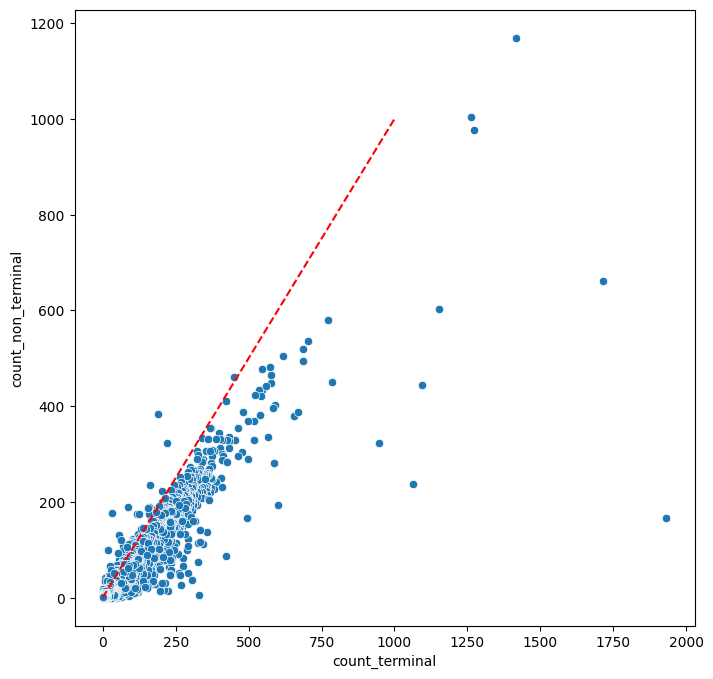

In [14]:
plt.figure(figsize=(8, 8))
sns.scatterplot(obs, x='count_terminal', y='count_non_terminal')
plt.plot([0, 1000],[0, 1000], 'r--')
print((obs.count_terminal / obs.count_non_terminal).replace(np.inf, np.nan).mean())

In [ ]:
# Compare spectra terminal vs non-terminal

_ = obs_raw.query('four_fold_degenerate == True')\
    .groupby(['clade', 'Mut'])[['count_terminal', 'count_non_terminal']].sum()\
        .melt(ignore_index=False, value_name='ObsNum', var_name='tree_set').reset_index()\
            .pivot(index=['clade','tree_set'], columns='Mut', values='ObsNum')

print('ter and non-ter spectra for clades:\n\nclade, cossim, ter_mut_frac, PE_mean(%)')
for cl in _.index.get_level_values(0).unique():
    curd = _.loc[cl]
    _nmuts = curd.sum(axis=1).values
    if _nmuts.sum() < 5000:
        continue
    ter_frac = _nmuts[1] / _nmuts.sum()
    cossim = 1-pdist(curd, 'cosine')[0]

    curs = curd.T / curd.sum(1)
    curs['pe'] = (curs['count_terminal'] - curs['count_non_terminal']) \
        / curs['count_terminal'] * 100
    
    print(f'{cl}    {cossim:.4f}  {ter_frac:.3f}         {curs['pe'].abs().mean():.2f}')


ter and non-ter spectra for clades:

clade, cossim, ter_mut_frac, PE_mean(%)
20A    0.9989  0.555         10.59
20B    0.9968  0.565         12.57
20C    0.9958  0.576         16.14
20E    0.9973  0.567         14.56
20G    0.9995  0.565         11.98
20I    0.9992  0.558         9.48
20J    0.9993  0.611         10.33
21C    0.9984  0.550         11.57
21I    0.9985  0.586         10.98
21J    0.9989  0.580         9.63
21K    0.9985  0.642         10.43
21L    0.9993  0.600         6.89
22A    0.9998  0.616         9.79
22B    0.9991  0.597         7.61
22C    0.9994  0.649         8.91
22D    0.9993  0.572         7.41
22E    0.9988  0.600         8.43
22F    0.9989  0.611         21.27
23A    0.9994  0.585         9.71
23B    0.9995  0.569         11.63
23C    0.9976  0.574         17.22
23D    0.9996  0.577         9.27
23F    0.9994  0.605         9.02
24A    0.9997  0.640         10.56


## compare obs and exp with chemical distance

In [13]:
grantham_long

aa1  aa2  grantham_distance
0    Ser  Arg              110.0
1    Ser  Leu              145.0
2    Arg  Leu              102.0
3    Ser  Pro               74.0
4    Arg  Pro              103.0
..   ...  ...                ...
375  Trp  Asn              174.0
376  Trp  Lys              110.0
377  Trp  Asp              181.0
378  Trp  Glu              152.0
379  Trp  Met               67.0

[380 rows x 3 columns]

In [14]:
obs_clade = obs[obs['clade'] == '20A']
exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_20A)
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
aa_subst['label'] = aa_subst.aa1 + '>' + aa_subst.aa2
aa_subst['pe'] = aa_subst['pe'].replace(-np.inf, 0)
aa_subst['diff_freqs_abs'] = (aa_subst['nobs_freqs'] - aa_subst['nexp_freqs']).abs()
aa_subst['division'] = (aa_subst['nobs_freqs'] / aa_subst['nexp_freqs'])
aa_subst['dist_to_diagonal'] = aa_subst['diff_freqs_abs'] / (2**0.5)
aa_subst = aa_subst.merge(grantham_long, 'left')
aa_subst.sort_values('pe')

aa1  aa2    nobs  ref_aa1_freq  nobs_scaled  rate_exp         nexp  \
57   Gly  Trp    11.0      0.059192     9.389043  0.322075   675.334620   
18   Arg  Trp    47.0      0.035905    66.135441  0.429829   901.276603   
15   Arg  Pro     9.0      0.035905    12.664233  0.062066   130.141215   
12   Arg  Leu   234.0      0.035905   329.270066  1.288299  2701.338481   
1    Ala  Glu    22.0      0.067604    16.441510  0.040682    85.303028   
..   ...  ...     ...           ...          ...       ...          ...   
96   Met  Thr   171.0      0.021235   406.846143  0.040812    85.576362   
85   Lys  Arg  1036.0      0.057653   907.878806  0.087906   184.324013   
103  Phe  Val   137.0      0.051395   134.675092  0.013034    27.330566   
45   Glu  Ala   178.0      0.045343   198.336284  0.015079    31.618496   
97   Met  Val   254.0      0.021235   604.321171  0.043953    92.162006   

            diff           pe  nobs_freqs  nexp_freqs  obs_relative_freq  \
57   -665.945578 -7092.795348    0.000146    0.010482           0.013903   
18   -835.141162 -1262.774019    0.001026    0.013988           0.073380   
15   -117.476982  -927.628060    0.000197    0.002020           0.097311   
12  -2372.068414  -720.402082    0.005110    0.041926           0.121891   
1     -68.861518  -418.827209    0.000255    0.001324           0.192742   
..           ...          ...         ...         ...                ...   
96    321.269781    78.965915    0.006314    0.001328           4.754188   
85    723.554793    79.697289    0.014091    0.002861           4.925451   
103   107.344525    79.706295    0.002090    0.000424           4.927636   
45    166.717788    84.058139    0.003078    0.000491           6.272793   
97    512.159165    84.749499    0.009379    0.001430           6.557162   

     grantham_distance    label  diff_freqs_abs  division  dist_to_diagonal  
57               184.0  Gly>Trp        0.010336  0.013903          0.007309  
18               101.0  Arg>Trp        0.012962  0.073380          0.009165  
15               103.0  Arg>Pro        0.001823  0.097311          0.001289  
12               102.0  Arg>Leu        0.036816  0.121891          0.026033  
1                107.0  Ala>Glu        0.001069  0.192742          0.000756  
..                 ...      ...             ...       ...               ...  
96                81.0  Met>Thr        0.004986  4.754188          0.003526  
85                26.0  Lys>Arg        0.011230  4.925451          0.007941  
103               50.0  Phe>Val        0.001666  4.927636          0.001178  
45               107.0  Glu>Ala        0.002588  6.272793          0.001830  
97                21.0  Met>Val        0.007949  6.557162          0.005621  

[150 rows x 17 columns]

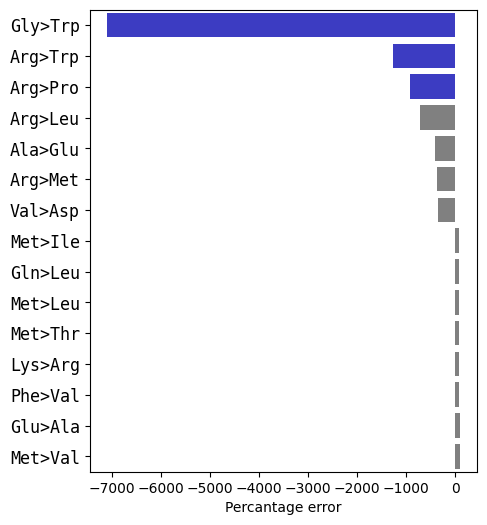

In [54]:
a = aa_subst['pe'][aa_subst['pe']>0].quantile(0.9)
b = aa_subst['pe'][aa_subst['pe']<0].quantile(0.1)

_d = aa_subst[(aa_subst['pe'] > a) | (aa_subst['pe'] < b)].copy()

plt.figure(figsize=(5, 6))
sns.barplot(aa_subst, y='label', x='pe', color='gray',
            order=_d.sort_values('pe').label)

# sns.barplot(aa_subst, y='label', x='pe', color='red', alpha=0.7,
#             order=_d.sort_values('pe').tail(3).label)
sns.barplot(aa_subst, y='label', x='pe', color='blue', alpha=0.7,
            order=_d.sort_values('pe').head(3).label)

plt.ylabel('')
# plt.xlim(-0.45, 0.45)
plt.xlabel('Percantage error')
plt.yticks(fontsize=12, fontname='monospace')
plt.show()

<Axes: >

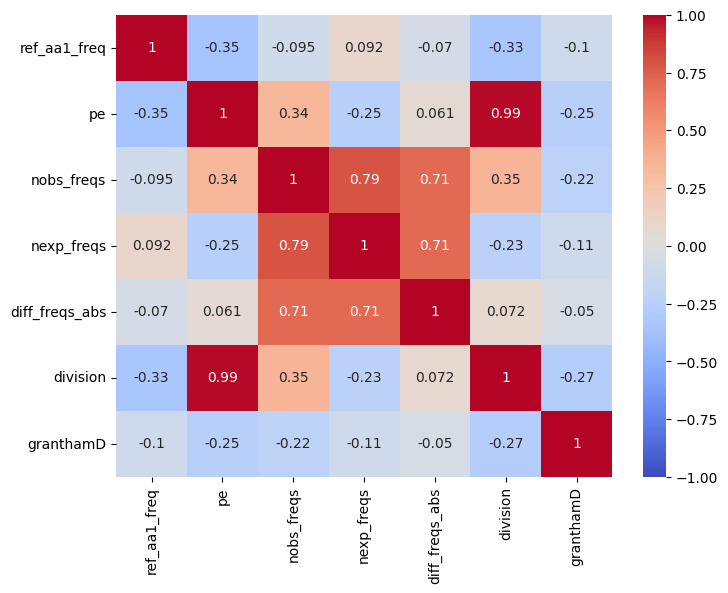

In [55]:
plt.figure(figsize=(8, 6))
sns.heatmap(aa_subst.drop(['aa1', 'aa2', 'label', 'nobs', 'nexp', 
                           'nobs_scaled', 'dist_to_diagonal', 'diff', 'rate_exp'], 
            axis=1).corr('spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)

Spearman correlation: -0.05, p-value: 0.5435


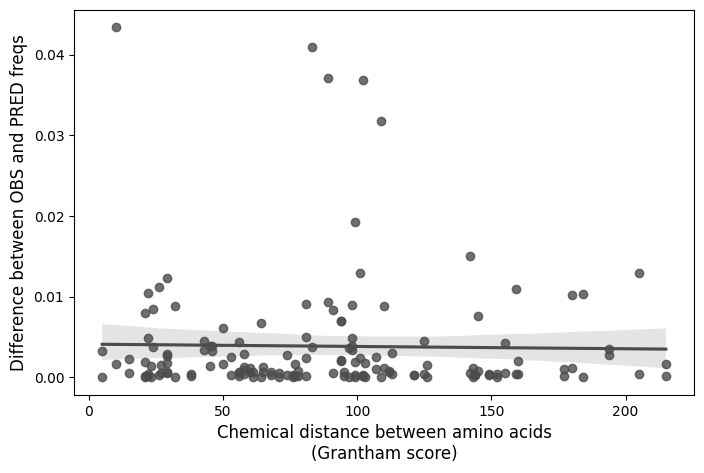

In [32]:
plt.figure(figsize=(8, 5))
sns.regplot(aa_subst, x='granthamD', y='diff_freqs_abs', color='.3')
plt.xlabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
plt.ylabel('Difference between OBS and PRED freqs', fontsize=12)
cor = spearmanr(aa_subst['granthamD'], aa_subst['diff_freqs_abs'])
print(f'Spearman correlation: {cor.correlation:.2f}, p-value: {cor.pvalue:.4f}')

Text(42.33322222222222, 0.5, 'Difference between OBS and PRED freqs')

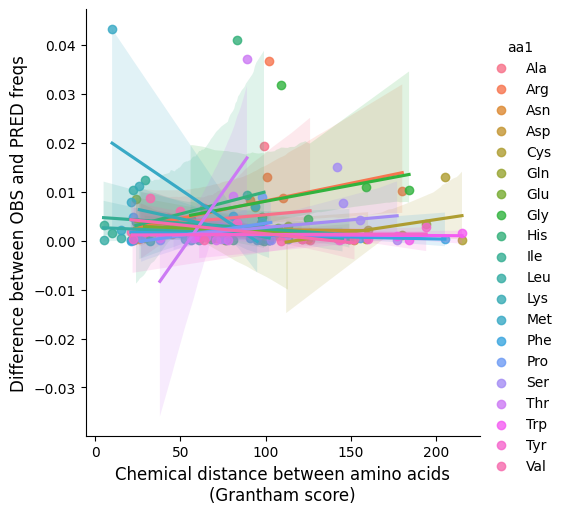

In [35]:
sns.lmplot(aa_subst, x='granthamD', y='diff_freqs_abs', hue='aa1')
plt.xlabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
plt.ylabel('Difference between OBS and PRED freqs', fontsize=12)

Pearson correlation: -0.10, p-value: 0.2448


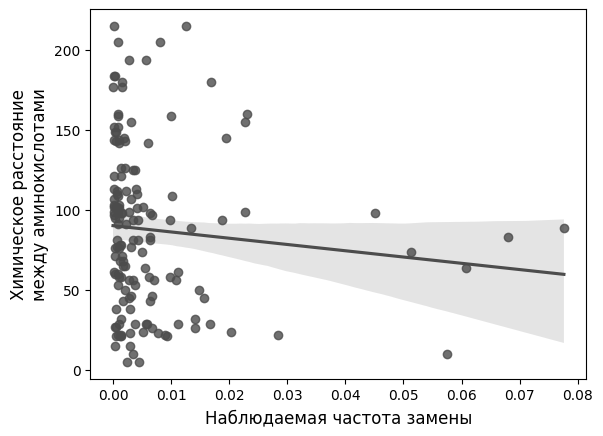

In [21]:
# fig 3a in https://link.springer.com/article/10.1186/gb-2003-4-11-r72
sns.regplot(aa_subst, y='grantham_distance', x='nobs_freqs', color='.3')
plt.xlabel('Наблюдаемая частота замены', fontsize=12)
plt.ylabel('Химическое расстояние\nмежду аминокислотами', fontsize=12)
cor = pearsonr(aa_subst.grantham_distance, aa_subst.nobs_freqs)
print(f'Pearson correlation: {cor.correlation:.2f}, p-value: {cor.pvalue:.4f}')

Text(0, 0.5, 'Химическое расстояние\nмежду аминокислотами')

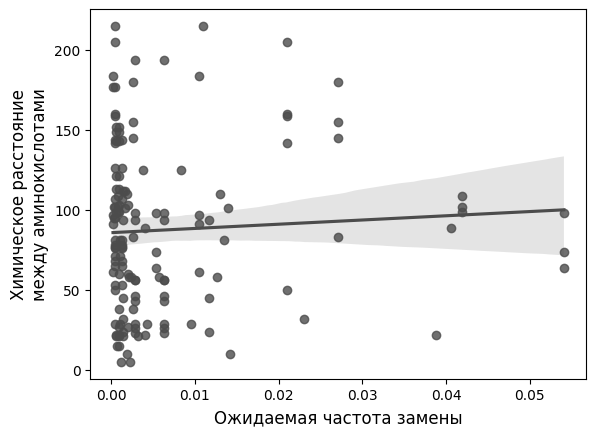

In [20]:
sns.regplot(aa_subst, y='grantham_distance', x='nexp_freqs', color='.3')
plt.xlabel('Ожидаемая частота замены', fontsize=12)
plt.ylabel('Химическое расстояние\nмежду аминокислотами', fontsize=12)

Pearson correlation: -0.23, p-value: 0.0048


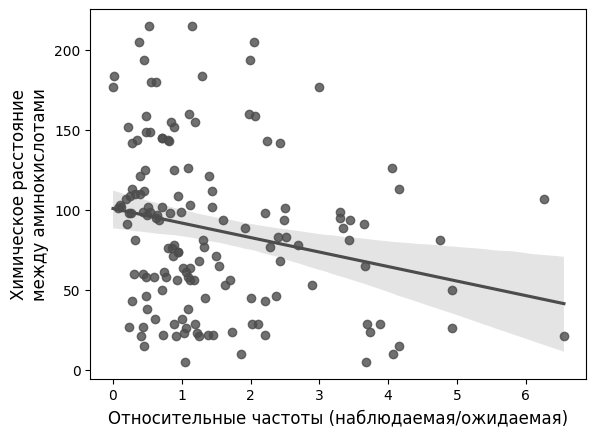

In [23]:
# fig 3b in https://link.springer.com/article/10.1186/gb-2003-4-11-r72
sns.regplot(aa_subst, y='grantham_distance', x='division', color='.3')
plt.xlabel('Относительные частоты (наблюдаемая/ожидаемая)', fontsize=12)
plt.ylabel('Химическое расстояние\nмежду аминокислотами', fontsize=12)
cor = pearsonr(aa_subst.grantham_distance, aa_subst.division)
print(f'Pearson correlation: {cor.correlation:.2f}, p-value: {cor.pvalue:.4f}')

In [46]:
_d = []
for clade, cur_obs in obs.groupby('clade'):
    exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_20A)
    aa_subst = prepare_aa_subst(cur_obs, exp_aa_subst, aa_freqs_total_dct)
    _d.append(aa_subst.assign(clade=clade))

aa_subst_clades = pd.concat(_d, ignore_index=True)
aa_subst_clades['obs_relative_freq'] = (aa_subst_clades['nobs_freqs'] / aa_subst_clades['nexp_freqs'])
aa_subst_clades = aa_subst_clades.merge(grantham_long, 'left')
aa_subst_clades

aa1  aa2   nobs  ref_aa1_freq  nobs_scaled  rate_exp        nexp  \
0     Ala  Asp   22.0      0.067604    16.637818  0.040682    9.434424   
1     Ala  Glu    2.0      0.067604     1.512529  0.040682    9.434424   
2     Ala  Gly    6.0      0.067604     4.537587  0.028605    6.633698   
3     Ala  Pro    8.0      0.067604     6.050116  0.062066   14.393480   
4     Ala  Ser  223.0      0.067604   168.646976  1.288299  298.765160   
...   ...  ...    ...           ...          ...       ...         ...   
4495  Val  Gly   12.0      0.080222     7.583982  0.026069   10.523992   
4496  Val  Ile  270.0      0.080222   170.639596  0.291929  117.853036   
4497  Val  Leu  175.0      0.080222   110.599738  0.706215  285.102725   
4498  Val  Met   37.0      0.080222    23.383945  0.097310   39.284345   
4499  Val  Phe  179.0      0.080222   113.127732  0.644149  260.046436   

            diff          pe  nobs_freqs  nexp_freqs clade  obs_relative_freq  \
0       7.203394   43.295305    0.002335    0.001324   19A           1.763522   
1      -7.921895 -523.751645    0.000212    0.001324   19A           0.160320   
2      -2.096111  -46.194394    0.000637    0.000931   19A           0.684021   
3      -8.343364 -137.904207    0.000849    0.002020   19A           0.420337   
4    -130.118184  -77.154176    0.023666    0.041926   19A           0.564480   
...          ...         ...         ...         ...   ...                ...   
4495   -2.940010  -38.766050    0.000611    0.000848   24E           0.720637   
4496   52.786560   30.934532    0.013756    0.009500   24E           1.447902   
4497 -174.502987 -157.778843    0.008916    0.022983   24E           0.387929   
4498  -15.900401  -67.997085    0.001885    0.003167   24E           0.595248   
4499 -146.918704 -129.869751    0.009120    0.020963   24E           0.435029   

      granthamD  
0         126.0  
1         107.0  
2          60.0  
3          27.0  
4          99.0  
...         ...  
4495      109.0  
4496       29.0  
4497       32.0  
4498       21.0  
4499       50.0  

[4500 rows x 14 columns]

(array([-0.13659364, -0.22912635, -0.2056347 , -0.2528111 , -0.19914536,
        -0.2403925 , -0.20326384, -0.22972373, -0.17314572, -0.22350838,
        -0.22326794, -0.22281316, -0.23437844, -0.23485349, -0.2761941 ,
        -0.27413038, -0.26039465, -0.24746344, -0.23536699, -0.1711427 ,
        -0.2364725 , -0.22020619, -0.27039941, -0.23197242, -0.23335387,
        -0.2599795 , -0.25382224, -0.286401  , -0.30222905, -0.18982026]),
 np.float64(-0.23193356814293875))

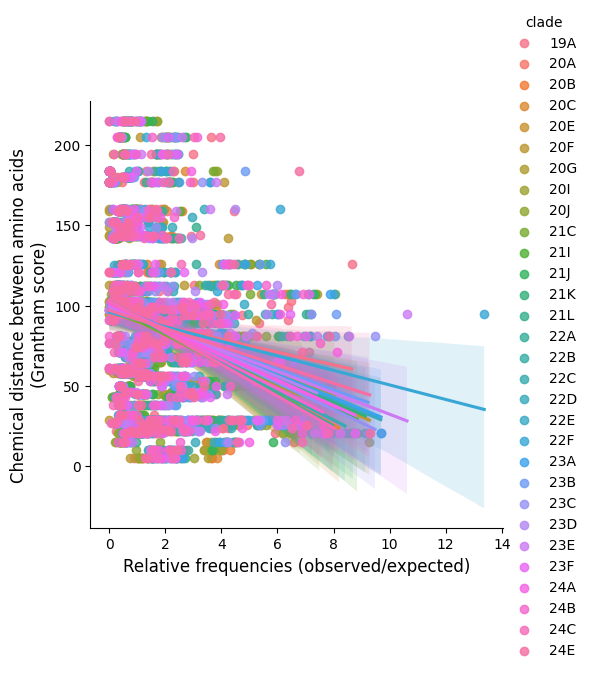

In [51]:
# fig 3b in https://link.springer.com/article/10.1186/gb-2003-4-11-r72
sns.lmplot(data=aa_subst_clades, y='granthamD', x='obs_relative_freq', hue='clade')
plt.xlabel('Relative frequencies (observed/expected)', fontsize=12)
plt.ylabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
cor = np.array([pearsonr(gr.granthamD, gr.obs_relative_freq).correlation \
            for _, gr in aa_subst_clades.groupby('clade')])
cor, cor.mean()

Text(0.5, 0, 'Observed frequency of amino acid substitution')

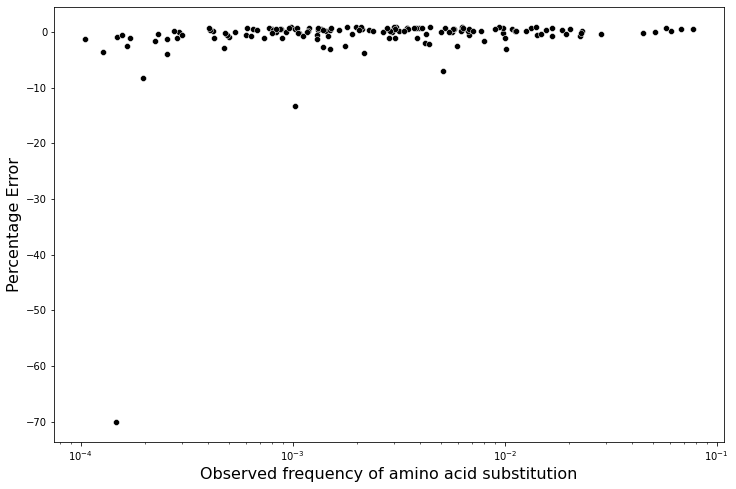

In [ ]:
# independence of frequency (useless in general)

plt.figure(figsize=(12, 8))
sns.scatterplot(aa_subst, x='nobs_freqs', y='mape', c='k')
plt.xscale('log')
# plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
plt.ylabel('Percentage Error', fontsize=16)
plt.xlabel('Observed frequency of amino acid substitution', fontsize=16)

## Fitting quality on mutations subsets

/home/kpotoh/.pyenv/venv_bio/lib64/python3.14/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.5539597345304178
Pearson correlation: 0.759 (p-value: 2.09e-29)


/home/kpotoh/mitofungen/sars-cov-2/1sars-cov-2/utils.py:620: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)


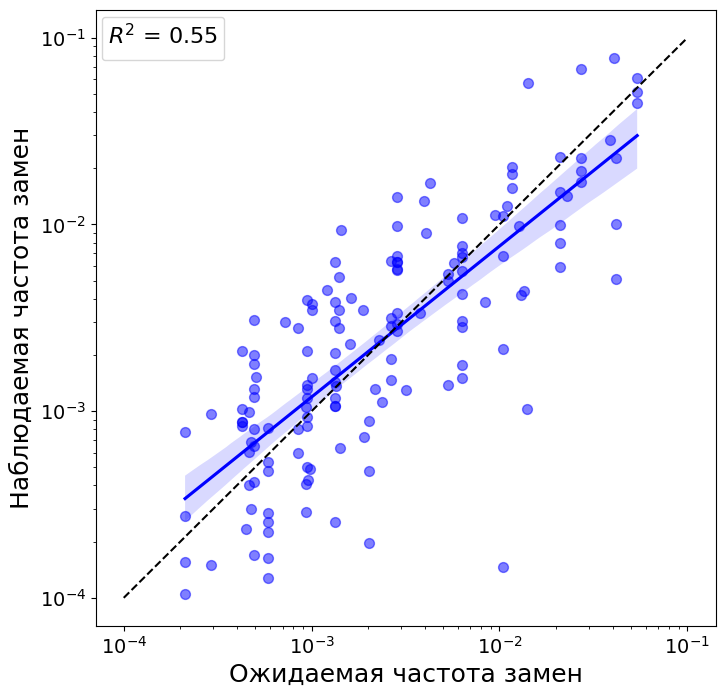

In [17]:
obs_clade = obs[obs['clade'] == '20A']
exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_20A)
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
ax= plot_subst_freqs(aa_subst, '20A; full set of mutations', )
ax.set_ylabel('Наблюдаемая частота замен', fontsize=18)
ax.set_xlabel('Ожидаемая частота замен', fontsize=18)
ax.set_title('');
# calc_metrics(aa_subst)

### Clades

In [10]:
metrics_total = []
aa_subst_total = []
for clade in tqdm.tqdm(clades_spectra.clade.unique(), desc='Clades'):
    spectrum_clade = clades_spectra[clades_spectra['clade'] == clade]
    exp_aa_subst, exp_aa_subst_matrix = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    obs_clade = obs[obs['clade'] == clade].copy()

    # for total sites set
    aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
    cur_metrics1 = calc_metrics(aa_subst)
    cur_metrics1['clade'] = clade
    cur_metrics1['branches'] = 'all'

    # for total sites set only terminal branches
    obs_clade_terminal = obs_clade.rename(columns={'count': 'count_all', 'count_terminal': 'count'})
    aa_subst = prepare_aa_subst(obs_clade_terminal, exp_aa_subst, aa_freqs_total_dct)
    cur_metrics2 = calc_metrics(aa_subst)
    cur_metrics2['clade'] = clade
    cur_metrics2['branches'] = 'terminal'

    # for total sites set only non-terminal branches
    obs_clade_nonterminal = obs_clade.rename(columns={'count': 'count_all', 'count_non_terminal': 'count'})
    aa_subst = prepare_aa_subst(obs_clade_nonterminal, exp_aa_subst, aa_freqs_total_dct)
    cur_metrics3 = calc_metrics(aa_subst)
    cur_metrics3['clade'] = clade
    cur_metrics3['branches'] = 'non-terminal'

    metrics_total.extend([cur_metrics1, cur_metrics2, cur_metrics3])

metrics_total_df = pd.DataFrame(metrics_total).set_index(['clade', 'branches'])
metrics_total_df.to_csv('data/fit_metrics_branches.csv', float_format='%g')

# aa_subst_total_df = pd.concat(aa_subst_total, ignore_index=True)
# aa_subst_total_df.to_csv('data/aa_subst_total_rates.csv', float_format='%g')


Clades: 100%|██████████| 24/24 [00:03<00:00,  7.78it/s]


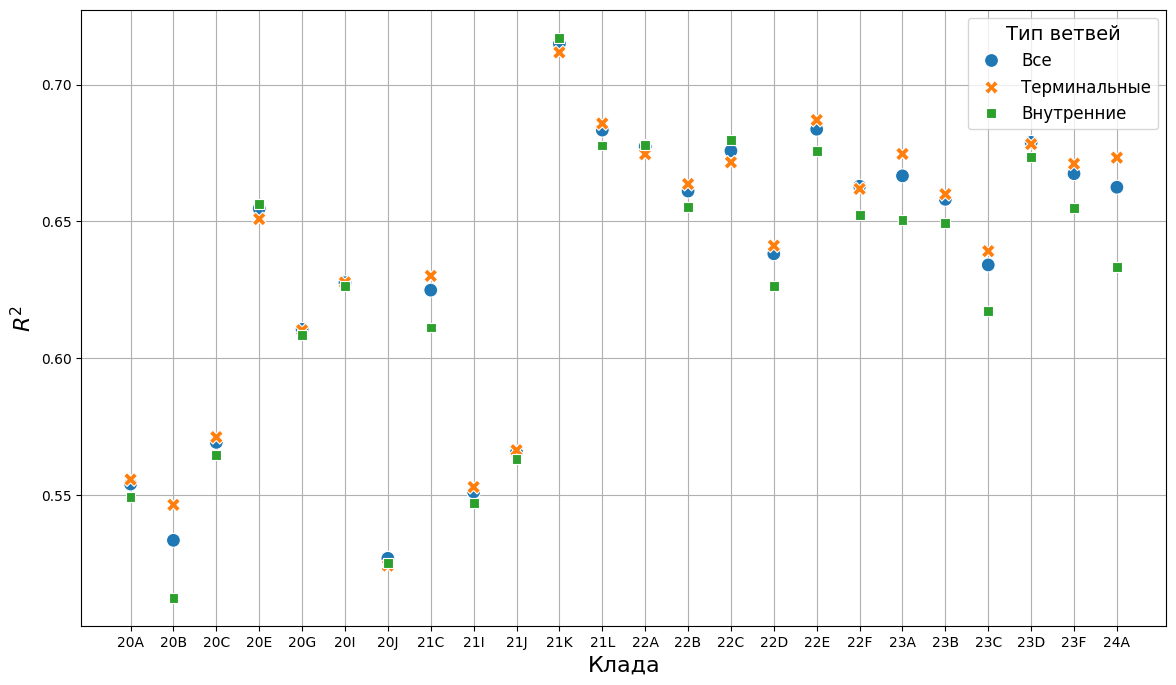

In [11]:
plt.figure(figsize=(14, 8))
_ = metrics_total_df.copy()
_['branches'] = _.index.get_level_values(1).map(
    {'all':'Все', 'terminal':'Терминальные', 'non-terminal':'Внутренние'})
ax = sns.scatterplot(
    data=_, hue='branches', y='r2', x='clade', style='branches', s=100)
plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Клада', fontsize=16)
ax.set_axisbelow(True)
plt.legend(title='Тип ветвей', fontsize=12, title_fontsize=14)
plt.grid()

In [ ]:
# _1 = {x:'Early clades' for x in metrics_total_df.set_index('clade').loc[:'21J'].index.unique()}
# _2 = {x:'Late clades\n(Omicron+)' for x in metrics_total_df.set_index('clade').loc['21K':].index.unique()}

# _clade2label = {**_1, **_2}

In [12]:
_clade2label_ru = {
    'Early clades':'Ранние клады',
    'Late clades\n(Omicron+)':'Поздние клады\n(Омикрон+)',
}

In [13]:
metrics_total_df.reset_index(inplace=True)
metrics_total_df['time_period'] = metrics_total_df['clade'].map(_clade2label).map(_clade2label_ru)

/tmp/ipykernel_133765/1659787041.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


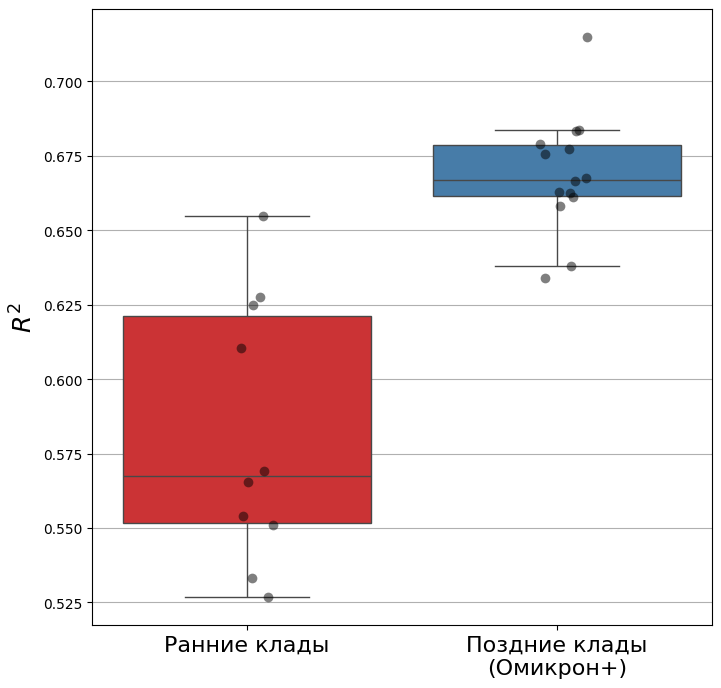

In [16]:
plt.figure(figsize=(8, 8))
sns.stripplot(
    data=metrics_total_df.query('branches == "all"'), y='r2', x='time_period', 
    s=7, jitter=0.1, color='black', alpha=0.5,
)
sns.boxplot(
    data=metrics_total_df.query('branches == "all"'), y='r2', x='time_period', 
    palette='Set1', fliersize=0,
)
plt.ylabel('$R^2$', fontsize=18)
plt.xlabel('')
plt.xticks(fontsize=16)
plt.grid(axis='y')

In [64]:
_ = metrics_total_df.query('branches == "all"')

pg.normality(_, dv='r2', group='time_period')

W      pval  normal
time_period                                          
Ранние клады               0.920385  0.360175    True
Поздние клады\n(Омикрон+)  0.939342  0.409952    True

In [65]:
pg.homoscedasticity(_, dv='r2', group='time_period')

W      pval  equal_var
levene  6.269954  0.020191      False

In [68]:
pg.pairwise_tests(_, dv='r2', between='time_period', parametric=False)

Contrast                          A             B  Paired  Parametric  \
0  time_period  Поздние клады\n(Омикрон+)  Ранние клады   False       False   

   U-val alternative     p-unc    hedges  
0  138.0   two-sided  0.000077  2.614797

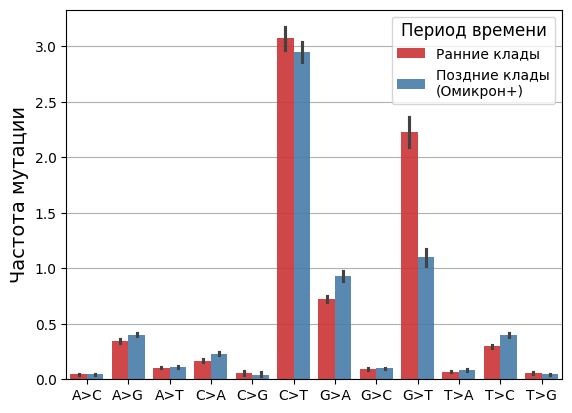

In [46]:
clades_spectra = pd.read_csv('./data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['time_period'] = clades_spectra['clade'].map(_clade2label).map(_clade2label_ru)
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
# _ = clades_spectra.groupby(['time_period', 'Mut'])['rate'].mean()
ax=sns.barplot(
    # _[_ > 0].reset_index(),
    clades_spectra,
    x='Mut', y='rate', hue='time_period',
    palette='Set1', alpha=0.9, hue_order=['Ранние клады', 'Поздние клады\n(Омикрон+)'],
)
plt.ylabel('Частота мутации', fontsize=14)
plt.xlabel('', fontsize=14)
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.legend(title='Период времени', fontsize=10, title_fontsize=12)
plt.show()

### Compare with random spectra

In [48]:
from utils import prepare_rnd_exp_aa_subst

metrics_total = []
for clade in tqdm.tqdm(clades_spectra.clade.unique(), desc='Clades'):
    obs_clade = obs[obs['clade'] == clade].copy()

    # neutral model
    spectrum_clade = clades_spectra[clades_spectra['clade'] == clade]
    exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['model'] = 'neutral'
    cur_metrics['clade'] = clade
    cur_metrics['replica'] = 1
    metrics_total.append(cur_metrics)

    # random model
    for i in range(1, 21):
        exp_aa_subst_rnd, _ = prepare_rnd_exp_aa_subst(1)
        aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst_rnd, aa_freqs_total_dct)
        cur_metrics = calc_metrics(aa_subst)
        cur_metrics['model'] = 'random'
        cur_metrics['clade'] = clade
        cur_metrics['replica'] = i
        metrics_total.append(cur_metrics)

metrics_total_df = pd.DataFrame(metrics_total).set_index(['model', 'clade', 'replica'])
metrics_total_df.to_csv('data/fit_metrics_rnd.csv', float_format='%g')

Clades: 100%|██████████| 24/24 [00:36<00:00,  1.50s/it]


([<matplotlib.axis.XTick at 0x7ffb503c4f50>,
 [Text(0, 0, 'Нейтральный'), Text(1, 0, 'Случайный')])

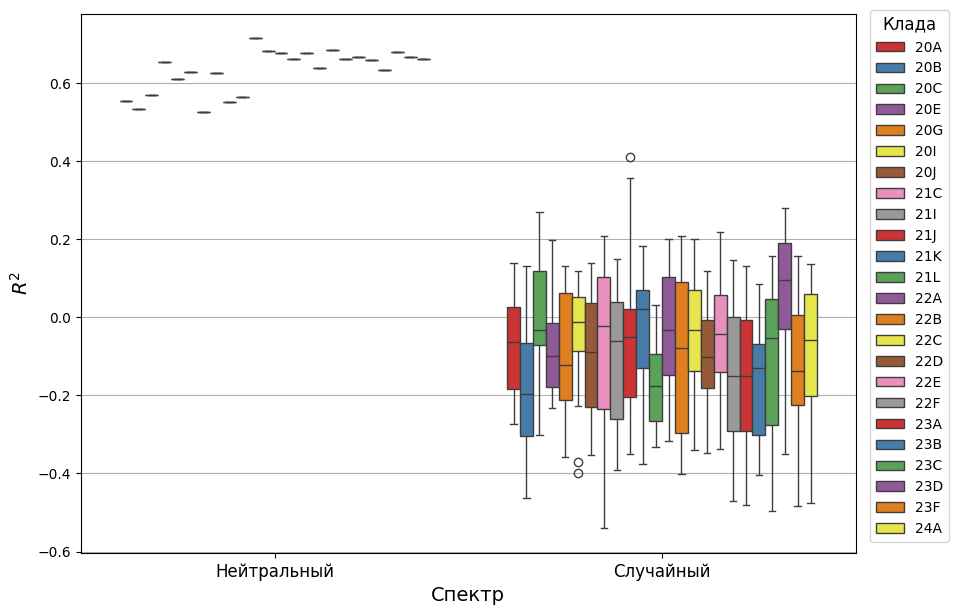

In [51]:
plt.figure(figsize=(10, 7))
ax = sns.boxplot(data=metrics_total_df.reset_index(), 
                y='r2', x='model', hue='clade',
                palette='Set1',
)
ax.set_xlabel('Спектр', fontsize=14)
ax.set_ylabel('$R^2$', fontsize=14)
plt.legend(title='Клада', title_fontsize=12, bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
plt.xticks([0,1], ['Нейтральный', 'Случайный'], fontsize=12)
# plt.savefig('./figures/fit_metrics_rnd.pdf')

### Codon positions

In [8]:
def prepare_exp_aa_subst_codons(spectrum: pd.DataFrame, rate_col='rate', gc=1, save_path=None, codon_pos='all'): 
    df_changes = collect_possible_changes(gc=gc)
    spectrum_dict = spectrum.set_index('Mut')[rate_col].to_dict()
    df_changes['rate'] = df_changes['sbs'].map(spectrum_dict)

    if codon_pos == 'all':
        df_changes_flt = df_changes.query('aa1 != "*" & aa2 != "*"')
    elif codon_pos == '12':
        df_changes_flt = df_changes.query('aa1 != "*" & aa2 != "*" & pic in [0, 1]')
    elif isinstance(codon_pos, int):
        pic=codon_pos - 1
        df_changes_flt = df_changes.query('aa1 != "*" & aa2 != "*" & pic == @pic')
    else:
        raise ValueError(f"Invalid codon_pos value: {codon_pos}. Allowed values are 'all', '12', 1, 2, or 3.")

    ## Calculate expected AA substitutions matrix
    exp_aa_subst = df_changes_flt.groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
    
    if save_path:
        exp_aa_subst.to_csv(save_path, float_format='%g', index=False)
    exp_aa_subst_matrix = exp_aa_subst.pivot(index='aa1', columns='aa2', values='rate').fillna(0.)
    return exp_aa_subst, exp_aa_subst_matrix

In [8]:
obs.codon_position.unique()

array(['2', '1', '2;2', '1;1', '3', '3;3'], dtype=object)

/home/kpotoh/.pyenv/venv_bio/lib64/python3.14/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


pos=1: $R^2$ = 0.62
pos=2: $R^2$ = 0.61
pos=3: $R^2$ = 0.43


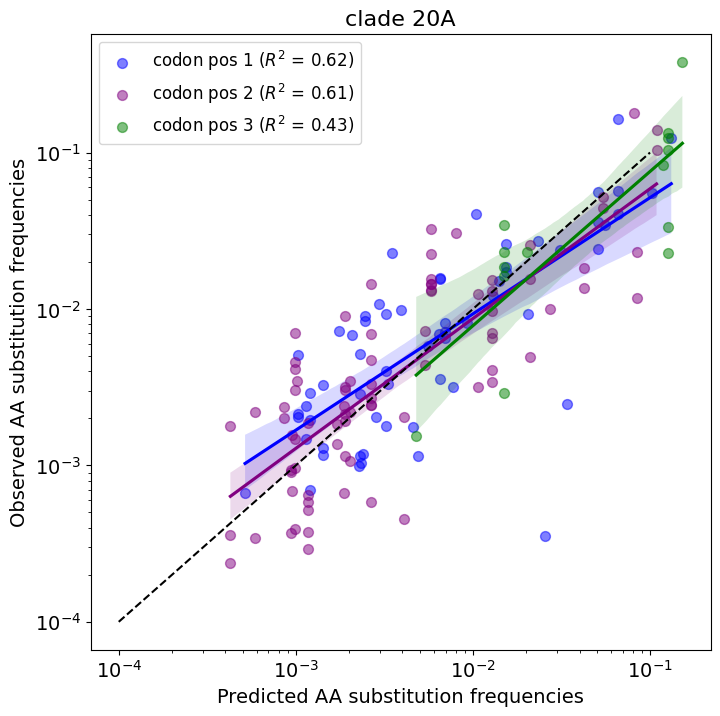

In [51]:
title = 'clade 20A'
obs_clade = obs[obs['clade'] == '20A']

_exp_aa_subst1 = prepare_exp_aa_subst_codons(spectrum_20A, codon_pos=1)[0]
_exp_aa_subst2 = prepare_exp_aa_subst_codons(spectrum_20A, codon_pos=2)[0]
_exp_aa_subst3 = prepare_exp_aa_subst_codons(spectrum_20A, codon_pos=3)[0]

obs_1 = obs_clade.query(f'codon_position == "1" | codon_position == "1;1"')
obs_2 = obs_clade.query(f'codon_position == "2" | codon_position == "2;2"')
obs_3 = obs_clade.query(f'codon_position == "3" | codon_position == "3;3"')

_aa_subst1 = prepare_aa_subst(obs_1, _exp_aa_subst1, aa_freqs_total_dct)
_aa_subst2 = prepare_aa_subst(obs_2, _exp_aa_subst2, aa_freqs_total_dct)
_aa_subst3 = prepare_aa_subst(obs_3, _exp_aa_subst3, aa_freqs_total_dct)

_aa_subst1['nobs_freqs_log'] = np.log10(_aa_subst1['nobs_freqs'])
_aa_subst1['nexp_freqs_log'] = np.log10(_aa_subst1['nexp_freqs'])
_aa_subst2['nobs_freqs_log'] = np.log10(_aa_subst2['nobs_freqs'])
_aa_subst2['nexp_freqs_log'] = np.log10(_aa_subst2['nexp_freqs'])
_aa_subst3['nobs_freqs_log'] = np.log10(_aa_subst3['nobs_freqs'])
_aa_subst3['nexp_freqs_log'] = np.log10(_aa_subst3['nexp_freqs'])

r2_1 = r2_score(_aa_subst1['nobs_freqs'], _aa_subst1['nexp_freqs'])
r2_2 = r2_score(_aa_subst2['nobs_freqs'], _aa_subst2['nexp_freqs'])
r2_3 = r2_score(_aa_subst3['nobs_freqs'], _aa_subst3['nexp_freqs'])
print(f"pos=1: $R^2$ = {r2_1:.2f}")
print(f"pos=2: $R^2$ = {r2_2:.2f}")
print(f"pos=3: $R^2$ = {r2_3:.2f}")

plt.figure(figsize=(8, 8))
sns.regplot(_aa_subst1[_aa_subst1['nobs_freqs']>0], 
            color='blue', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 1 ($R^2$ = {r2_1:.2f})')

sns.regplot(_aa_subst2[_aa_subst2['nobs_freqs']>0], 
            color='purple', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 2 ($R^2$ = {r2_2:.2f})')


ax = sns.regplot(_aa_subst3[_aa_subst3['nobs_freqs']>0], 
            color='green', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 3 ($R^2$ = {r2_3:.2f})')

ticks = np.linspace(-4, -1, 4)
ticks_minor = np.log10(np.concat([
    np.linspace(10**-4, 10**-3, 10),
    np.linspace(10**-3, 10**-2, 10)[1:],
    np.linspace(10**-2, 10**-1, 10)[1:],
]))
ax.set_xticks(ticks, ticks, size=14)
ax.set_yticks(ticks, ticks, size=14)
ax.set_xticks(ticks_minor, minor=True)
ax.set_yticks(ticks_minor, minor=True)
formatter = lambda x, pos: '10$^{' + str(int(x)) + '}$'
ax.get_xaxis().set_major_formatter(formatter)
ax.get_yaxis().set_major_formatter(formatter)
# ax.get_xaxis().set_minor_locator(LogLocator(-10, 'auto'))
# ax.get_xaxis().set_minor_locator(LogLocator())

# plt.text(-2, -4., 
#          f"r={r2_.correlation:.1f} (p={r2_.pvalue:.1g})", 
#          fontsize=10)
plt.plot([-4, -1], [-4, -1], color='black', linestyle='--',)
plt.ylabel('Observed AA substitution frequencies', fontsize=14)
plt.xlabel('Predicted AA substitution frequencies', fontsize=14)
plt.title(title, fontsize=16)
plt.legend(fontsize=12)
# plt.legend(title=f"spearmanr={r2_.correlation:.2f} (p={r2_.pvalue:.1g})", title_fontsize=14)
plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
plt.show()

In [25]:
_d = []
_corr = []
_corr_pval = []
for clade, obs_clade in obs.groupby('clade'):
    cur_ms = clades_spectra[clades_spectra['clade'] == clade].copy()
    cur_ms['rate'] /= cur_ms['rate'].sum()

    if len(cur_ms) == 0:
        continue

    _exp_aa_subst1 = prepare_exp_aa_subst_codons(cur_ms, codon_pos=1)[0]
    _exp_aa_subst2 = prepare_exp_aa_subst_codons(cur_ms, codon_pos=2)[0]
    _exp_aa_subst3 = prepare_exp_aa_subst_codons(cur_ms, codon_pos=3)[0]

    obs_1 = obs_clade.query(f'codon_position == "1" | codon_position == "1;1"')
    obs_2 = obs_clade.query(f'codon_position == "2" | codon_position == "2;2"')
    obs_3 = obs_clade.query(f'codon_position == "3" | codon_position == "3;3"')

    _aa_subst1 = prepare_aa_subst(obs_1, _exp_aa_subst1, aa_freqs_total_dct)
    _aa_subst2 = prepare_aa_subst(obs_2, _exp_aa_subst2, aa_freqs_total_dct)
    _aa_subst3 = prepare_aa_subst(obs_3, _exp_aa_subst3, aa_freqs_total_dct)

    m1 = calc_metrics(_aa_subst1)
    m2 = calc_metrics(_aa_subst2)
    m3 = calc_metrics(_aa_subst3)
    _d.append({
        'clade': clade,
        'pos1': m1['r2'],
        'pos2': m2['r2'],
        'pos3': m3['r2'],
    })
    _corr.append({
        'clade': clade,
        'pos1': m1['corr_chem_vs_rel_freq'],
        'pos2': m2['corr_chem_vs_rel_freq'],
        'pos3': m3['corr_chem_vs_rel_freq'],
    })
    _corr_pval.append({
        'clade': clade,
        'pos1': m1['corr_chem_vs_rel_freq_pval'],
        'pos2': m2['corr_chem_vs_rel_freq_pval'],
        'pos3': m3['corr_chem_vs_rel_freq_pval'],
    })
df_metrics = pd.DataFrame(_d)
df_metrics_long = df_metrics.set_index('clade')\
    .melt(var_name='position', value_name='r2', ignore_index=False).reset_index()
df_metrics_long['time_period'] = df_metrics_long['clade'].map(_clade2label).map(_clade2label_ru)

df_corr_gra = pd.DataFrame(_corr)
df_corr_gra_long = df_corr_gra.set_index('clade')\
    .melt(var_name='position', value_name='corr_chem_vs_rel_freq', ignore_index=False).reset_index()
df_corr_gra_long['time_period'] = df_corr_gra_long['clade'].map(_clade2label).map(_clade2label_ru)

df_corr_gra_pval = pd.DataFrame(_corr_pval)
df_corr_gra_pval_long = df_corr_gra_pval.set_index('clade')\
    .melt(var_name='position', value_name='corr_chem_vs_rel_freq_pval', ignore_index=False).reset_index()
df_corr_gra_pval_long['time_period'] = df_corr_gra_pval_long['clade'].map(_clade2label).map(_clade2label_ru)

df_metrics_long.head()

clade position        r2   time_period
0   20A     pos1  0.619186  Ранние клады
1   20B     pos1  0.629596  Ранние клады
2   20C     pos1  0.628102  Ранние клады
3   20E     pos1  0.704365  Ранние клады
4   20G     pos1  0.614804  Ранние клады

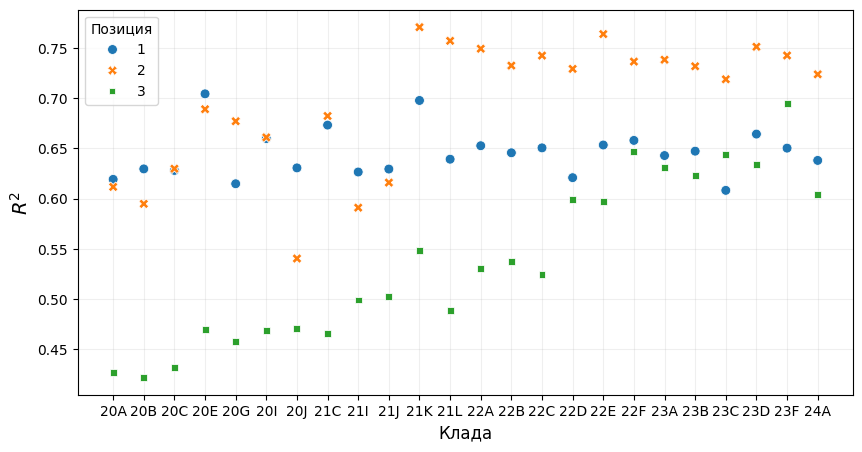

In [27]:
plt.figure(figsize=(10, 5))
_ = df_metrics_long.copy()
_['position'] = _['position'].str.slice(3)
ax = sns.scatterplot(_, x='clade', y='r2', hue='position', style='position', s=50)
plt.grid(alpha=.2)
ax.set_axisbelow(True)
ax.set_ylabel('$R^2$', fontsize=14)
ax.set_xlabel('Клада', fontsize=12)
plt.legend(title='Позиция')

Text(0.5, 0, 'Позиция кодона')

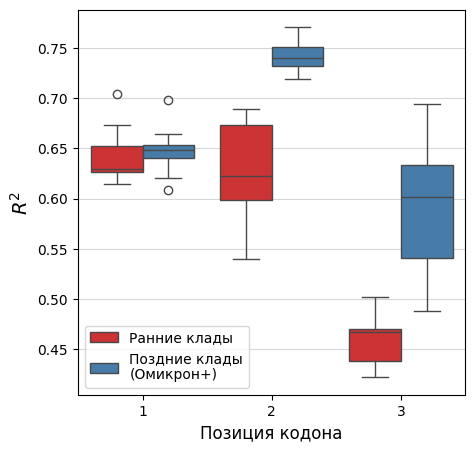

In [28]:
plt.figure(figsize=(5, 5))
# grayscale
ax = sns.boxplot(_, y='r2', hue='time_period', x='position', palette='Set1')
plt.grid(axis='y', alpha=.5)
ax.set_axisbelow(True)
plt.legend(loc='lower left')
plt.ylabel('$R^2$', fontsize=14)
plt.xlabel('Позиция кодона', fontsize=12)

In [70]:
df_metrics_long.groupby(['position', 'time_period']).r2.describe()

count      mean       std       min  \
position time_period                                                    
pos1     Early clades              10.0  0.641575  0.028516  0.614804   
         Late clades\n(Omicron+)   14.0  0.647804  0.020437  0.608233   
pos2     Early clades              10.0  0.629312  0.047992  0.540353   
         Late clades\n(Omicron+)   14.0  0.742048  0.015038  0.718884   
pos3     Early clades              10.0  0.461402  0.027699  0.422098   
         Late clades\n(Omicron+)   14.0  0.593193  0.058614  0.488322   

                                       25%       50%       75%       max  
position time_period                                                      
pos1     Early clades             0.626910  0.629524  0.652549  0.704365  
         Late clades\n(Omicron+)  0.640173  0.648781  0.653229  0.697771  
pos2     Early clades             0.599026  0.622906  0.673057  0.689083  
         Late clades\n(Omicron+)  0.732013  0.740429  0.750815  0.770729  
pos3     Early clades             0.438279  0.467170  0.470483  0.502046  
         Late clades\n(Omicron+)  0.540404  0.601790  0.633410  0.694372

In [ ]:
print(pg.normality(data=df_metrics_long.query('position == "pos1"'), dv='r2', group='time_period'))
print(pg.normality(data=df_metrics_long.query('position == "pos2"'), dv='r2', group='time_period'))
print(pg.normality(data=df_metrics_long.query('position == "pos3"'), dv='r2', group='time_period'))

                                W      pval  normal
time_period                                        
Early clades             0.802465  0.015534   False
Late clades\n(Omicron+)  0.915838  0.191497    True
                                W      pval  normal
time_period                                        
Early clades             0.940360  0.557027    True
Late clades\n(Omicron+)  0.974461  0.929941    True
                                W      pval  normal
time_period                                        
Early clades             0.914502  0.313367    True
Late clades\n(Omicron+)  0.954722  0.636107    True


In [ ]:
pd.concat([
    pg.pairwise_tests(data=df_metrics_long.query('position == "pos1"'), dv='r2', between='time_period'),
    pg.pairwise_tests(data=df_metrics_long.query('position == "pos2"'), dv='r2', between='time_period'),
    pg.pairwise_tests(data=df_metrics_long.query('position == "pos3"'), dv='r2', between='time_period'),
])

Contrast             A                        B  Paired  Parametric  \
0  time_period  Early clades  Late clades\n(Omicron+)   False        True   
0  time_period  Early clades  Late clades\n(Omicron+)   False        True   
0  time_period  Early clades  Late clades\n(Omicron+)   False        True   

          T        dof alternative         p-unc       BF10    hedges  
0 -0.590783  15.382063   two-sided  5.632462e-01      0.428 -0.249821  
0 -7.180805  10.271625   two-sided  2.596044e-05  2.951e+04 -3.318509  
0 -7.342981  19.628086   two-sided  4.787590e-07  4.056e+04 -2.628238

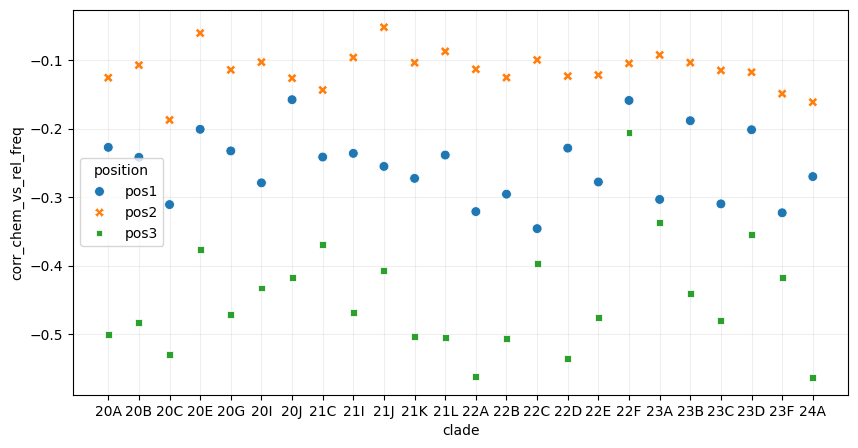

In [29]:
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(df_corr_gra_long, x='clade', y='corr_chem_vs_rel_freq', hue='position', style='position', s=50)
plt.grid(alpha=.2)
ax.set_axisbelow(True)

Text(0.5, 0, 'Позиция кодона')

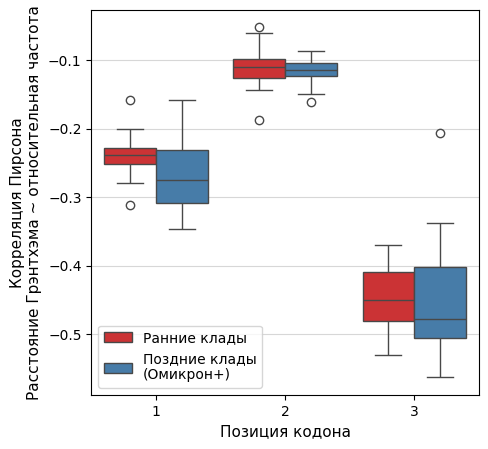

In [35]:
plt.figure(figsize=(5, 5))
_ = df_corr_gra_long.copy()
_['position'] = _['position'].str.slice(3)
ax = sns.boxplot(_, y='corr_chem_vs_rel_freq', hue='time_period', x='position', palette='Set1')
plt.grid(axis='y', alpha=.5)
ax.set_axisbelow(True)
plt.legend(loc='lower left')
plt.ylabel('Корреляция Пирсона\nРасстояние Грэнтхэма ~ относительная частота', fontsize=11)
plt.xlabel('Позиция кодона', fontsize=11)

In [36]:
df_corr_gra_pval

clade      pos1      pos2      pos3
0    20A  0.075415  0.260068  0.068493
1    20B  0.058014  0.336665  0.079768
2    20C  0.013883  0.091721  0.051101
3    20E  0.117007  0.588009  0.184818
4    20G  0.068767  0.306087  0.088815
5    20I  0.027938  0.356248  0.122280
6    20J  0.220259  0.257239  0.136887
7    21C  0.058527  0.197443  0.193034
8    21I  0.064500  0.389168  0.091643
9    21J  0.045241  0.641604  0.149109
10   21K  0.031981  0.352749  0.066824
11   21L  0.061693  0.434475  0.065687
12   22A  0.010905  0.309859  0.036545
13   22B  0.019589  0.260681  0.064404
14   22C  0.005864  0.371703  0.159227
15   22D  0.073945  0.268832  0.048707
16   22E  0.028686  0.274990  0.085801
17   22F  0.217024  0.348348  0.479349
18   23A  0.016500  0.407958  0.237747
19   23B  0.142110  0.353390  0.115023
20   23C  0.014220  0.302620  0.081787
21   23D  0.115788  0.291427  0.213270
22   23F  0.010455  0.181143  0.137157
23   24A  0.033747  0.147066  0.036095

#### Estimate grantham distances in substitutions from different codon positions

In [37]:
_d = []
gr_data = []
for clade, obs_clade in obs.groupby('clade'):
    cur_ms = clades_spectra[clades_spectra['clade'] == clade].copy()
    cur_ms['rate'] /= cur_ms['rate'].sum()

    if len(cur_ms) == 0:
        continue

    _exp_aa_subst1 = prepare_exp_aa_subst_codons(cur_ms, codon_pos=1)[0]
    _exp_aa_subst2 = prepare_exp_aa_subst_codons(cur_ms, codon_pos=2)[0]
    _exp_aa_subst3 = prepare_exp_aa_subst_codons(cur_ms, codon_pos=3)[0]

    obs_1 = obs_clade.query(f'codon_position == "1" | codon_position == "1;1"')
    obs_2 = obs_clade.query(f'codon_position == "2" | codon_position == "2;2"')
    obs_3 = obs_clade.query(f'codon_position == "3" | codon_position == "3;3"')

    _aa_subst1 = prepare_aa_subst(obs_1, _exp_aa_subst1, aa_freqs_total_dct)
    _aa_subst2 = prepare_aa_subst(obs_2, _exp_aa_subst2, aa_freqs_total_dct)
    _aa_subst3 = prepare_aa_subst(obs_3, _exp_aa_subst3, aa_freqs_total_dct)

    col_for_comp = 'obs_relative_freq'
    a1 = (_aa_subst1['grantham_distance'] * _aa_subst1[col_for_comp]).median()
    a2 = (_aa_subst2['grantham_distance'] * _aa_subst2[col_for_comp]).median()
    a3 = (_aa_subst3['grantham_distance'] * _aa_subst3[col_for_comp]).median()
    gr_data.append({
        'clade': clade,
        'pos1': a1,
        'pos2': a2,
        'pos3': a3,
    })

#     m1 = calc_metrics(_aa_subst1)
#     m2 = calc_metrics(_aa_subst2)
#     m3 = calc_metrics(_aa_subst3)
#     _d.append({
#         'clade': clade,
#         'pos1': m1['r2'],
#         'pos2': m2['r2'],
#         'pos3': m3['r2'],
#     })

# df_metrics = pd.DataFrame(_d)
# df_metrics_long = df_metrics.set_index('clade')\
#     .melt(var_name='position', value_name='r2', ignore_index=False).reset_index()
# df_metrics_long['time_period'] = df_metrics_long['clade'].map(_clade2label)
# df_metrics_long.head()

In [11]:
_aa_subst1

aa1  aa2    nobs  ref_aa1_freq  nobs_scaled  rate_exp         nexp  \
0   Ala  Pro    44.0      0.067604    31.686179  0.059498   122.032707   
1   Ala  Ser  1221.0      0.067604   879.291469  0.685389  1405.764294   
2   Ala  Thr  1176.0      0.067604   846.885149  0.511525  1049.162021   
3   Arg  Cys   675.0      0.035905   915.247052  0.975910  2001.636735   
4   Arg  Gly    96.0      0.035905   130.168470  0.130653   267.976027   
..  ...  ...     ...           ...          ...       ...          ...   
57  Tyr  His   516.0      0.045958   546.605878  0.114919   235.705282   
58  Val  Ile  1551.0      0.080222   941.255777  0.383644   786.871516   
59  Val  Leu   884.0      0.080222   536.473312  0.402192   824.914854   
60  Val  Met   171.0      0.080222   103.774815  0.127881   262.290505   
61  Val  Phe   729.0      0.080222   442.408421  0.342694   702.882147   

           diff          pe  nobs_freqs  nexp_freqs  obs_relative_freq  \
0    -90.346528 -285.129135    0.001230    0.004738           0.259653   
1   -526.472825  -59.874665    0.034142    0.054584           0.625490   
2   -202.276872  -23.884806    0.032884    0.040738           0.807201   
3  -1086.389684 -118.699064    0.035538    0.077721           0.457249   
4   -137.807557 -105.868616    0.005054    0.010405           0.485747   
..          ...         ...         ...         ...                ...   
57   310.900597   56.878385    0.021224    0.009152           2.319023   
58   154.384261   16.401946    0.036548    0.030553           1.196200   
59  -288.441542  -53.766243    0.020831    0.032031           0.650338   
60  -158.515690 -152.749673    0.004029    0.010184           0.395648   
61  -260.473726  -58.876304    0.017178    0.027292           0.629420   

    grantham_distance  
0                27.0  
1                99.0  
2                58.0  
3               180.0  
4               125.0  
..                ...  
57               83.0  
58               29.0  
59               32.0  
60               21.0  
61               50.0  

[62 rows x 13 columns]

Text(0.5, 0, 'Позиция кодона')

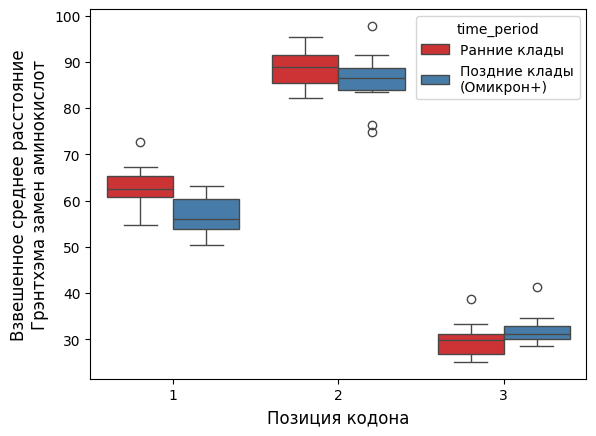

In [43]:
_ = pd.DataFrame(gr_data)
_['time_period'] = _['clade'].map(_clade2label).map(_clade2label_ru)
_.rename(columns={
    'pos1':'1',
    'pos2':'2',
    'pos3':'3',
}, inplace=True)
_long = _.melt(id_vars=['clade', 'time_period'], var_name='position', value_name='mean_grantham_distance')
sns.boxplot(data=_long, x='position', y='mean_grantham_distance', hue='time_period', palette='Set1')
plt.ylabel('Взвешенное среднее расстояние\nГрэнтхэма замен аминокислот', fontsize=12)
plt.xlabel('Позиция кодона', fontsize=12)

In [20]:
print(pg.normality(_long.query('position == "pos1"'), dv='mean_grantham_distance', group='time_period'))
print(pg.normality(_long.query('position == "pos2"'), dv='mean_grantham_distance', group='time_period'))
print(pg.normality(_long.query('position == "pos3"'), dv='mean_grantham_distance', group='time_period'))

                                W      pval  normal
time_period                                        
Early clades             0.972672  0.914454    True
Late clades\n(Omicron+)  0.946791  0.512083    True
                                W      pval  normal
time_period                                        
Early clades             0.947130  0.634688    True
Late clades\n(Omicron+)  0.932461  0.330257    True
                                W      pval  normal
time_period                                        
Early clades             0.915267  0.319165    True
Late clades\n(Omicron+)  0.819101  0.008683   False


In [27]:
print(pg.pairwise_tests(_long.query('position == "pos1"'), dv='mean_grantham_distance', between='time_period')['p-unc'])
print(pg.pairwise_tests(_long.query('position == "pos2"'), dv='mean_grantham_distance', between='time_period')['p-unc'])
print(pg.pairwise_tests(_long.query('position == "pos3"'), dv='mean_grantham_distance', between='time_period')['p-unc'])

0    0.003394
Name: p-unc, dtype: float64
0    0.255241
Name: p-unc, dtype: float64
0    0.225639
Name: p-unc, dtype: float64


/home/kpotoh/.pyenv/venv_bio/lib64/python3.14/site-packages/seaborn/distributions.py:413: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)
/home/kpotoh/.pyenv/venv_bio/lib64/python3.14/site-packages/seaborn/distributions.py:413: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)
/home/kpotoh/.pyenv/venv_bio/lib64/python3.14/site-packages/seaborn/distributions.py:413: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='grantham_distance', ylabel='Count'>

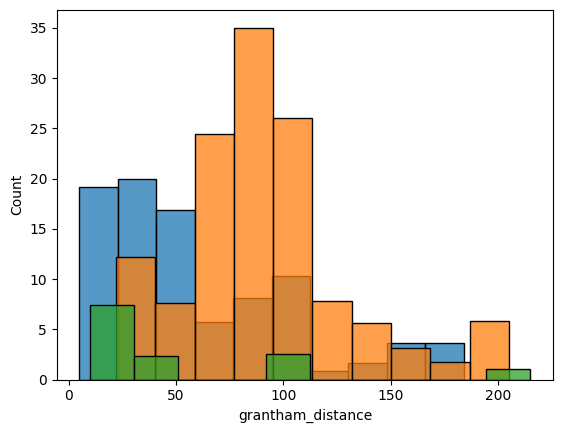

In [13]:
sns.histplot(_aa_subst1, x='grantham_distance', weights='obs_relative_freq')
sns.histplot(_aa_subst2, x='grantham_distance', weights='obs_relative_freq')
sns.histplot(_aa_subst3, x='grantham_distance', weights='obs_relative_freq')

### Genes

In [44]:
aa_freqs_df = pd.read_csv('./data/ref_aa_freqs.csv', index_col=0)
aa_freqs_df

R    V    C    G    S    A    L    T    P    D    Y    F    I  \
ORF1ab        113  228   88  149  162  179  233  182  110  178  140  142  128   
ORF1a;ORF1ab  131  371  138  264  294  309  435  345  164  211  195  208  215   
S              42   97   40   82   99   79  108   97   58   62   54   77   76   
ORF3a           6   25    7   14   22   13   30   24   12   13   17   14   21   
E               3   13    3    1    8    4   14    4    2    1    4    5    3   
M              14   12    4   14   15   19   35   13    5    6    9   11   20   
ORF6            1    3    0    0    4    1    8    3    1    4    2    3   10   
ORF7a           5    8    6    4    7    9   15   10    6    2    5   10    8   
ORF7b           0    1    2    0    2    2   11    1    0    2    1    6    5   
ORF8            4   12    7    5    9    5   10    5    7    7    7    8   10   
N              29    8    0   43   37   37   27   32   28   24   11   13   14   
ORF10           2    4    1    1    2    2    4    2    1    1    3    4    3   

                N    K    Q    E   H    M   W  
ORF1ab        151  158   88  101  70   63  32  
ORF1a;ORF1ab  233  276  151  239  75  105  46  
S              88   61   62   48  17   14  12  
ORF3a           8   11    9   11   8    4   6  
E               5    2    0    2   0    1   0  
M              11    7    4    7   5    4   7  
ORF6            4    4    3    5   1    3   1  
ORF7a           2    7    5    8   3    1   0  
ORF7b           1    0    1    3   2    2   1  
ORF8            2    5    6    6   4    1   1  
N              22   31   35   12   4    7   5  
ORF10           5    0    1    0   0    2   0

In [45]:
metrics_data = []
for (cur_clade, cur_protein), cur_obs in obs.groupby(['clade', 'protein']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    cur_exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)

    cur_aa_content = aa_freqs_df.loc[cur_protein].rename(index=amino_acid_codes).to_dict()

    cur_obs_flt = cur_obs[(cur_obs.aa1 != '*') & (cur_obs.aa2 != '*')]
    aa_subst = prepare_aa_subst(cur_obs_flt, cur_exp_aa_subst, cur_aa_content)

    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['clade'] = cur_clade
    cur_metrics['protein'] = cur_protein
    metrics_data.append(cur_metrics)

metrics_data = pd.DataFrame(metrics_data).groupby(['clade', 'protein']).mean().reset_index()
metrics_data['time_period']  = metrics_data['clade'].map(_clade2label)
metrics_data['protein_size'] = metrics_data['protein'].map(aa_freqs_df.sum(1).to_dict())
metrics_data

clade       protein        r2      mape      wape     slope  intercept  \
0     20A             E  0.371716  1.039506  0.709010  0.307516   0.004617   
1     20A             M  0.156468  2.122364  0.844577  0.296904   0.004687   
2     20A             N  0.319434  1.678265  0.755365  0.408088   0.003946   
3     20A         ORF10  0.504057  0.692208  0.547901  0.424706   0.003835   
4     20A  ORF1a;ORF1ab  0.501862  2.527333  0.685590  0.574784   0.002835   
..    ...           ...       ...       ...       ...       ...        ...   
283   24A          ORF6  0.116197  0.764913  0.639325  0.340048   0.004400   
284   24A         ORF7a  0.478540  1.222643  0.632450  0.484856   0.003434   
285   24A         ORF7b  0.297095  0.691293  0.620002  0.356036   0.004293   
286   24A          ORF8  0.530623  1.110309  0.598047  0.653937   0.002307   
287   24A             S  0.150795  1.666304  0.762340  0.640841   0.002394   

     spearman_corr    spearman_p  pearson_corr  ...   ks_stat          ks_p  \
0         0.529720  3.166222e-12      0.623422  ...  0.593333  7.588478e-25   
1         0.655262  9.251162e-20      0.448959  ...  0.326667  1.756439e-07   
2         0.602832  3.286698e-16      0.579013  ...  0.206667  3.220729e-03   
3         0.414974  1.292551e-07      0.722696  ...  0.580000  1.105089e-23   
4         0.757632  3.238773e-29      0.714193  ...  0.146667  7.930977e-02   
..             ...           ...           ...  ...       ...           ...   
283       0.243469  2.680013e-03      0.452835  ...  0.520000  7.237717e-19   
284       0.617064  4.152354e-17      0.691824  ...  0.226667  8.634332e-04   
285       0.209208  1.018963e-02      0.552690  ...  0.580000  1.105089e-23   
286       0.635189  2.547006e-18      0.741746  ...  0.233333  5.413960e-04   
287       0.634487  2.847532e-18      0.602616  ...  0.093333  5.321869e-01   

         rmse  log_likelihood  mut_count  mut_type_count  \
0    0.018092       -4.875340      543.0            61.0   
1    0.015636       -5.405978     1073.0           101.0   
2    0.013178       -5.353119     4340.0           126.0   
3    0.013492       -4.906098      467.0            63.0   
4    0.009873       -5.320390    26469.0           146.0   
..        ...             ...        ...             ...   
283  0.014488       -5.756893      407.0            72.0   
284  0.011924       -5.249714     1919.0           116.0   
285  0.015061       -5.386827      394.0            63.0   
286  0.008993       -5.445576     1799.0           115.0   
287  0.010028       -5.784955    11659.0           144.0   

     corr_chem_vs_rel_freq  corr_chem_vs_rel_freq_pval  \
0                -0.066598                    0.418092   
1                -0.232819                    0.004143   
2                -0.061189                    0.456973   
3                -0.047838                    0.561021   
4                -0.220376                    0.006731   
..                     ...                         ...   
283              -0.131603                    0.108427   
284              -0.148203                    0.070306   
285              -0.022193                    0.787489   
286               0.167531                    0.040445   
287              -0.120396                    0.142227   

                 time_period  protein_size  
0               Early clades            75  
1               Early clades           222  
2               Early clades           419  
3               Early clades            38  
4               Early clades          4405  
..                       ...           ...  
283  Late clades\n(Omicron+)            61  
284  Late clades\n(Omicron+)           121  
285  Late clades\n(Omicron+)            43  
286  Late clades\n(Omicron+)           121  
287  Late clades\n(Omicron+)          1273  

[288 rows x 22 columns]

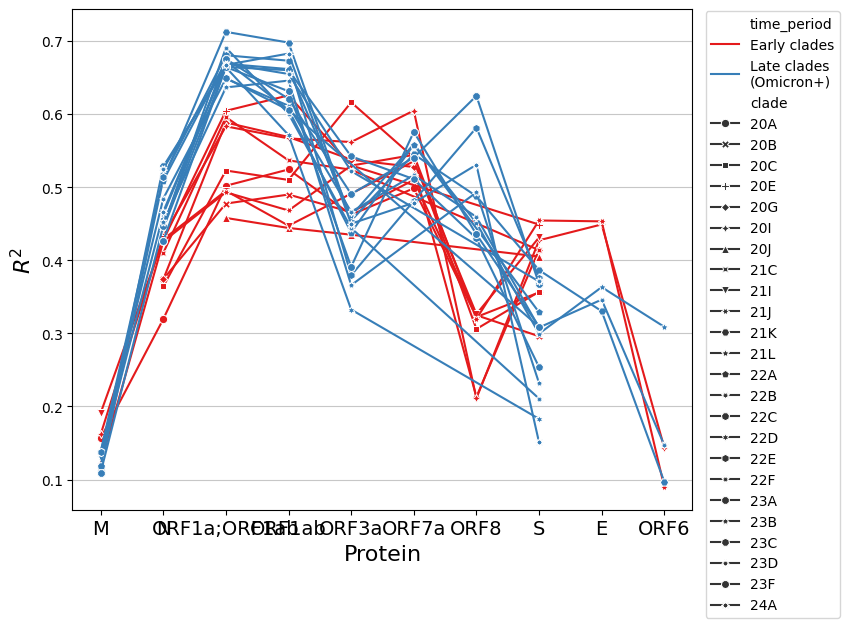

In [9]:
_ = metrics_data.query('mut_count > 1000 & protein_size > 50')
plt.figure(figsize=(8, 6.5))
ax = sns.lineplot(
    _, x='protein', y='r2', style='clade', hue='time_period', 
    markers=True, dashes=False, palette='Set1',)
plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Protein', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()

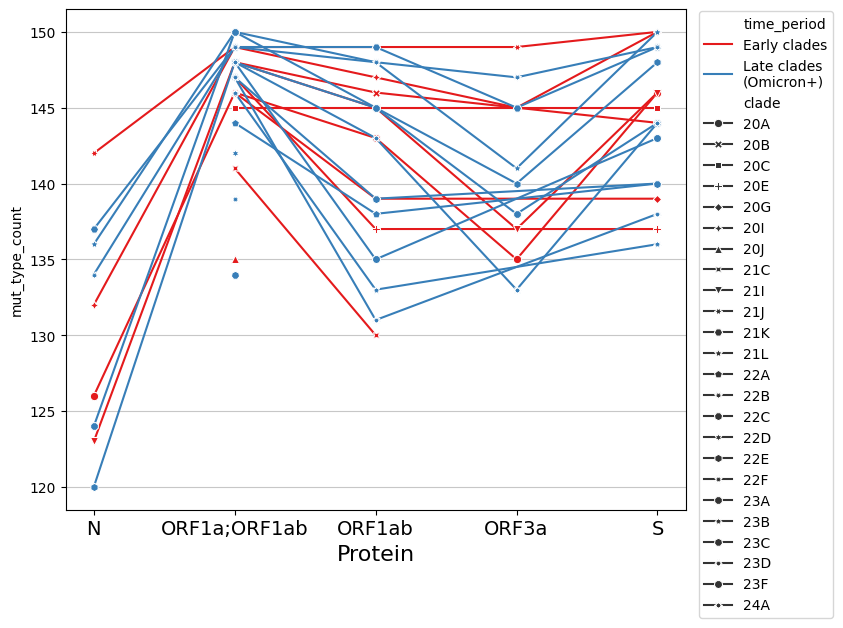

In [96]:
_ = metrics_data[metrics_data.protein.isin(['ORF3a', 'S', 'N', 'ORF1ab', 'ORF1a;ORF1ab'])]\
    .query('mut_count > 4000')
plt.figure(figsize=(8, 6.5))
ax = sns.lineplot(
    _, x='protein', y='mut_type_count', style='clade', hue='time_period', 
    markers=True, dashes=False, palette='Set1',)
plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
# plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Protein', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()


<Axes: xlabel='clade', ylabel='r2'>

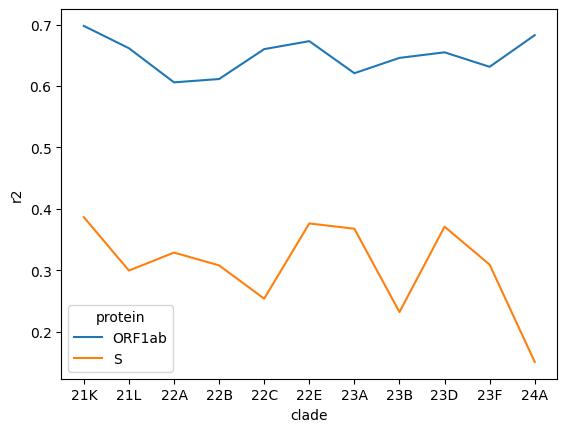

In [97]:
# no significant tendensies
_ = metrics_data.query('(protein == "S" | protein == "ORF1ab") & mut_count > 4000 & time_period != "Early clades"')
sns.lineplot(_, x='clade', y='r2', hue='protein')

Text(0.5, 28.999999999999964, 'Mutations count in clade')

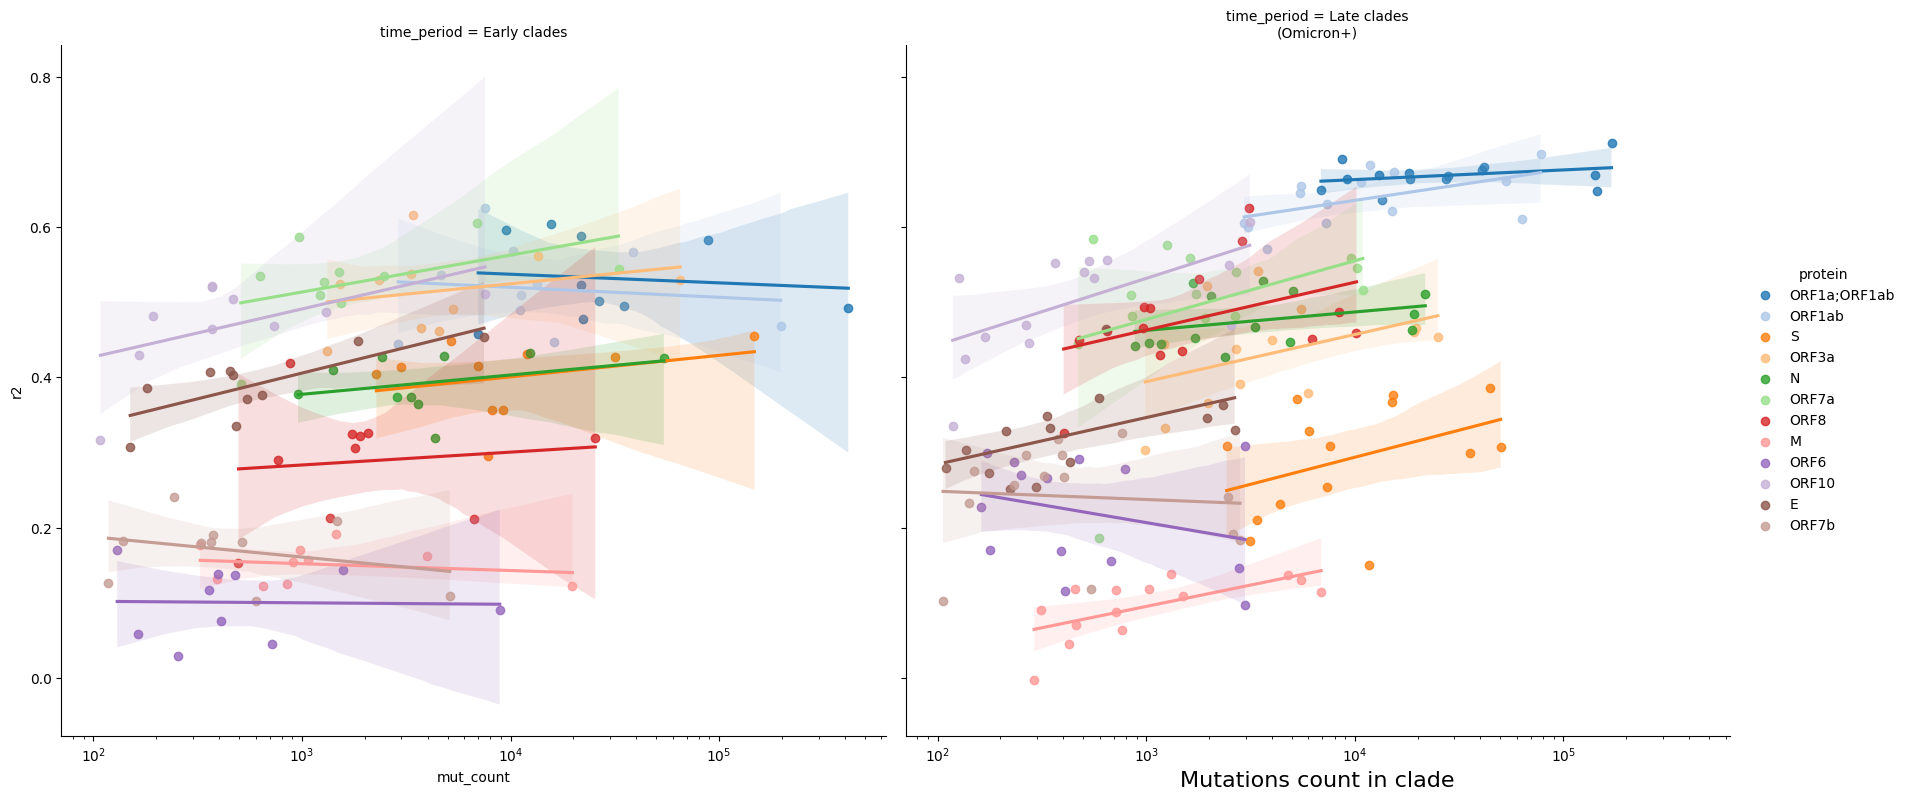

In [12]:
sns.lmplot(metrics_data, y='r2', x='mut_count', hue='protein', col='time_period',
           hue_order=metrics_data.groupby('protein')['mut_count'].mean().sort_values(ascending=False).index,
           height=8, aspect=1.1, logx=True, palette='tab20')
plt.xscale('log')
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Mutations count in clade', fontsize=16)

#### Check now on ORF1ab proteins

In [46]:
ref = next(SeqIO.parse("data/NC_045512.2.gb", "genbank"))

_nfea = 15
ref_df2 = pd.DataFrame([f.qualifiers for f in ref.features if f.type == "mat_peptide"][:_nfea])
ref_df2.drop(columns=["locus_tag"], inplace=True)
ref_df2["gene"] = ref_df2["gene"].apply(lambda x: x[0])
ref_df2["product"] = ref_df2["product"].apply(lambda x: x[0])
ref_df2["protein_id"] = ref_df2["protein_id"].apply(lambda x: x[0])

pr_seqs = [str(f.extract(ref.seq).translate(table=1, )) for f in ref.features if f.type == "mat_peptide"][:_nfea]
ref_df2["translation"] = pr_seqs
# ref_df2["is_in_ORF1ab"] = ref_df2["translation"].apply(lambda x: x in ref_df.loc[0, "translation"] or x in ref_df.loc[1, "translation"])

ref_df2.loc[0, "product"] = 'nsp1'
ref_df2.loc[4, "product"] = 'nsp5 (Mpro)'
ref_df2.loc[10, "product"] = 'nsp12 (RdRp)'
ref_df2.loc[11, "product"] = 'nsp13'
ref_df2.loc[12, "product"] = 'nsp14'
ref_df2.loc[13, "product"] = 'nsp15'
ref_df2.loc[14, "product"] = 'nsp16'

ref_df2["size"] = ref_df2["translation"].str.len()
# ref_df2 = ref_df2.query('size > 100')
# ref_df2 = ref_df2[ref_df2['product'] != 'ORF1a polyprotein']
# ref_df2.to_csv('./data/ref_proteins.csv', index=False)
ref_df2.head()
aa_freqs_df_orf1ab = pd.DataFrame(ref_df2.set_index('product')['translation']\
                           .apply(Counter).to_dict()).T.fillna(0).astype(int)
aa_freqs_df_orf1ab.to_csv('./data/ref_aa_freqs_orf1ab.csv')
aa_freqs_df_orf1ab

M    E    S    L    V   P   G   F    N    K    T   H   Q   R  \
nsp1           3   18   10   21   21   8  22   5    6    9    7   7   7  10   
nsp2          10   54   36   60   46  22  49  30   31   51   46   9  18  19   
nsp3          37  119  139  178  165  74  98  80  113  140  164  35  68  45   
nsp4           9   15   38   49   46  20  27  37   21   17   41   9   9  20   
nsp5 (Mpro)   10    9   16   29   27  13  26  17   21   11   24   7  14  11   
nsp6          17    3   17   41   28   7  15  22   10   12   21   4   7   9   
nsp7           4    5   10   15    9   0   1   1    3    6    4   1   6   2   
nsp8           9    9   15   18   13   6   3   5   13   15   13   0  11   7   
nsp9           2    3    5   15    6   6   9   4    7    7   12   0   4   6   
nsp10          4    4    6    8    9   8  13   5    7    8   13   3   6   2   
nsp12 (RdRp)  25   31   53   83   74  30  45  57   56   51   61  27  28  43   
nsp13          8   23   40   50   53  30  32  24   30   34   50  12  18  30   
nsp14         13   16   28   40   44  26  30  30   28   30   32  20  16  22   
nsp15          5   23   20   29   38  14  22  21   17   25   21   6  15   9   
nsp16         12    8   23   32   19  10  20  11   21   18   18   5  12   9   

                D    A   C   Y   I   W  
nsp1            9    7   1   5   3   1  
nsp2           20   44  27  19  40   7  
nsp3          103  126  51  95  97  18  
nsp4           22   36  16  32  30   6  
nsp5 (Mpro)    17   17  12  11  11   3  
nsp6            8   20  10  17  16   6  
nsp7            5    5   3   0   2   1  
nsp8           13   28   2   6  10   2  
nsp9            6   10   3   5   2   1  
nsp10           7   13  13   5   4   1  
nsp12 (RdRp)   75   64  29  58  33   9  
nsp13          29   46  26  34  29   3  
nsp14          34   35  23  25  25  10  
nsp15          23   16   5  11  23   3  
nsp16          18   20   5  12  18   7

In [47]:
aamut_fitness = pd.read_csv('./data/bloom_etal/aamut_fitness_by_clade.csv')
aamut_fitness['aa1'] = aamut_fitness['aa_mutation'].str[0]
aamut_fitness['aa2'] = aamut_fitness['aa_mutation'].str[-1]
aamut_fitness_ns = aamut_fitness.query('aa1 != aa2 & aa1 != "*" & aa2 != "*"')
aamut_fitness

clade  gene clade_founder_aa mutant_aa  aa_site aa_mutation  \
0         20A     E                A         A       22        A22A   
1         20A     E                A         A       32        A32A   
2         20A     E                A         A       36        A36A   
3         20A     E                A         A       41        A41A   
4         20A     E                A         D       22        A22D   
...       ...   ...              ...       ...      ...         ...   
2893365   24A  nsp1                Y         F       97        Y97F   
2893366   24A  nsp1                Y         H       97        Y97H   
2893367   24A  nsp1                Y         N       97        Y97N   
2893368   24A  nsp1                Y         S       97        Y97S   
2893369   24A  nsp1                Y         Y       97        Y97Y   

         expected_count  actual_count  count_terminal  count_non_terminal  \
0               1.87400             2               0                   2   
1              14.74200            20              14                   6   
2              14.48000             1               0                   1   
3              14.48000             3               2                   1   
4               0.67725             0               0                   0   
...                 ...           ...             ...                 ...   
2893365         0.77908             0               0                   0   
2893366         2.17910             0               0                   0   
2893367         0.48805             0               0                   0   
2893368         0.20445             0               0                   0   
2893369        18.50500            27              20                   7   

         mean_log_size  subset_of_ORF1ab  delta_fitness aa1 aa2  
0              2.41010             False       0.051727   A   A  
1              0.41743             False       0.296350   A   A  
2              1.94590             False      -2.301200   A   A  
3              0.82833             False      -1.453900   A   A  
4              0.00000             False      -0.856330   A   D  
...                ...               ...            ...  ..  ..  
2893365        0.00000              True      -0.939290   Y   F  
2893366        0.00000              True      -1.678600   Y   H  
2893367        0.00000              True      -0.681130   Y   N  
2893368        0.00000              True      -0.342810   Y   S  
2893369        0.34553              True       0.369480   Y   Y  

[2893370 rows x 15 columns]

In [48]:
metrics_data2 = []
for (cur_clade, cur_protein), cur_obs in aamut_fitness.query('subset_of_ORF1ab == True')\
        .rename(columns={'actual_count': 'count'}).groupby(['clade', 'gene']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    cur_exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)

    cur_aa_content = aa_freqs_df_orf1ab.loc[cur_protein].rename(index=amino_acid_codes).to_dict()

    cur_obs_flt = cur_obs[(cur_obs.aa1 != '*') & (cur_obs.aa2 != '*')]
    aa_subst = prepare_aa_subst(cur_obs_flt, cur_exp_aa_subst, cur_aa_content)

    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['clade'] = cur_clade
    cur_metrics['protein'] = cur_protein
    metrics_data2.append(cur_metrics)

metrics_data2 = pd.DataFrame(metrics_data2).groupby(['clade', 'protein']).mean().reset_index()
metrics_data2['time_period']  = metrics_data2['clade'].map(_clade2label)
metrics_data2['protein_size'] = metrics_data2['protein'].map(aa_freqs_df_orf1ab.sum(1).to_dict())
metrics_data2

clade       protein        r2      mape      wape     slope  intercept  \
0     20A          nsp1  0.098082  1.299458  0.870677  0.338603   0.004409   
1     20A         nsp10  0.300892  1.470466  0.809886  0.352992   0.004313   
2     20A  nsp12 (RdRp)  0.406790  1.457408  0.703233  0.529994   0.003133   
3     20A         nsp13  0.423181  2.229857  0.675638  0.451433   0.003657   
4     20A         nsp14  0.438659  2.055602  0.662436  0.468886   0.003541   
..    ...           ...       ...       ...       ...       ...        ...   
355   24A   nsp5 (Mpro)  0.232853  1.974763  0.783681  0.242160   0.005052   
356   24A          nsp6  0.322991  1.490114  0.761351  0.327373   0.004484   
357   24A          nsp7  0.208508  0.802231  0.669496  0.289685   0.004735   
358   24A          nsp8  0.315783  1.100418  0.766346  0.280921   0.004794   
359   24A          nsp9  0.376130  0.927955  0.728765  0.334424   0.004437   

     spearman_corr    spearman_p  pearson_corr  ...   ks_stat          ks_p  \
0         0.534138  1.933891e-12      0.444943  ...  0.386667  2.176881e-10   
1         0.447285  9.565347e-09      0.554610  ...  0.486667  1.799621e-16   
2         0.706998  4.982474e-24      0.655766  ...  0.220000  1.357878e-03   
3         0.665718  1.486164e-20      0.651801  ...  0.273333  2.445506e-05   
4         0.674376  3.089473e-21      0.663694  ...  0.246667  2.040625e-04   
..             ...           ...           ...  ...       ...           ...   
355       0.589965  1.956153e-15      0.482905  ...  0.386667  2.176881e-10   
356       0.561419  7.813735e-14      0.568373  ...  0.373333  1.072155e-09   
357       0.261208  1.243906e-03      0.475685  ...  0.660000  3.254808e-31   
358       0.480848  4.725946e-10      0.566324  ...  0.506667  6.934381e-18   
359       0.361342  5.547211e-06      0.618120  ...  0.600000  1.928738e-25   

         rmse  log_likelihood  mut_count  mut_type_count  \
0    0.014050       -5.608787     1186.0            92.0   
1    0.014790       -5.445867      500.0            77.0   
2    0.010729       -5.352490     3519.0           123.0   
3    0.012346       -5.182096     3332.0           117.0   
4    0.011940       -5.183488     2871.0           125.0   
..        ...             ...        ...             ...   
355  0.020213       -5.361394     1238.0            92.0   
356  0.016532       -5.188467     1330.0            94.0   
357  0.016906       -5.521615      339.0            51.0   
358  0.019298       -5.067957      917.0            74.0   
359  0.016895       -5.257563      492.0            60.0   

     corr_chem_vs_rel_freq  corr_chem_vs_rel_freq_pval  \
0                -0.125167                    0.126968   
1                -0.137309                    0.093825   
2                -0.305540                    0.000143   
3                -0.279700                    0.000527   
4                -0.207700                    0.010760   
..                     ...                         ...   
355              -0.084524                    0.303768   
356              -0.222199                    0.006279   
357              -0.089014                    0.278710   
358              -0.246488                    0.002361   
359              -0.197443                    0.015442   

                 time_period  protein_size  
0               Early clades           180  
1               Early clades           139  
2               Early clades           932  
3               Early clades           601  
4               Early clades           527  
..                       ...           ...  
355  Late clades\n(Omicron+)           306  
356  Late clades\n(Omicron+)           290  
357  Late clades\n(Omicron+)            83  
358  Late clades\n(Omicron+)           198  
359  Late clades\n(Omicron+)           113  

[360 rows x 22 columns]

In [49]:
metrics_data3 = []
for (cur_clade, cur_protein), cur_obs in aamut_fitness.query('subset_of_ORF1ab == False')\
        .rename(columns={'actual_count': 'count'}).groupby(['clade', 'gene']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    cur_exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)

    if cur_protein == 'ORF9b':
        continue
    cur_aa_content = aa_freqs_df.loc[cur_protein].rename(index=amino_acid_codes).to_dict()

    cur_obs_flt = cur_obs[(cur_obs.aa1 != '*') & (cur_obs.aa2 != '*')]
    aa_subst = prepare_aa_subst(cur_obs_flt, cur_exp_aa_subst, cur_aa_content)

    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['clade'] = cur_clade
    cur_metrics['protein'] = cur_protein
    metrics_data3.append(cur_metrics)

metrics_data3 = pd.DataFrame(metrics_data3).groupby(['clade', 'protein']).mean().reset_index()
metrics_data3['time_period']  = metrics_data3['clade'].map(_clade2label)
metrics_data3['protein_size'] = metrics_data3['protein'].map(aa_freqs_df.sum(1).to_dict())
metrics_data3

clade protein        r2      mape      wape     slope  intercept  \
0     20A       E  0.371264  1.058646  0.709295  0.305054   0.004633   
1     20A       M  0.151670  2.095201  0.854288  0.290374   0.004731   
2     20A       N  0.430019  1.537318  0.657325  0.477488   0.003483   
3     20A   ORF10  0.503359  0.685663  0.548716  0.417067   0.003886   
4     20A  ORF1ab  0.527153  1.830942  0.660767  0.590086   0.002733   
..    ...     ...       ...       ...       ...       ...        ...   
259   24A    ORF6  0.119110  0.761637  0.638568  0.338937   0.004407   
260   24A   ORF7a  0.480256  1.212433  0.628503  0.483168   0.003446   
261   24A   ORF7b  0.300487  0.703329  0.624007  0.352592   0.004316   
262   24A    ORF8  0.535064  1.023749  0.583160  0.645887   0.002361   
263   24A       S  0.176699  1.555629  0.757763  0.636606   0.002423   

     spearman_corr    spearman_p  pearson_corr  ...   ks_stat          ks_p  \
0         0.537263  1.358761e-12      0.624194  ...  0.600000  1.928738e-25   
1         0.656990  6.873028e-20      0.443292  ...  0.326667  1.756439e-07   
2         0.709355  3.025832e-24      0.659023  ...  0.246667  2.040625e-04   
3         0.422678  7.119886e-08      0.725170  ...  0.593333  7.588478e-25   
4         0.777813  1.180675e-31      0.730218  ...  0.133333  1.390622e-01   
..             ...           ...           ...  ...       ...           ...   
259       0.245469  2.464399e-03      0.453424  ...  0.520000  7.237717e-19   
260       0.617916  3.656327e-17      0.693017  ...  0.226667  8.634332e-04   
261       0.208050  1.062543e-02      0.554252  ...  0.593333  7.588478e-25   
262       0.615526  5.219231e-17      0.742492  ...  0.246667  2.040625e-04   
263       0.636474  2.075016e-18      0.607944  ...  0.093333  5.321869e-01   

         rmse  log_likelihood  mut_count  mut_type_count  \
0    0.018267       -4.856139      538.0            60.0   
1    0.015831       -5.405288     1054.0           101.0   
2    0.011731       -5.208611     5188.0           120.0   
3    0.013796       -4.860284      454.0            61.0   
4    0.009580       -5.283857    38877.0           147.0   
..        ...             ...        ...             ...   
259  0.014530       -5.750387      404.0            72.0   
260  0.011967       -5.242409     1907.0           116.0   
261  0.015215       -5.367118      390.0            61.0   
262  0.009071       -5.429621     1760.0           113.0   
263  0.010028       -5.759022    11408.0           143.0   

     corr_chem_vs_rel_freq  corr_chem_vs_rel_freq_pval  \
0                -0.047704                    0.562117   
1                -0.235193                    0.003765   
2                -0.176519                    0.030710   
3                -0.049297                    0.549120   
4                -0.244098                    0.002610   
..                     ...                         ...   
259              -0.138471                    0.091052   
260              -0.145978                    0.074673   
261              -0.019693                    0.810953   
262               0.162566                    0.046856   
263              -0.120200                    0.142880   

                 time_period  protein_size  
0               Early clades            75  
1               Early clades           222  
2               Early clades           419  
3               Early clades            38  
4               Early clades          2695  
..                       ...           ...  
259  Late clades\n(Omicron+)            61  
260  Late clades\n(Omicron+)           121  
261  Late clades\n(Omicron+)            43  
262  Late clades\n(Omicron+)           121  
263  Late clades\n(Omicron+)          1273  

[264 rows x 22 columns]

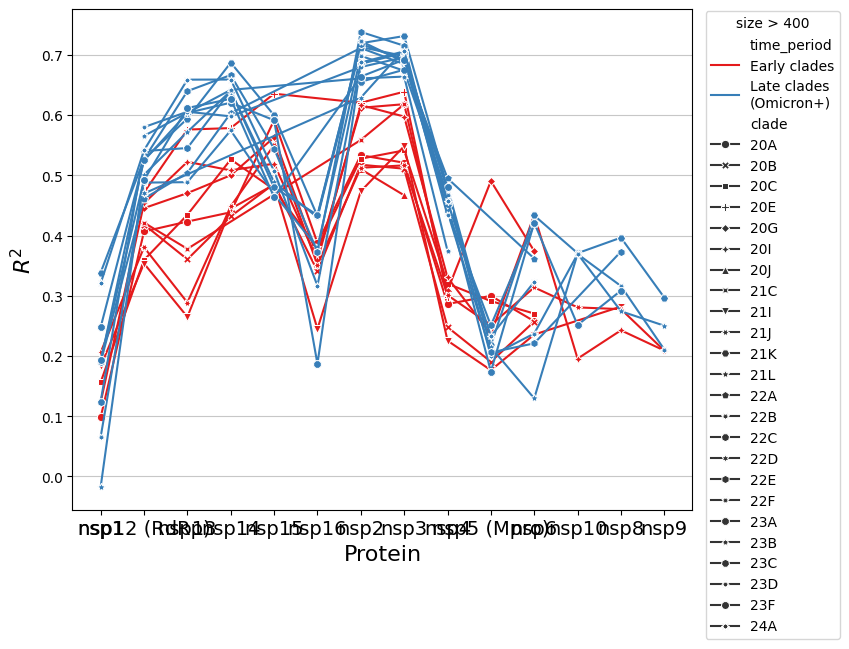

In [18]:
_ = metrics_data2.query('mut_count > 1000 & protein_size > 100')
plt.figure(figsize=(8, 6.5))
ax = sns.lineplot(
    _, x='protein', y='r2', style='clade', hue='time_period', 
    markers=True, dashes=False, palette='Set1',)
plt.legend(title='size > 400', bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Protein', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()

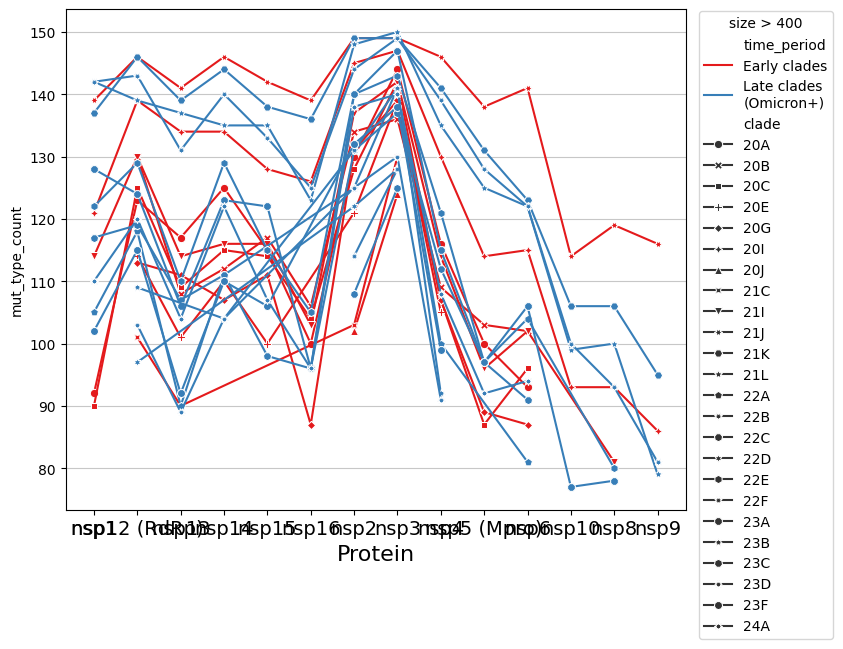

In [19]:
_ = metrics_data2.query('mut_count > 1000 & protein_size > 100')
plt.figure(figsize=(8, 6.5))
ax = sns.lineplot(
    _, x='protein', y='mut_type_count', style='clade', hue='time_period', 
    markers=True, dashes=False, palette='Set1',)
plt.legend(title='size > 400', bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.xlabel('Protein', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()

In [53]:
metrics_data_tot = pd.concat([metrics_data3, metrics_data2], ignore_index=True)
metrics_data_tot['time_period']  = metrics_data_tot['time_period'].map(_clade2label_ru)

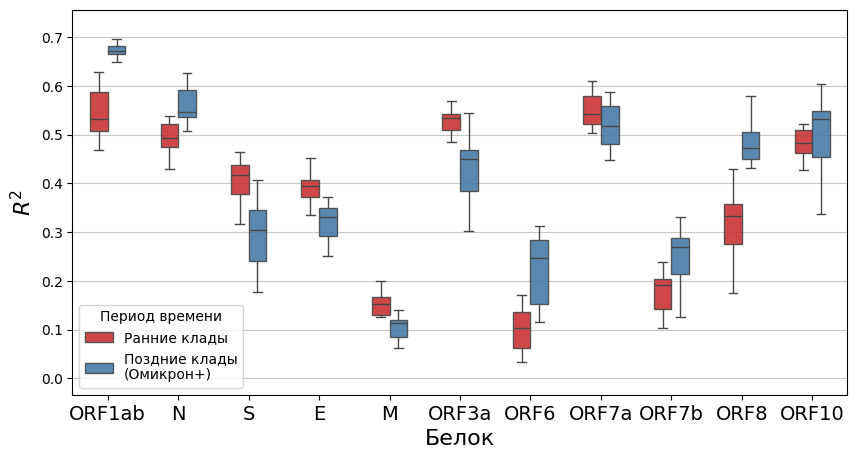

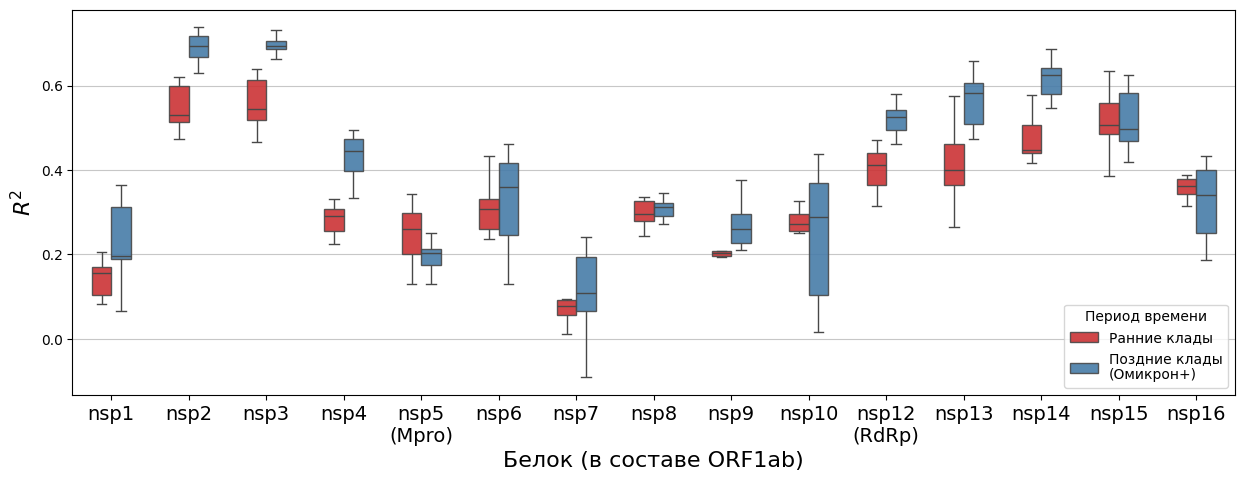

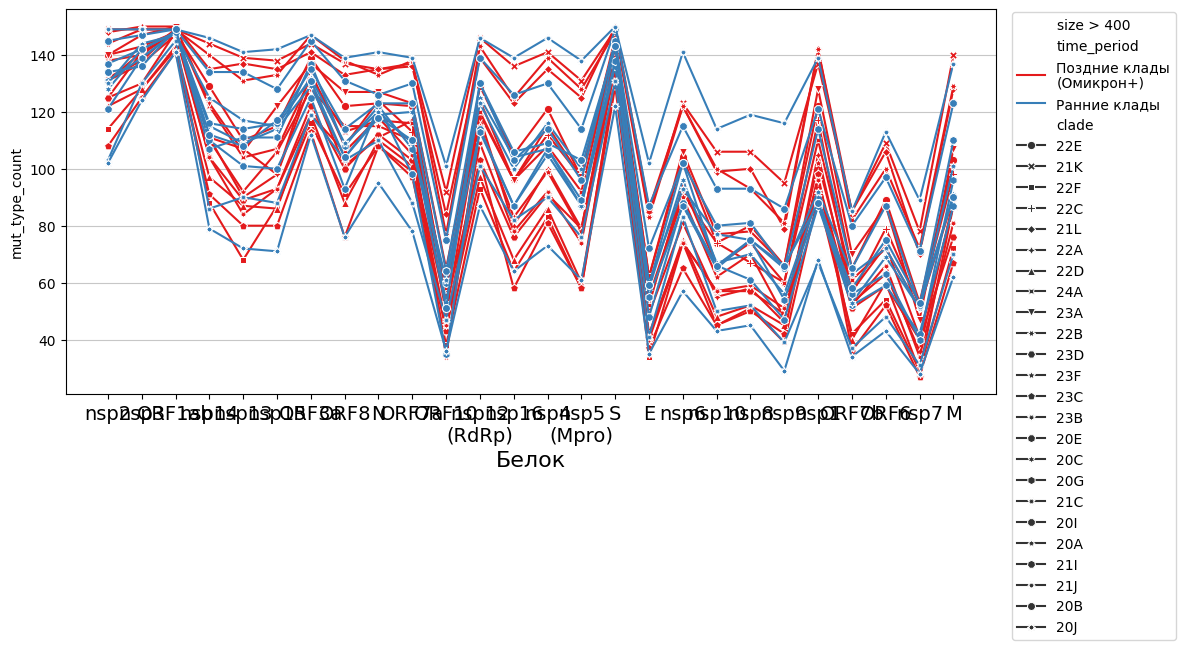

In [55]:
_ = metrics_data_tot.query('mut_count > 0').sort_values('r2', ascending=False)
_['protein'] = _['protein'].replace({'nsp12 (RdRp)': 'nsp12\n(RdRp)', 'nsp5 (Mpro)': 'nsp5\n(Mpro)',})
# print(_.protein.value_counts())
# _ = _[_['protein'].isin(_.protein.value_counts().index[:10])]
prot_order1 = [
    'ORF1ab', 'N', 'S', 'E', 'M', 'ORF3a', 'ORF6', 'ORF7a','ORF7b', 'ORF8', 'ORF10', 
]
prot_order2 = [
    'nsp1', 'nsp2', 'nsp3', 'nsp4', 'nsp5\n(Mpro)', 'nsp6', 'nsp7', 'nsp8', 'nsp9', 
    'nsp10', 'nsp12\n(RdRp)', 'nsp13', 'nsp14', 'nsp15', 'nsp16',
]

plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    _, x='protein', y='r2', hue='time_period', width=.5, fliersize=0,
    palette='Set1', legend=True, boxprops=dict(alpha=.9), 
    hue_order=['Ранние клады', 'Поздние клады\n(Омикрон+)'],
    order=prot_order1,
)
plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Белок', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.legend(title='Период времени')
plt.show()

plt.figure(figsize=(15, 5))
ax = sns.boxplot(
    _, x='protein', y='r2', hue='time_period', width=.5, fliersize=0,
    palette='Set1', legend=True, boxprops=dict(alpha=.9), 
    hue_order=['Ранние клады', 'Поздние клады\n(Омикрон+)'],
    order=prot_order2,
)
plt.ylabel('$R^2$', fontsize=16)
plt.xlabel('Белок (в составе ORF1ab)', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.legend(title='Период времени')
plt.show()

plt.figure(figsize=(12, 5))
ax = sns.lineplot(
    _, x='protein', y='mut_type_count', style='clade', hue='time_period', 
    markers=True, dashes=False, palette='Set1')
plt.legend(title='size > 400', bbox_to_anchor=(1.01, 1.01), loc='upper left')
plt.xlabel('Белок', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()

In [70]:
from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests

_early = 'Early clades'
_late = "Late clades\n(Omicron+)"

metrics_data_tot = pd.concat([metrics_data3, metrics_data2], ignore_index=True)


res_data = []
for gene in metrics_data_tot.protein.unique():
    data1 = metrics_data_tot.query('time_period == @_early & protein == @gene')['r2']
    data2 = metrics_data_tot.query('time_period == @_late & protein == @gene')['r2']
    stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
    diff = data2.mean() - data1.mean()
    res_data.append({'protein': gene, 'statistic': stat, 'p_val': p, 'mean_diff': diff})

genes_dif_df = pd.DataFrame(res_data)
reject, pvals_corrected, _, _ = multipletests(genes_dif_df['p_val'], method='fdr_bh')
genes_dif_df['p_val_corrected'] = pvals_corrected
genes_dif_df['reject_null'] = reject
genes_dif_df.sort_values('p_val_corrected')

protein  statistic     p_val  mean_diff  p_val_corrected  reject_null
4         ORF1ab        0.0  0.000047   0.128195         0.000306         True
20          nsp4        0.0  0.000047   0.150526         0.000306         True
18          nsp2        0.0  0.000047   0.143343         0.000306         True
19          nsp3        0.0  0.000047   0.137135         0.000306         True
13  nsp12 (RdRp)        2.0  0.000077   0.118049         0.000402         True
9           ORF8        5.0  0.000159   0.165939         0.000689         True
15         nsp14        7.0  0.000253   0.136202         0.000938         True
2              N        9.0  0.000396   0.065179         0.001288         True
14         nsp13       11.0  0.000614   0.155881         0.001647         True
10             S      128.0  0.000760  -0.109068         0.001647         True
6           ORF6       12.0  0.000760   0.120142         0.001647         True
1              M      128.0  0.000760  -0.053870         0.001647         True
5          ORF3a      121.0  0.003107  -0.095757         0.006213         True
25          nsp9       22.0  0.005414   0.058895         0.010054         True
0              E      116.0  0.007717  -0.061259         0.012540         True
8          ORF7b       24.0  0.007717   0.071843         0.012540         True
11          nsp1       29.0  0.017719   0.084930         0.027100         True
21   nsp5 (Mpro)      107.0  0.032580  -0.071985         0.047060         True
3          ORF10       45.0  0.151409   0.032138         0.207191        False
23          nsp7       49.0  0.230001   0.034260         0.299001        False
7          ORF7a       90.0  0.253536  -0.037152         0.313902        False
24          nsp8       57.0  0.464214   0.030144         0.548617        False
22          nsp6       58.0  0.500711   0.022854         0.566021        False
17         nsp16       81.0  0.538676  -0.035678         0.583565        False
16         nsp15       76.0  0.747417  -0.001372         0.777314        False
12         nsp10       70.0  1.000000  -0.030386         1.000000        False

In [71]:
# proteins with significantly lower R2 in late clades
genes_dif_df.query('reject_null == True & mean_diff < 0')

protein  statistic     p_val  mean_diff  p_val_corrected  reject_null
0             E      116.0  0.007717  -0.061259         0.012540         True
1             M      128.0  0.000760  -0.053870         0.001647         True
5         ORF3a      121.0  0.003107  -0.095757         0.006213         True
10            S      128.0  0.000760  -0.109068         0.001647         True
21  nsp5 (Mpro)      107.0  0.032580  -0.071985         0.047060         True

#### Mut distribution in clades

In [72]:
site_mut_counts = aamut_fitness.groupby(['gene', 'clade', 'aa_mutation'])['actual_count'].sum()
site_mut_counts

gene  clade  aa_mutation
E     20A    A22A            2
             A22D            0
             A22G            0
             A22P            0
             A22S            0
                            ..
nsp9  24A    Y89F            0
             Y89H            0
             Y89N            0
             Y89S            0
             Y89Y           10
Name: actual_count, Length: 2893370, dtype: int64

In [73]:
_clades = ['19A', '20A', '20B', '20C', '20E', '20F', '20G', '20I', '20J', '21C',
       '21I', '21J', '21K', '21L', '22A', '22B', '22C', '22D', '22E', '22F',
       '23A', '23B', '23C', '23D', '23E', '23F', '24A', '24B', '24C', '24E']
_lbls = ['Early'] * 12 + ['Late'] * 18
_clade2label_v2 = dict(zip(_clades, _lbls))

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from skbio.stats.distance import permanova, permdisp
from skbio.stats.distance import DistanceMatrix
from scipy.spatial.distance import pdist, squareform


def compare_mut_distributions_in_clades(X, y):
    # --- 2. STATISTICAL TEST (PERMANOVA) ---
    # Question: Are the two groups statistically different overall?
    # We calculate a distance matrix (Euclidean or Bray-Curtis) between clades
    dist_matrix = pdist(X, metric='braycurtis')
    dm = DistanceMatrix(squareform(dist_matrix), ids=X.index)

    # Run PERMANOVA (999 permutations)
    permanova_res = permanova(dm, grouping=y, permutations=999)

    permdisp_res = permdisp(dm, grouping=y, permutations=999)

    # --- 3. IDENTIFY SPECIFIC DRIVERS (Mann-Whitney U) ---
    # Question: Which specific mutations are different?
    results = []

    # Loop through every mutation
    for col in X.columns:
        group_early = X.loc[y == 'Early', col]
        group_late = X.loc[y == 'Late', col]
        
        # Mann-Whitney U test (non-parametric, safer for counts)
        stat, p = mannwhitneyu(group_early, group_late, alternative='two-sided')
        
        # Calculate Mean Difference (Late - Early) to see direction
        diff = group_late.mean() - group_early.mean()
        
        results.append({'Mutation': col, 'stat': stat, 'p_val': p, 'diff': diff})

    res_df = pd.DataFrame(results)

    # Correct for Multiple Testing (FDR Benjamini-Hochberg)
    # This is crucial because we tested 500 mutations!
    reject, pvals_corrected, _, _ = multipletests(res_df['p_val'], method='fdr_bh')
    res_df['p_adj'] = pvals_corrected
    res_df['Significant'] = reject

    # Filter for significant drivers
    drivers = res_df[res_df['Significant'] == True].sort_values('p_adj')

    return permanova_res, permdisp_res, drivers, res_df

In [75]:
clades_mut_cnt = aamut_fitness.groupby(['clade'])['actual_count'].sum().sort_values()
used_clades = clades_mut_cnt[clades_mut_cnt.between(10000, 10000000)].index
used_clades

Index(['20J', '23C', '22F', '22D', '21C', '23D', '23B', '20E', '22A', '23F',
       '20G', '20B', '20C', '20A', '22C', '24A', '21I', '23A', '22E', '20I',
       '21L', '22B', '21K', '21J'],
      dtype='object', name='clade')

In [76]:
def prepare_dataset(df):
    df_normalized = df.div(df.sum(axis=1), axis=0)
    df_normalized['Group'] = df_normalized.index.map(_clade2label_v2)

    X = df_normalized.drop('Group', axis=1)
    y = df_normalized['Group']
    return X, y

In [77]:
# 2 min

perm_stats = []
data_drivers = []
for cur_gene in site_mut_counts.index.levels[0]:
    print(cur_gene)

    df = site_mut_counts.loc[cur_gene].unstack().fillna(0).loc[used_clades]
    X, y = prepare_dataset(df)

    permanova_res, permdisp_res, drivers, _ = compare_mut_distributions_in_clades(X, y)
    perm_stats.append({'gene': cur_gene, 
                       'permanova_pval': permanova_res['p-value'], 
                       'permdisp_pval':  permdisp_res['p-value']})

    # print(f"Pseudo-F statistic: {permanova_res['test statistic']:.4f}")
    # print(f"PERMANOVA p-value: {permanova_res['p-value']:.4f}")

    # print(f"PERMDISP p-value: {permdisp_res['p-value']:.4f}")

    # if permanova_res['p-value'] < 0.05:
    #     print("CONCLUSION: Significant difference in mutation profiles between Early and Late clades.")
    # else:
    #     print("CONCLUSION: No significant difference found.")

    # print(f"\nFound {len(drivers)} significant driver mutations (FDR < 0.05).")
    # print(drivers.head(5))
    print("\n")

    data_drivers.append(drivers.assign(gene=cur_gene))

perm_stats_df = pd.DataFrame(perm_stats)

E


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




M


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




N


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




ORF10


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




ORF1ab


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




ORF3a


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




ORF6


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




ORF7a


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




ORF7b


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




ORF8


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




ORF9b


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




S


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp1


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp10


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp12 (RdRp)


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp13


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp14


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp15


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp16


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp2


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp3


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp4


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp5 (Mpro)


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp6


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp7


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp8


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(




nsp9


/home/kpotoh/.virtualenvs/env_bio/lib/python3.12/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:157: RuntimeWarning: EIGH: since no value for dimensions is specified, PCoA for all dimensions will be computed, which may result in long computation time if the original distance matrix is large.
  warn(


In [79]:
from utils import grantham_long
grantham_long

aa1  aa2  grantham_distance
0    Ser  Arg              110.0
1    Ser  Leu              145.0
2    Arg  Leu              102.0
3    Ser  Pro               74.0
4    Arg  Pro              103.0
..   ...  ...                ...
375  Trp  Asn              174.0
376  Trp  Lys              110.0
377  Trp  Asp              181.0
378  Trp  Glu              152.0
379  Trp  Met               67.0

[380 rows x 3 columns]

In [80]:
df_drivers = pd.concat(data_drivers, ignore_index=True)
df_drivers['nonsyn'] = df_drivers.Mutation.apply(lambda x: x[0] != x[-1])
df_drivers['increased'] = df_drivers['diff'] > 0
df_drivers['aa1'] = df_drivers['Mutation'].str[0].map(amino_acid_codes)
df_drivers['aa2'] = df_drivers['Mutation'].str[-1].map(amino_acid_codes)
df_drivers = df_drivers.merge(grantham_long, 'left').fillna(0)

exp_aa_sbs20A = prepare_exp_aa_subst(spectrum_20A)[0].rename(columns={'rate':'rate_early'})
exp_aa_sbs24A = prepare_exp_aa_subst(spectrum_24A)[0].rename(columns={'rate':'rate_late'})

df_drivers = df_drivers.merge(exp_aa_sbs20A, 'left').merge(exp_aa_sbs24A, 'left')

df_drivers.to_csv('data/early_late_drivers_data.csv', index=False)
df_drivers

Mutation   stat     p_val      diff     p_adj  Significant  gene  nonsyn  \
0        T9I  140.0  0.000006 -0.053898  0.002996         True     E    True   
1       L73F  140.0  0.000047 -0.031721  0.012768         True     E    True   
2       A32A    4.0  0.000125  0.022484  0.016994         True     E   False   
3       V49L  137.0  0.000098 -0.011124  0.016994         True     E    True   
4       V58F  134.0  0.000201 -0.019400  0.021752         True     E    True   
..       ...    ...       ...       ...       ...          ...   ...     ...   
933     L17F  128.0  0.000243 -0.002399  0.047507         True  nsp7    True   
934     S26F  133.0  0.000211 -0.015711  0.047507         True  nsp7    True   
935     I65I  137.0  0.000063 -0.037265  0.020869         True  nsp9   False   
936     K36N  138.0  0.000077 -0.007941  0.020869         True  nsp9    True   
937    M101I  138.0  0.000075 -0.006633  0.020869         True  nsp9    True   

     increased  aa1  aa2  grantham_distance  rate_early  rate_late  
0        False  Thr  Ile               89.0    1.245879   1.463865  
1        False  Leu  Phe               22.0    1.190253   1.188066  
2         True  Ala  Ala                0.0    1.000000   1.000000  
3        False  Val  Leu               32.0    0.706215   0.402192  
4        False  Val  Phe               50.0    0.644149   0.342694  
..         ...  ...  ...                ...         ...        ...  
933      False  Leu  Phe               22.0    1.190253   1.188066  
934      False  Ser  Phe              155.0    0.830586   0.975910  
935      False  Ile  Ile                0.0    0.507478   0.619862  
936      False  Lys  Asn               94.0    0.359667   0.212156  
937      False  Met  Ile               10.0    0.434901   0.314103  

[938 rows x 14 columns]

<Axes: >

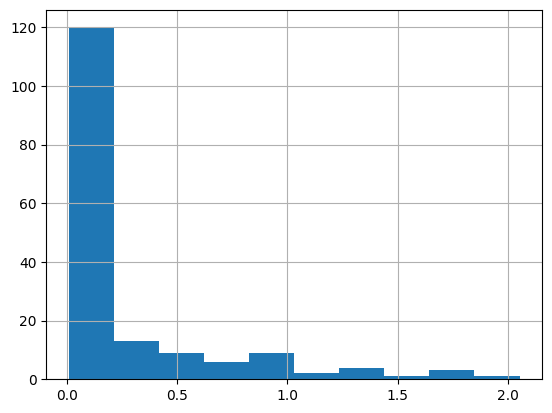

In [64]:
exp_aa_sbs20A.rate_early.hist()

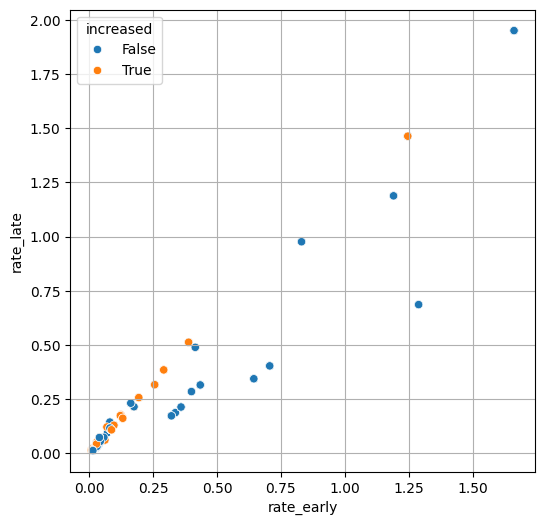

In [61]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_drivers.query('nonsyn'), x='rate_early', y='rate_late', hue='increased')
plt.grid()

<Axes: xlabel='grantham_distance', ylabel='gene'>

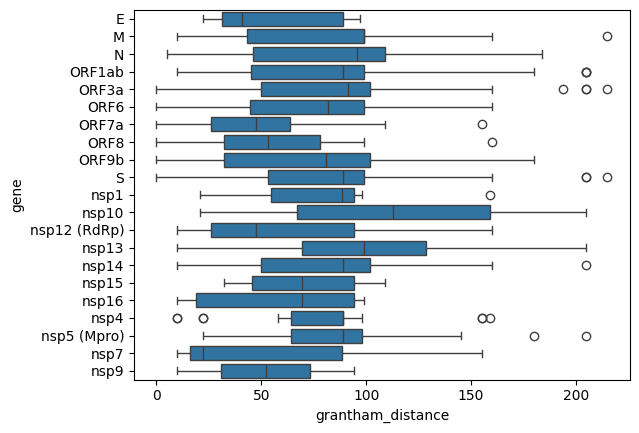

In [44]:
sns.boxplot(data=df_drivers.query('nonsyn'), y='gene', x='grantham_distance')

In [81]:
mut_dyn = df_drivers.query('nonsyn').groupby(['gene', 'increased']).Mutation.count().unstack()
mut_dyn['ratio'] = (mut_dyn[False] / mut_dyn[True]).fillna(100)
mut_dyn.sort_values('ratio')

increased     False  True       ratio
gene                                 
nsp1            4.0   8.0    0.500000
ORF6           13.0  11.0    1.181818
ORF9b          39.0  30.0    1.300000
ORF8            6.0   3.0    2.000000
N              68.0  28.0    2.428571
nsp14          15.0   6.0    2.500000
ORF3a          46.0  16.0    2.875000
S             122.0  35.0    3.485714
ORF7a          11.0   3.0    3.666667
E               7.0   1.0    7.000000
nsp5 (Mpro)    17.0   2.0    8.500000
ORF1ab        108.0  11.0    9.818182
M              16.0   1.0   16.000000
nsp12 (RdRp)   17.0   1.0   17.000000
nsp4           20.0   1.0   20.000000
nsp10           2.0   NaN  100.000000
nsp15           4.0   NaN  100.000000
nsp13          15.0   NaN  100.000000
nsp16           6.0   NaN  100.000000
nsp7            3.0   NaN  100.000000
nsp9            2.0   NaN  100.000000

In [82]:
muts_lst = df_drivers.query('nonsyn and ~increased')\
    .groupby('gene').Mutation.unique().rename('Mutations').reset_index()
muts_lst['Mutations'] = muts_lst['Mutations'].str.join(', ')
muts_lst

gene                                          Mutations
0              E            T9I, L73F, V49L, V58F, R69I, V75L, T30I
1              M  A63S, D209Y, Q19R, A98S, A63V, V23L, A81S, A14...
2              N  G30R, R32H, P13T, P13L, P13S, S413I, R32C, G30...
3         ORF1ab  A3070V, A3220V, A4835V, A5620S, A6914S, A5692S...
4          ORF3a  A110S, A23S, A72S, E241*, G224C, G100C, R6I, T...
5           ORF6  D61Y, R20S, W27L, V24F, R20K, E55*, E13D, D61H...
6          ORF7a  E121*, E16D, V104F, V24F, E22D, Q76H, G38V, V2...
7           ORF8               A65S, E106*, V32L, D35Y, W45L, I121L
8          ORF9b  A29T, P10L, M26T, P10S, M26I, E27*, A29V, N28S...
9              S  D796H, D796Y, G339S, N679K, V213L, S477N, S477...
10          nsp1                          H110Y, K120N, G112C, V86F
11         nsp10                                        M122V, F19C
12  nsp12 (RdRp)  A443V, D738Y, D893Y, E922D, E744D, L514F, Q822...
13         nsp13  A296S, A598S, S263F, R392C, R392L, M429I, F291...
14         nsp14  A119S, G248V, M169I, M49I, M72I, S418I, R213L,...
15         nsp15                          G129V, T112I, V127F, V66L
16         nsp16             A116S, E147D, K182N, K24N, M20I, M270I
17          nsp4  A457V, F322S, H313Y, M458I, T492I, T204I, L264...
18   nsp5 (Mpro)  P132L, P132S, S301L, V204A, R60C, V261F, P108L...
19          nsp7                                   M75I, L17F, S26F
20          nsp9                                        K36N, M101I

In [83]:
df_drivers_cnt = df_drivers.query('nonsyn and ~increased').groupby(['gene']).Mutation.size()\
    .rename('driver_mut_cnt').reset_index()

genes_sizes = {}
genes_sizes.update(aa_freqs_df.sum(1).to_dict())
genes_sizes.update(aa_freqs_df_orf1ab.sum(1).to_dict())

df_drivers_cnt['gene_size'] = df_drivers_cnt.gene.map(genes_sizes)

df_drivers_cnt['driver_mut_cnt_relative'] = df_drivers_cnt['driver_mut_cnt'] / df_drivers_cnt['gene_size']
df_drivers_cnt = df_drivers_cnt.merge(perm_stats_df).merge(muts_lst)
df_drivers_cnt.to_csv('./data/early_late_driver_mut_counts.csv')
df_drivers_cnt.sort_values('driver_mut_cnt_relative', ascending=False)

gene  driver_mut_cnt  gene_size  driver_mut_cnt_relative  \
5           ORF6              13       61.0                 0.213115   
4          ORF3a              46      275.0                 0.167273   
2              N              68      419.0                 0.162291   
9              S             122     1273.0                 0.095837   
0              E               7       75.0                 0.093333   
6          ORF7a              11      121.0                 0.090909   
1              M              16      222.0                 0.072072   
18   nsp5 (Mpro)              17      306.0                 0.055556   
7           ORF8               6      121.0                 0.049587   
3         ORF1ab             108     2695.0                 0.040074   
17          nsp4              20      500.0                 0.040000   
19          nsp7               3       83.0                 0.036145   
14         nsp14              15      527.0                 0.028463   
13         nsp13              15      601.0                 0.024958   
10          nsp1               4      180.0                 0.022222   
16         nsp16               6      298.0                 0.020134   
12  nsp12 (RdRp)              17      932.0                 0.018240   
20          nsp9               2      113.0                 0.017699   
11         nsp10               2      139.0                 0.014388   
15         nsp15               4      346.0                 0.011561   
8          ORF9b              39        NaN                      NaN   

    permanova_pval  permdisp_pval  \
5            0.001          0.011   
4            0.001          0.584   
2            0.001          0.402   
9            0.001          0.095   
0            0.001          0.013   
6            0.001          0.936   
1            0.001          0.293   
18           0.001          0.960   
7            0.001          0.885   
3            0.001          0.872   
17           0.001          0.641   
19           0.001          0.475   
14           0.001          0.764   
13           0.001          0.509   
10           0.001          0.943   
16           0.001          0.882   
12           0.001          0.716   
20           0.001          0.723   
11           0.001          0.751   
15           0.001          0.946   
8            0.001          0.493   

                                            Mutations  
5   D61Y, R20S, W27L, V24F, R20K, E55*, E13D, D61H...  
4   A110S, A23S, A72S, E241*, G224C, G100C, R6I, T...  
2   G30R, R32H, P13T, P13L, P13S, S413I, R32C, G30...  
9   D796H, D796Y, G339S, N679K, V213L, S477N, S477...  
0             T9I, L73F, V49L, V58F, R69I, V75L, T30I  
6   E121*, E16D, V104F, V24F, E22D, Q76H, G38V, V2...  
1   A63S, D209Y, Q19R, A98S, A63V, V23L, A81S, A14...  
18  P132L, P132S, S301L, V204A, R60C, V261F, P108L...  
7                A65S, E106*, V32L, D35Y, W45L, I121L  
3   A3070V, A3220V, A4835V, A5620S, A6914S, A5692S...  
17  A457V, F322S, H313Y, M458I, T492I, T204I, L264...  
19                                   M75I, L17F, S26F  
14  A119S, G248V, M169I, M49I, M72I, S418I, R213L,...  
13  A296S, A598S, S263F, R392C, R392L, M429I, F291...  
10                          H110Y, K120N, G112C, V86F  
16             A116S, E147D, K182N, K24N, M20I, M270I  
12  A443V, D738Y, D893Y, E922D, E744D, L514F, Q822...  
20                                        K36N, M101I  
11                                        M122V, F19C  
15                          G129V, T112I, V127F, V66L  
8   A29T, P10L, M26T, P10S, M26I, E27*, A29V, N28S...

In [87]:
y

clade
20J    Early
23C     Late
22F     Late
22D     Late
21C    Early
23D     Late
23B     Late
20E    Early
22A     Late
23F     Late
20G    Early
20B    Early
20C    Early
20A    Early
22C     Late
24A     Late
21I    Early
23A     Late
22E     Late
20I    Early
21L     Late
22B     Late
21K     Late
21J    Early
Name: Group, dtype: object

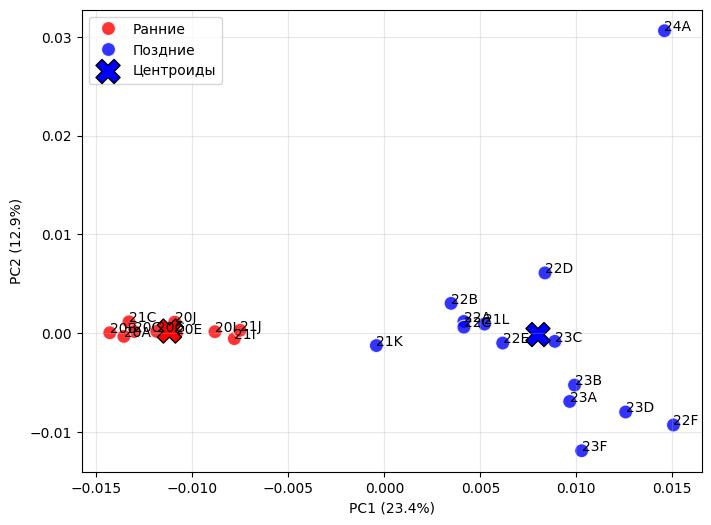

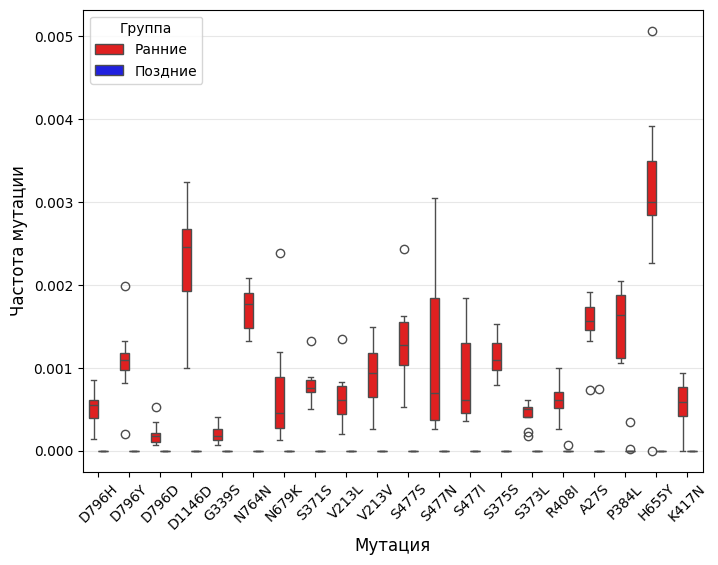

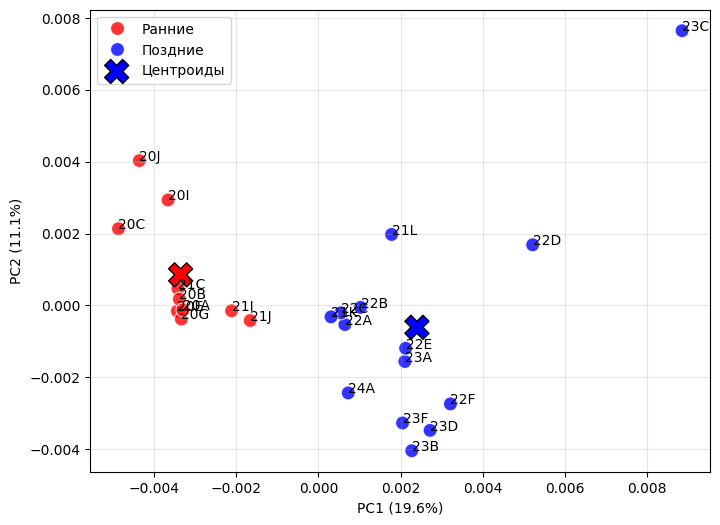

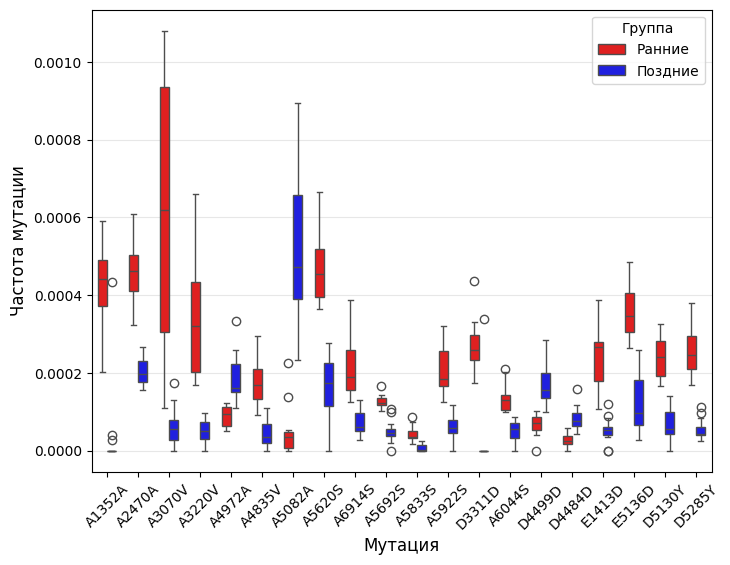

In [95]:
# cur_gene = 'ORF8'
for cur_gene in ['S', 'ORF1ab']:
    df = site_mut_counts.loc[cur_gene].unstack().fillna(0).loc[used_clades]
    X, y = prepare_dataset(df)
    y = y.map({'Early': 'Ранние', 'Late': 'Поздние'})

    pca = PCA(n_components=2)
    coords = pca.fit_transform(X)
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=y, 
                    palette={'Ранние': 'red', 'Поздние': 'blue'}, s=100, alpha=0.8)
    for i, cld in enumerate(y.values):
        plt.text(x=coords[i, 0], y=coords[i, 1], s=X.index[i])


    # Add centroids (optional, helps see the shift)
    centroids = pd.DataFrame(coords, columns=['PC1', 'PC2'])
    centroids['Group'] = y.values
    mean_pos = centroids.groupby('Group').mean()
    plt.scatter(mean_pos['PC1'], mean_pos['PC2'], s=300, marker='X', 
                c=['blue', 'red'], edgecolors='black', label='Центроиды')

    # plt.title(f"PCA: Mutation Distribution (Early vs Late) for Gene {cur_gene}")
    plt.xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({explained_variance[1]*100:.1f}%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- 5. VISUALIZE DRIVERS (Boxplot) ---
    # Plot the top 2 distinct mutations
    drivers = df_drivers.query('gene == @cur_gene')

    if not drivers.empty:
        top_muts = drivers.head(20)['Mutation'].tolist()
        
        # Melt for seaborn
        plot_data = X.assign(Group=y).melt(id_vars='Group', value_vars=top_muts, var_name='Mutation', value_name='Freq')
        
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=plot_data, x='Mutation', y='Freq', hue='Group', width=0.6,
                    palette={'Ранние': 'red', 'Поздние': 'blue'}, hue_order=['Ранние', 'Поздние'])
        # plt.title(f"Top Significant Drivers of Difference for Gene {cur_gene}")
        plt.grid(axis='y', alpha=0.3)
        plt.ylabel('Частота мутации', fontsize=12)
        plt.xlabel('Мутация', fontsize=12)
        plt.legend(title='Группа')
        plt.xticks(rotation=45)
        plt.show()

#### Mut site distribution in clades

In [13]:
site_mut_counts = aamut_fitness.groupby(['gene', 'clade', 'aa_site'])['actual_count'].sum()
site_mut_counts

gene  clade  aa_site
E     20A    1           0
             2           1
             3           2
             4          46
             5          10
                        ..
nsp9  24A    109        40
             110        10
             111         3
             112        51
             113         3
Name: actual_count, Length: 402017, dtype: int64

In [14]:
_clades = ['19A', '20A', '20B', '20C', '20E', '20F', '20G', '20I', '20J', '21C',
       '21I', '21J', '21K', '21L', '22A', '22B', '22C', '22D', '22E', '22F',
       '23A', '23B', '23C', '23D', '23E', '23F', '24A', '24B', '24C', '24E']
_lbls = ['Early'] * 12 + ['Late'] * 18
_clade2label_v2 = dict(zip(_clades, _lbls))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from skbio.stats.distance import permanova, permdisp
from skbio.stats.distance import DistanceMatrix
from scipy.spatial.distance import pdist, squareform


def compare_mut_distributions_in_clades(X, y):
    # --- 2. STATISTICAL TEST (PERMANOVA) ---
    # Question: Are the two groups statistically different overall?
    # We calculate a distance matrix (Euclidean or Bray-Curtis) between clades
    dist_matrix = pdist(X, metric='braycurtis')
    dm = DistanceMatrix(squareform(dist_matrix), ids=X.index)

    # Run PERMANOVA (999 permutations)
    permanova_res = permanova(dm, grouping=y, permutations=999)

    permdisp_res = permdisp(dm, grouping=y, permutations=999)

    # --- 3. IDENTIFY SPECIFIC DRIVERS (Mann-Whitney U) ---
    # Question: Which specific mutations are different?
    results = []

    # Loop through every mutation
    for col in X.columns:
        group_early = X.loc[y == 'Early', col]
        group_late = X.loc[y == 'Late', col]
        
        # Mann-Whitney U test (non-parametric, safer for counts)
        stat, p = mannwhitneyu(group_early, group_late, alternative='two-sided')
        
        # Calculate Mean Difference (Late - Early) to see direction
        diff = group_late.mean() - group_early.mean()
        
        results.append({'Site': col, 'stat': stat, 'p_val': p, 'diff': diff})

    res_df = pd.DataFrame(results)

    # Correct for Multiple Testing (FDR Benjamini-Hochberg)
    # This is crucial because we tested 500 mutations!
    reject, pvals_corrected, _, _ = multipletests(res_df['p_val'], method='fdr_bh')
    res_df['p_adj'] = pvals_corrected
    res_df['Significant'] = reject

    # Filter for significant drivers
    drivers = res_df[res_df['Significant'] == True].sort_values('p_adj')

    return permanova_res, permdisp_res, drivers, res_df

In [22]:
clades_mut_cnt = aamut_fitness.groupby(['clade'])['actual_count'].sum().sort_values()
used_clades = clades_mut_cnt.index
used_clades

Index(['20J', '23C', '22F', '22D', '21C', '23D', '23B', '20E', '22A', '23F',
       '20G', '20B', '20C', '20A', '22C', '24A', '21I', '23A', '22E', '20I',
       '21L', '22B', '21K', '21J'],
      dtype='object', name='clade')

In [23]:
def prepare_dataset(df):
    df_normalized = df.div(df.sum(axis=1), axis=0)
    df_normalized['Group'] = df_normalized.index.map(_clade2label_v2)

    X = df_normalized.drop('Group', axis=1)
    y = df_normalized['Group']
    return X, y

In [ ]:
# 2 min

perm_stats = []
data_drivers = []
for cur_gene in site_mut_counts.index.levels[0]:
    print(cur_gene)

    df = site_mut_counts.loc[cur_gene].unstack().fillna(0).loc[used_clades]
    X, y = prepare_dataset(df)

    permanova_res, permdisp_res, drivers, _ = compare_mut_distributions_in_clades(X, y)
    perm_stats.append({'gene': cur_gene, 
                       'permanova_pval': permanova_res['p-value'], 
                       'permdisp_pval':  permdisp_res['p-value']})

    # print(f"Pseudo-F statistic: {permanova_res['test statistic']:.4f}")
    # print(f"PERMANOVA p-value: {permanova_res['p-value']:.4f}")

    # print(f"PERMDISP p-value: {permdisp_res['p-value']:.4f}")

    # if permanova_res['p-value'] < 0.05:
    #     print("CONCLUSION: Significant difference in mutation profiles between Early and Late clades.")
    # else:
    #     print("CONCLUSION: No significant difference found.")

    # print(f"\nFound {len(drivers)} significant driver mutations (FDR < 0.05).")
    # print(drivers.head(5))
    print("\n")

    data_drivers.append(drivers.assign(gene=cur_gene))

perm_stats_df = pd.DataFrame(perm_stats)

In [30]:
df_drivers

Mutation   stat     p_val      diff     p_adj  Significant  gene  \
0            9  140.0  0.000047 -0.052243  0.001512         True     E   
1           49  139.0  0.000060 -0.014422  0.001512         True     E   
2           73  139.0  0.000060 -0.030264  0.001512         True     E   
3           32    3.0  0.000099  0.023437  0.001850         True     E   
4           17    4.0  0.000125  0.014326  0.001875         True     E   
...        ...    ...       ...       ...       ...          ...   ...   
1346        41  123.0  0.002111 -0.003780  0.041808         True  nsp8   
1347        65  137.0  0.000097 -0.038701  0.010995         True  nsp9   
1348       101  131.0  0.000396 -0.007115  0.022393         True  nsp9   
1349        16   16.0  0.001732  0.008303  0.048941         True  nsp9   
1350        66   15.0  0.001417  0.004647  0.048941         True  nsp9   

      increased  
0         False  
1         False  
2         False  
3          True  
4          True  
...         ...  
1346      False  
1347      False  
1348      False  
1349       True  
1350       True  

[1351 rows x 8 columns]

In [31]:
df_drivers = pd.concat(data_drivers, ignore_index=True)
# df_drivers['nonsyn'] = df_drivers.Mutation.apply(lambda x: x[0] != x[-1])
df_drivers['increased'] = df_drivers['diff'] > 0

# df_drivers.to_csv('data/early_late_drivers_data.csv', index=False)
df_drivers

Mutation   stat     p_val      diff     p_adj  Significant  gene  \
0            9  140.0  0.000047 -0.052243  0.001512         True     E   
1           49  139.0  0.000060 -0.014422  0.001512         True     E   
2           73  139.0  0.000060 -0.030264  0.001512         True     E   
3           32    3.0  0.000099  0.023437  0.001850         True     E   
4           17    4.0  0.000125  0.014326  0.001875         True     E   
...        ...    ...       ...       ...       ...          ...   ...   
1346        41  123.0  0.002111 -0.003780  0.041808         True  nsp8   
1347        65  137.0  0.000097 -0.038701  0.010995         True  nsp9   
1348       101  131.0  0.000396 -0.007115  0.022393         True  nsp9   
1349        16   16.0  0.001732  0.008303  0.048941         True  nsp9   
1350        66   15.0  0.001417  0.004647  0.048941         True  nsp9   

      increased  
0         False  
1         False  
2         False  
3          True  
4          True  
...         ...  
1346      False  
1347      False  
1348      False  
1349       True  
1350       True  

[1351 rows x 8 columns]

In [33]:
mut_dyn = df_drivers.groupby(['gene', 'increased']).Mutation.count().unstack()
mut_dyn['ratio'] = (mut_dyn[False] / mut_dyn[True]).fillna(100)
mut_dyn.sort_values('ratio')

increased     False   True       ratio
gene                                  
ORF8            1.0    3.0    0.333333
ORF6            4.0   10.0    0.400000
ORF9b          14.0   29.0    0.482759
N              40.0   63.0    0.634921
E               9.0   12.0    0.750000
nsp13          16.0   21.0    0.761905
ORF3a          33.0   42.0    0.785714
nsp4           23.0   27.0    0.851852
nsp15          13.0   15.0    0.866667
nsp9            2.0    2.0    1.000000
ORF10           1.0    1.0    1.000000
nsp5 (Mpro)    15.0   14.0    1.071429
ORF7a          12.0   11.0    1.090909
nsp14          32.0   28.0    1.142857
nsp1           15.0   13.0    1.153846
S              96.0   69.0    1.391304
nsp8            6.0    4.0    1.500000
ORF1ab        273.0  178.0    1.533708
nsp3           53.0   34.0    1.558824
nsp12 (RdRp)   22.0   13.0    1.692308
M              20.0   11.0    1.818182
nsp10           7.0    3.0    2.333333
nsp16          15.0    4.0    3.750000
nsp6           13.0    3.0    4.333333
ORF7b           1.0    NaN  100.000000
nsp2            4.0    NaN  100.000000
nsp7            1.0    NaN  100.000000

In [35]:
df_drivers_cnt = df_drivers.query('~increased').groupby(['gene']).Mutation.size()\
    .rename('driver_mut_cnt').reset_index()

genes_sizes = {}
genes_sizes.update(aa_freqs_df.sum(1).to_dict())
genes_sizes.update(aa_freqs_df_orf1ab.sum(1).to_dict())

df_drivers_cnt['gene_size'] = df_drivers_cnt.gene.map(genes_sizes)

df_drivers_cnt['driver_mut_cnt_relative'] = df_drivers_cnt['driver_mut_cnt'] / df_drivers_cnt['gene_size']
df_drivers_cnt = df_drivers_cnt.merge(perm_stats_df)
# df_drivers_cnt.to_csv('./data/early_late_driver_mut_counts.csv')
df_drivers_cnt.sort_values('driver_mut_cnt_relative', ascending=False)

gene  driver_mut_cnt  gene_size  driver_mut_cnt_relative  \
0              E               9       75.0                 0.120000   
5          ORF3a              33      275.0                 0.120000   
4         ORF1ab             273     2695.0                 0.101299   
7          ORF7a              12      121.0                 0.099174   
2              N              40      419.0                 0.095465   
1              M              20      222.0                 0.090090   
12          nsp1              15      180.0                 0.083333   
11             S              96     1273.0                 0.075412   
6           ORF6               4       61.0                 0.065574   
16         nsp14              32      527.0                 0.060721   
13         nsp10               7      139.0                 0.050360   
18         nsp16              15      298.0                 0.050336   
22   nsp5 (Mpro)              15      306.0                 0.049020   
21          nsp4              23      500.0                 0.046000   
23          nsp6              13      290.0                 0.044828   
17         nsp15              13      346.0                 0.037572   
25          nsp8               6      198.0                 0.030303   
20          nsp3              53     1945.0                 0.027249   
15         nsp13              16      601.0                 0.026622   
3          ORF10               1       38.0                 0.026316   
14  nsp12 (RdRp)              22      932.0                 0.023605   
8          ORF7b               1       43.0                 0.023256   
26          nsp9               2      113.0                 0.017699   
24          nsp7               1       83.0                 0.012048   
9           ORF8               1      121.0                 0.008264   
19          nsp2               4      638.0                 0.006270   
10         ORF9b              14        NaN                      NaN   

    permanova_pval  permdisp_pval  
0            0.001          0.011  
5            0.001          0.614  
4            0.001          0.857  
7            0.001          0.932  
2            0.001          0.202  
1            0.001          0.241  
12           0.001          0.896  
11           0.001          0.058  
6            0.001          0.069  
16           0.001          0.913  
13           0.001          0.468  
18           0.001          0.623  
22           0.001          0.949  
21           0.001          0.463  
23           0.001          0.537  
17           0.001          0.999  
25           0.001          0.585  
20           0.001          0.913  
15           0.001          0.362  
3            0.005          0.718  
14           0.001          0.641  
8            0.001          0.884  
26           0.001          0.437  
24           0.002          0.410  
9            0.001          0.216  
19           0.001          0.994  
10           0.001          0.586

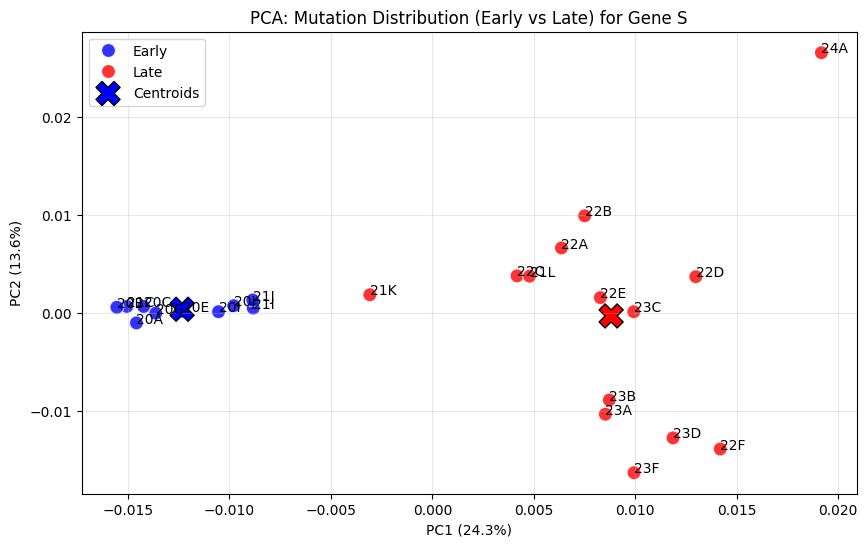

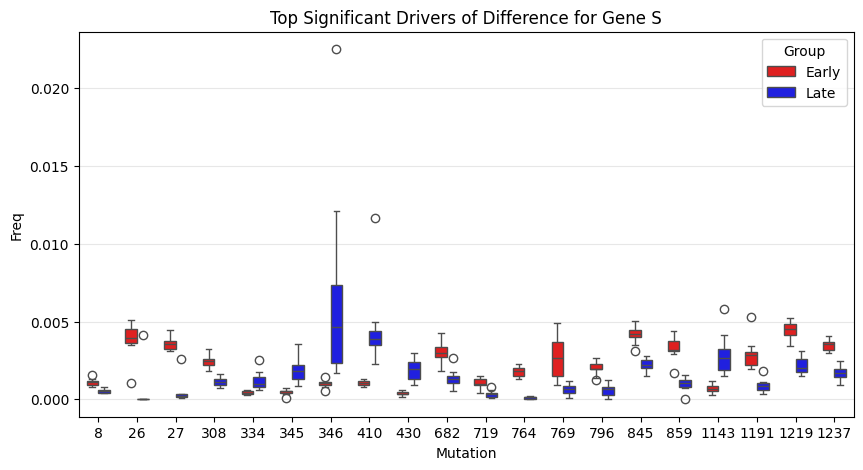

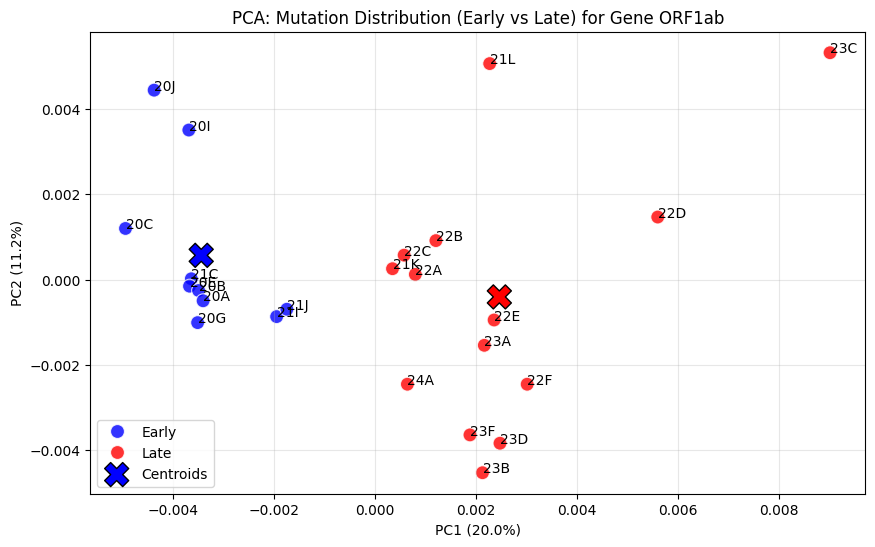

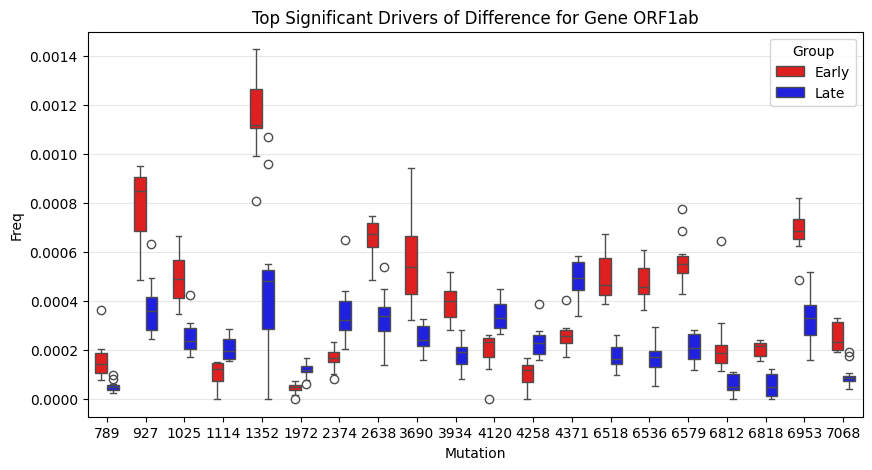

In [36]:
# cur_gene = 'ORF8'
for cur_gene in ['S', 'ORF1ab']:
    df = site_mut_counts.loc[cur_gene].unstack().fillna(0).loc[used_clades]
    X, y = prepare_dataset(df)

    pca = PCA(n_components=2)
    coords = pca.fit_transform(X)
    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=y, 
                    palette={'Early': 'blue', 'Late': 'red'}, s=100, alpha=0.8)
    for i, cld in enumerate(y.values):
        plt.text(x=coords[i, 0], y=coords[i, 1], s=X.index[i])


    # Add centroids (optional, helps see the shift)
    centroids = pd.DataFrame(coords, columns=['PC1', 'PC2'])
    centroids['Group'] = y.values
    mean_pos = centroids.groupby('Group').mean()
    plt.scatter(mean_pos['PC1'], mean_pos['PC2'], s=300, marker='X', 
                c=['blue', 'red'], edgecolors='black', label='Centroids')

    plt.title(f"PCA: Mutation Distribution (Early vs Late) for Gene {cur_gene}")
    plt.xlabel(f"PC1 ({explained_variance[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({explained_variance[1]*100:.1f}%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- 5. VISUALIZE DRIVERS (Boxplot) ---
    # Plot the top 2 distinct mutations
    drivers = df_drivers.query('gene == @cur_gene')

    if not drivers.empty:
        top_muts = drivers.head(20)['Mutation'].tolist()
        
        # Melt for seaborn
        plot_data = X.assign(Group=y).melt(id_vars='Group', value_vars=top_muts, var_name='Mutation', value_name='Freq')
        
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=plot_data, x='Mutation', y='Freq', hue='Group', width=0.6,
                    palette={'Early': 'red', 'Late': 'blue'}, hue_order=['Early', 'Late'])
        plt.title(f"Top Significant Drivers of Difference for Gene {cur_gene}")
        plt.grid(axis='y', alpha=0.3)
        plt.show()

In [10]:
# filter mutations list
_ = pd.read_csv('./data/early_late_driver_mut_counts.csv', index_col=0).query('gene != "ORF9b"').sort_values('driver_mut_cnt_relative', ascending=False)
_['Mutations_5'] = _.Mutations.str.split(', ').apply(lambda x: ', '.join([m for m in x if not '*' in m][:5]))
_.to_csv('./data/early_late_driver_mut_counts_filtered.csv', index=False)

### How many mutations required for unbiased result?

In [ ]:
# long (2 min)

sdata_full = []
for (cur_clade, ), obs_clade in obs.groupby(['clade']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    cur_exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    
    obs_clade = obs_clade[(obs_clade.aa1 != '*') & (obs_clade.aa2 != '*')]

    exploded = []
    for _, x in obs_clade[['aa1', 'aa2', 'count']].iterrows():
        for _ in range(x['count']):
            exploded.append(x)
    exploded = pd.DataFrame(exploded).reset_index(drop=True)
    exploded['count'] = 1

    sdata = []
    for n in np.logspace(2, np.log10(len(exploded)-10), 100).astype(int):
        cur_sample = exploded.sample(n, replace=False)
        _aa_subst = prepare_aa_subst(cur_sample, cur_exp_aa_subst, aa_freqs_total_dct)
        cur_met = calc_metrics(_aa_subst)
        cor_res = spearmanr(_aa_subst['nobs_freqs'], _aa_subst['nexp_freqs'])
        sdata.append([n, cur_met['pearson_corr'], cur_met['r2']])

    sdata = pd.DataFrame(sdata, columns=['n', 'cor', 'r2']).assign(clade=cur_clade)
    sdata_full.append(sdata)

sdata_full_df = pd.concat(sdata_full)
sdata_full_df

n       cor        r2 clade
0     100  0.542003  0.226880   20A
1     106  0.664179  0.401669   20A
2     113  0.571583  0.264192   20A
3     121  0.662687  0.405904   20A
4     129  0.604632  0.355105   20A
..    ...       ...       ...   ...
95  49966  0.826435  0.666484   24A
96  53344  0.825043  0.664777   24A
97  56950  0.823638  0.661844   24A
98  60800  0.823369  0.661938   24A
99  64909  0.823548  0.662486   24A

[2400 rows x 4 columns]

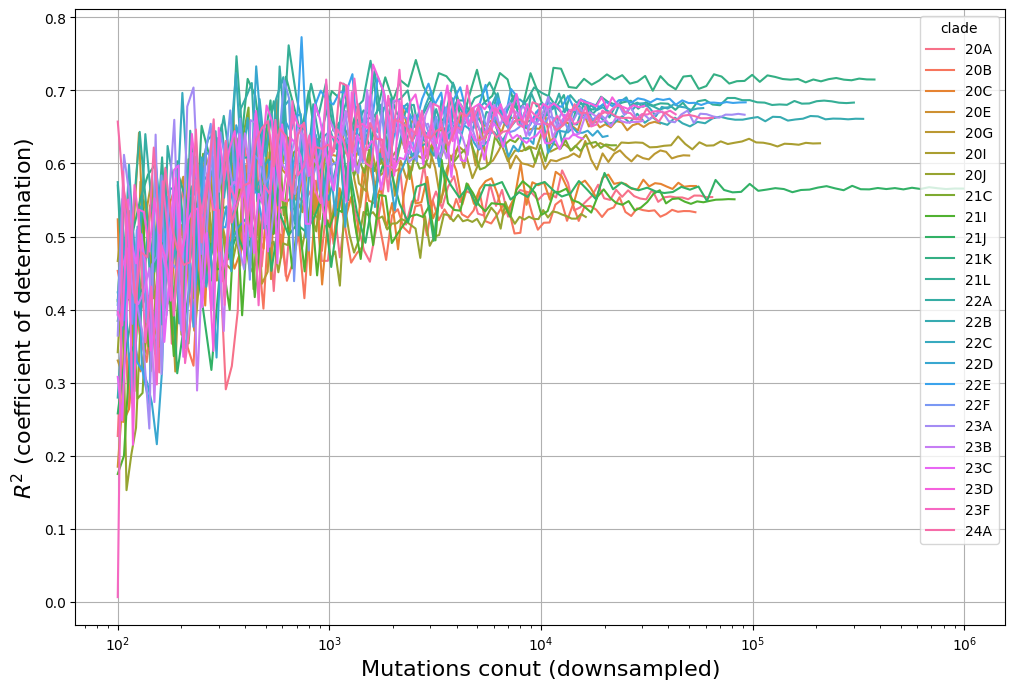

In [142]:
plt.figure(figsize=(12, 8))
sns.lineplot(sdata_full_df, x='n', y='r2', hue='clade')
# plt.hlines(0.63, 0, 10**6, 'k', '--')
plt.grid()
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Mutations conut (downsampled)', fontsize=16)
plt.xscale('log')

## Site rate categories

### Categorize sites by mutation rate

In [18]:
from typing import Union
from Bio.SeqRecord import SeqRecord

def read_genbank_ref(gb: Union[str, SeqRecord]):
    if isinstance(gb, str):
        genome = next(SeqIO.parse(gb, "genbank"))
    elif isinstance(gb, SeqRecord):
        genome = gb
    else:
        raise NotImplementedError

    ftypes = {"CDS", "rRNA", "tRNA"}
    full_nucls = set("ACGT")
    data = []
    df: pd.DataFrame = None
    gene_qualifier = None
    for ftr in genome.features:
        if ftr.type == "source":
            source = ftr.extract(genome)
            seq = str(source.seq)
            for pos, nuc in enumerate(seq):
                context = seq[pos - 1: pos + 2]
                if len(context) < 3 or len(set(context).difference(full_nucls)) != 0:
                    context = None
                if nuc not in full_nucls:
                    nuc = context = None
                data.append({"Pos": pos + 1, "Nuc": nuc, "Context": context})
            df = pd.DataFrame(data)
            df["Strand"] = 0
            continue
        elif gene_qualifier is None and ftr.type in ftypes:
            for qualifier in ["gene", "product", "protein_id"]:
                if qualifier in ftr.qualifiers:
                    gene_qualifier = qualifier
                    break
            if gene_qualifier is None:
                raise RuntimeError(f"Cannot find any expected qualifier of feature: {ftr}; with following qualifiers: {ftr.qualifiers}")

        for pos in list(ftr.location):
            df.at[pos, "Type"] = ftr.type
            df.at[pos, "Strand"] = ftr.location.strand
            if ftr.type in ftypes:
                df.at[pos, qualifier] = ftr.qualifiers[qualifier][0]

    # add codon features
    df["PosInGene"] = -1
    df["PosInCodon"] = -1
    for gene_name in df[(df.Type == "CDS") & (df.Strand == 1)][gene_qualifier].unique():
        gdf = df[df[gene_qualifier] == gene_name]
        seq = gdf.Nuc.values
        for pos_in_gene, pos in enumerate(gdf.index):
            pic = pos_in_gene % 3
            cdn = seq[pos_in_gene - pic: pos_in_gene - pic + 3]
            cdn = "".join(cdn) if len(set(cdn).difference(full_nucls)) == 0 else None
            df.at[pos, "Codon"] = cdn
            df.at[pos, "PosInGene"] = pos_in_gene + 1
            df.at[pos, "PosInCodon"] = pic + 1

    df["Strand"] = df["Strand"].astype(np.int8)
    df["PosInCodon"] = df["PosInCodon"].astype(np.int8)
    df["PosInGene"] = df["PosInGene"].astype(np.int32)
    return df


In [19]:
ref_sites_df = read_genbank_ref('data/NC_045512.2.gb')
ref_sites_df = ref_sites_df[ref_sites_df.Codon.notna()]
# Pos and nt_site is the same
ref_sites_df

Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
265      266   A     GAT       1  mat_peptide  ORF1ab          1           1   
266      267   T     ATG       1  mat_peptide  ORF1ab          2           2   
267      268   G     TGG       1  mat_peptide  ORF1ab          3           3   
268      269   G     GGA       1  mat_peptide  ORF1ab          4           1   
269      270   A     GAG       1  mat_peptide  ORF1ab          5           2   
...      ...  ..     ...     ...          ...     ...        ...         ...   
29669  29670   C     ACA       1          CDS   ORF10        113           2   
29670  29671   A     CAT       1          CDS   ORF10        114           3   
29671  29672   T     ATA       1          CDS   ORF10        115           1   
29672  29673   A     TAG       1          CDS   ORF10        116           2   
29673  29674   G     AGC       1          CDS   ORF10        117           3   

      Codon  
265     ATG  
266     ATG  
267     ATG  
268     GAG  
269     GAG  
...     ...  
29669   ACA  
29670   ACA  
29671   TAG  
29672   TAG  
29673   TAG  

[29260 rows x 9 columns]

In [20]:
_cnt1 = obs_raw.groupby(['clade', 'nt_site'])['count'].sum().rename('MutCountTotal').reset_index()
_cnt2 = obs.groupby(['clade', 'nt_site'])['count'].sum().rename('MutCountNonsyn').reset_index()
ref_sites_df_clades = ref_sites_df.rename(columns={'Pos':'nt_site'}).merge(_cnt1)
ref_sites_df_clades = ref_sites_df_clades.merge(_cnt2, 'left')
ref_sites_df_clades['MutCountNonsyn'].fillna(0, inplace=True)
ref_sites_df_clades = ref_sites_df_clades.merge(obs[['nt_site', 'codon_position']].drop_duplicates(), how='left')
ref_sites_df_clades['AA'] = ref_sites_df_clades['Codon'].apply(coda.translate_codon).map(amino_acid_codes)

data = []
for clade in obs_raw.clade.unique():
    cur_ref_sites_df = ref_sites_df_clades.query('clade == @clade').copy()
    categories, rates, alpha = categorize_site_rates_robust_plus_invariant(
        cur_ref_sites_df['MutCountNonsyn'], 6, 99, plot=False, verbose=False)
    cur_ref_sites_df['rate_cat_ns'] = categories
    data.append(cur_ref_sites_df)

ref_sites_df_clades_cat = pd.concat(data, axis=0)
ref_sites_df_clades_cat

nt_site Nuc Context  Strand         Type    gene  PosInGene  \
106         274   C     GCC       1  mat_peptide  ORF1ab          9   
188         278   G     TGT       1  mat_peptide  ORF1ab         13   
230         280   C     TCC       1  mat_peptide  ORF1ab         15   
280         282   C     CCT       1  mat_peptide  ORF1ab         17   
322         284   G     TGG       1  mat_peptide  ORF1ab         19   
...         ...  ..     ...     ...          ...     ...        ...   
480305    29667   T     CTC       1          CDS   ORF10        110   
480334    29668   C     TCA       1          CDS   ORF10        111   
480386    29670   C     ACA       1          CDS   ORF10        113   
480407    29671   A     CAT       1          CDS   ORF10        114   
480423    29672   T     ATA       1          CDS   ORF10        115   

        PosInCodon Codon clade  MutCountTotal  MutCountNonsyn codon_position  \
106              3   AGC   19A              2             0.0            3;3   
188              1   GTC   19A              1             1.0            1;1   
230              3   GTC   19A              1             0.0            NaN   
280              2   CCT   19A              1             1.0            2;2   
322              1   GGT   19A              2             2.0            1;1   
...            ...   ...   ...            ...             ...            ...   
480305           2   CTC   24E              1             1.0              2   
480334           3   CTC   24E              5             0.0            NaN   
480386           2   ACA   24E              3             3.0              2   
480407           3   ACA   24E              2             0.0              3   
480423           1   TAG   24E              2             0.0            NaN   

         AA  rate_cat_ns  
106     Ser            0  
188     Val            2  
230     Val            0  
280     Pro            2  
322     Gly            3  
...     ...          ...  
480305  Leu            1  
480334  Leu            0  
480386  Thr            4  
480407  Thr            0  
480423    *            0  

[480459 rows x 15 columns]

In [21]:
obs['aa_site'] = obs['aa_mutation'].apply(lambda x: int(x.split(';')[0][1:-1]))

ref_sites_df['MutCountTotal'] = ref_sites_df['Pos'].map(obs_raw.groupby('nt_site')['count'].sum()).fillna(0.)
ref_sites_df['MutCountNonsyn'] = ref_sites_df['Pos'].map(obs.groupby(['nt_site'])['count'].sum()).fillna(0.)

ref_sites_df = ref_sites_df.merge(obs[['nt_site', 'codon_position', 'aa_site']].drop_duplicates(), 
                   left_on='Pos', right_on='nt_site', how='left')


assert ref_sites_df.Codon.isna().sum() == 0

ref_sites_df['AA'] = ref_sites_df['Codon'].apply(coda.translate_codon).map(amino_acid_codes)

ref_sites_df

Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
0        266   A     GAT       1  mat_peptide  ORF1ab          1           1   
1        267   T     ATG       1  mat_peptide  ORF1ab          2           2   
2        268   G     TGG       1  mat_peptide  ORF1ab          3           3   
3        269   G     GGA       1  mat_peptide  ORF1ab          4           1   
4        270   A     GAG       1  mat_peptide  ORF1ab          5           2   
...      ...  ..     ...     ...          ...     ...        ...         ...   
29255  29670   C     ACA       1          CDS   ORF10        113           2   
29256  29671   A     CAT       1          CDS   ORF10        114           3   
29257  29672   T     ATA       1          CDS   ORF10        115           1   
29258  29673   A     TAG       1          CDS   ORF10        116           2   
29259  29674   G     AGC       1          CDS   ORF10        117           3   

      Codon  MutCountTotal  MutCountNonsyn  nt_site codon_position  aa_site  \
0       ATG            0.0             0.0      NaN            NaN      NaN   
1       ATG            2.0             2.0    267.0            2;2      1.0   
2       ATG            1.0             1.0    268.0            3;3      1.0   
3       GAG          239.0           239.0    269.0            1;1      2.0   
4       GAG          154.0           154.0    270.0            2;2      2.0   
...     ...            ...             ...      ...            ...      ...   
29255   ACA          687.0           687.0  29670.0              2     38.0   
29256   ACA          114.0             1.0  29671.0              3     38.0   
29257   TAG           57.0             0.0      NaN            NaN      NaN   
29258   TAG           29.0             0.0      NaN            NaN      NaN   
29259   TAG          177.0             0.0      NaN            NaN      NaN   

        AA  
0      Met  
1      Met  
2      Met  
3      Glu  
4      Glu  
...    ...  
29255  Thr  
29256  Thr  
29257    *  
29258    *  
29259    *  

[29260 rows x 15 columns]

In [22]:
ref_sites_df.MutCountTotal.sum(), obs_raw['count'].sum()

(np.float64(5611539.0), np.int64(5635999))

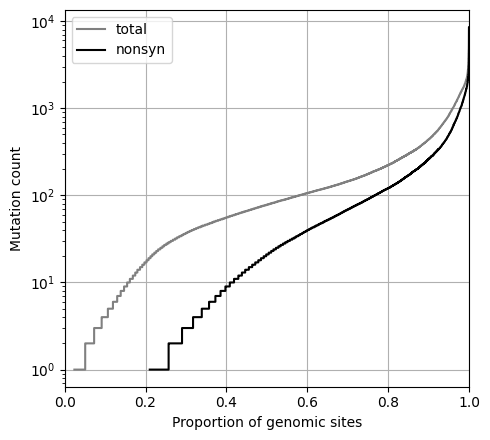

In [ ]:
plt.figure(figsize=(5, 4.5))
sns.ecdfplot(ref_sites_df, y='MutCountTotal', log_scale=(False, True), color='gray', label='total')
sns.ecdfplot(ref_sites_df, y='MutCountNonsyn', log_scale=(False, True), color='k', label='nonsyn')
plt.grid(True)
plt.ylabel('Mutation count')
plt.xlabel('Proportion of genomic sites')
plt.tight_layout()
plt.legend(loc='upper left')
# plt.savefig('./figures/mutational_count_per_site_ecdf.pdf', dpi=300)
plt.show()

Summary: 705 zero sites, 28269 gamma sites, 286 hotspots.


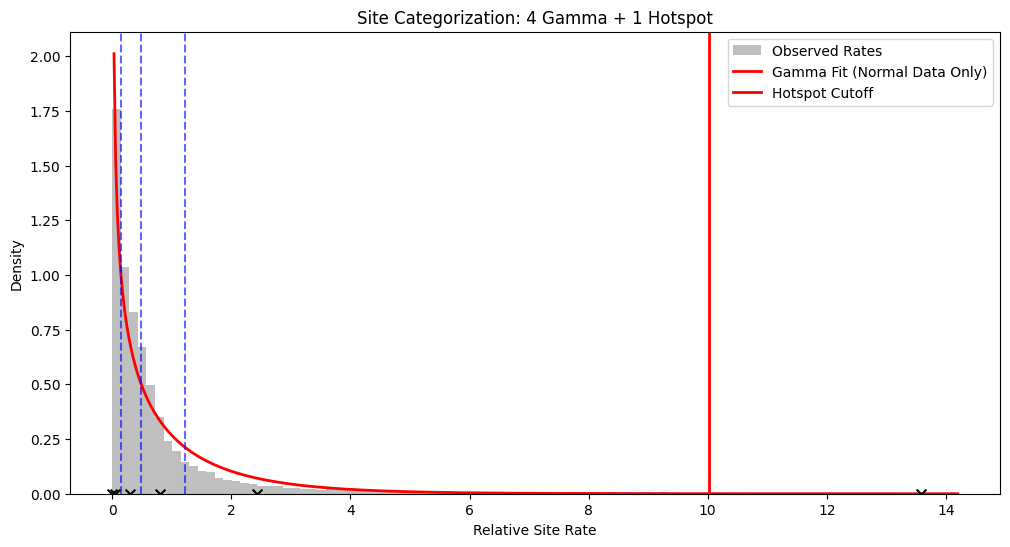

In [23]:
categories, rates, alpha = categorize_site_rates_robust_plus_invariant(
    ref_sites_df['MutCountTotal'], 6, 99, plot=True)

ref_sites_df['rate_cat'] = categories

Summary: 6159 zero sites, 22870 gamma sites, 231 hotspots.


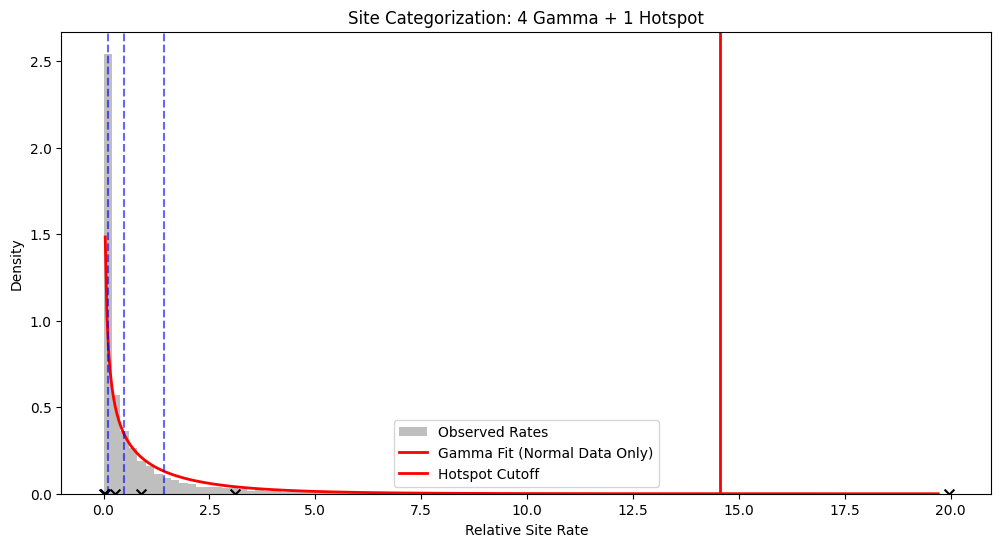

In [24]:
categories, rates, alpha = categorize_site_rates_robust_plus_invariant(
    ref_sites_df['MutCountNonsyn'], 6, 99, plot=True)

ref_sites_df['rate_cat_ns'] = categories

In [15]:
ref_sites_df.to_csv('./data/ref_annot.csv', index=False)

ref_sites_df[['Pos', 'MutCountTotal', 'MutCountNonsyn', 'rate_cat', 'rate_cat_ns']]\
    .to_csv('data/ref_sites_rates_cat5.csv', index=False, float_format='%g')

### Explore Cat-specific spectra

In [14]:
def get_syn_muts(row: pd.Series):
    syn_muts = []
    if row.PosInCodon == 2 or len(row.syn_codons) == 0:
        return []
    elif row.PosInCodon == 1 or row.PosInCodon == 3:
        pic = row.PosInCodon - 1
        for cdn in row.syn_codons:
            mut = f"{row.Codon[pic]}>{cdn[pic]}"
            syn_muts.append(mut)
    return syn_muts

In [26]:
ref_sites_df['fourfold'] = ref_sites_df.Codon.apply(coda.is_fourfold)
ref_sites_df['num_of_syn_codons'] = ref_sites_df.apply(lambda x: len(coda.get_syn_codons(x['Codon'], x['PosInCodon']-1)), axis=1)
ref_sites_df['syn_codons'] = ref_sites_df.apply(lambda x: (coda.get_syn_codons(x['Codon'], x['PosInCodon']-1)), axis=1)
ref_sites_df['syn_muts'] = ref_sites_df.apply(get_syn_muts, axis=1)
ref_sites_df.query('PosInCodon == 3 & fourfold & num_of_syn_codons < 3')

Empty DataFrame
Columns: [Pos, Nuc, Context, Strand, Type, gene, PosInGene, PosInCodon, Codon, MutCountTotal, MutCountNonsyn, nt_site, codon_position, aa_site, AA, rate_cat, rate_cat_ns, fourfold, num_of_syn_changes, num_of_syn_codons, syn_codons, syn_muts]
Index: []

[0 rows x 22 columns]

In [100]:
obs_syn = obs_raw.query('synonymous & four_fold_degenerate')
obs_annot = obs_syn.merge(ref_sites_df[['nt_site', 'rate_cat']])
# obs_annot = obs_annot.query('rate_cat >= 3')
obs_annot

protein    aa_mutation nt_mutation     codon_change  synonymous  \
0                S         V1264V     G25354C          GTG>GTC        True   
1     ORF1a;ORF1ab    S549S;S549S      C1912T  TCC>TCT;TCC>TCT        True   
2                S          S221S     G22225T          TCG>TCT        True   
3     ORF1a;ORF1ab    S216S;S216S       C913T  TCC>TCT;TCC>TCT        True   
4     ORF1a;ORF1ab  S2500S;S2500S      C7765T  TCC>TCT;TCC>TCT        True   
...            ...            ...         ...              ...         ...   
5440  ORF1a;ORF1ab  V1967V;V1967V      G6166A  GTG>GTA;GTG>GTA        True   
5441  ORF1a;ORF1ab    V228V;V228V       A949G  GTA>GTG;GTA>GTG        True   
5442  ORF1a;ORF1ab  V1415V;V1415V      G4510A  GTG>GTA;GTG>GTA        True   
5443  ORF1a;ORF1ab  T1543T;T1543T      A4894G  ACA>ACG;ACA>ACG        True   
5444  ORF1a;ORF1ab  T2836T;T2836T      A8773G  ACA>ACG;ACA>ACG        True   

      noncoding  nt_site reference_nt clade_founder_nt  exclude  ...  \
0         False    25354            G                G    False  ...   
1         False     1912            C                C    False  ...   
2         False    22225            G                G    False  ...   
3         False      913            C                C    False  ...   
4         False     7765            C                C    False  ...   
...         ...      ...          ...              ...      ...  ...   
5440      False     6166            G                G    False  ...   
5441      False      949            A                A    False  ...   
5442      False     4510            G                G    False  ...   
5443      False     4894            A                A    False  ...   
5444      False     8773            A                A    False  ...   

      count_non_terminal  mean_log_size  clade  subset    codon  \
0                      4       0.198628    19A     all      GTG   
1                      3       0.562040    19A     all  TCC;TCC   
2                      2       0.366204    19A     all      TCG   
3                      4       0.670892    19A     all  TCC;TCC   
4                      2       0.358352    19A     all  TCC;TCC   
...                  ...            ...    ...     ...      ...   
5440                   1       0.693147    24E     all  GTG;GTG   
5441                   1       1.098612    24E     all  GTA;GTA   
5442                   0       0.000000    24E     all  GTG;GTG   
5443                   0       0.000000    24E     all  ACA;ACA   
5444                   0       0.000000    24E     all  ACA;ACA   

     codon_position codon_site four_fold_degenerate  Mut  rate_cat  
0                 3       1264                 True  G>C         4  
1               3;3    549;549                 True  C>T         5  
2                 3        221                 True  G>T         5  
3               3;3    216;216                 True  C>T         4  
4               3;3  2500;2500                 True  C>T         5  
...             ...        ...                  ...  ...       ...  
5440            3;3  1967;1967                 True  G>A         4  
5441            3;3    228;228                 True  A>G         4  
5442            3;3  1415;1415                 True  G>A         4  
5443            3;3  1543;1543                 True  A>G         3  
5444            3;3  2836;2836                 True  A>G         3  

[5445 rows x 22 columns]

In [101]:
cat_obs = obs_annot.groupby(['clade', 'Mut'])['count'].sum().unstack()
cat_obs = cat_obs.div(cat_obs.sum(1), axis=0).fillna(0)
cat_obs.head()

Mut         A>C       A>G       A>T       C>A       C>G       C>T       G>A  \
clade                                                                         
19A    0.000000  0.032258  0.016129  0.016129  0.000000  0.306452  0.064516   
20A    0.002922  0.040175  0.010226  0.006574  0.046749  0.321402  0.073776   
20B    0.004325  0.041522  0.010381  0.005190  0.043253  0.352076  0.066609   
20C    0.008459  0.039474  0.012218  0.008459  0.001880  0.347744  0.081767   
20E    0.009259  0.048942  0.017196  0.010582  0.124339  0.350529  0.067460   

Mut         G>C       G>T       T>A       T>C       T>G  
clade                                                    
19A    0.137097  0.330645  0.016129  0.080645  0.000000  
20A    0.013148  0.372535  0.029218  0.071585  0.011687  
20B    0.006055  0.373702  0.019031  0.064014  0.013841  
20C    0.016917  0.369361  0.023496  0.075188  0.015038  
20E    0.007937  0.280423  0.022487  0.051587  0.009259

In [102]:
# SYN4f
nuc_cnt = ref_sites_df.query('PosInCodon == 3 & fourfold').syn_muts.explode().value_counts()

# SYN
# nuc_cnt = ref_sites_df.syn_muts.explode().value_counts()

nuc_cnt = nuc_cnt / nuc_cnt.sum() #* 3
nuc_cnt

syn_muts
T>G    0.149668
T>C    0.149668
T>A    0.149668
A>C    0.100049
A>G    0.100049
A>T    0.100049
C>G    0.045734
C>T    0.045734
C>A    0.045734
G>C    0.037882
G>A    0.037882
G>T    0.037882
Name: count, dtype: float64

In [103]:
cat_spectra = cat_obs / nuc_cnt
# cat_spectra = cat_spectra.div(cat_spectra.sum(1), axis=0)
cat_spectra.tail()

A>C       A>G       A>T       C>A       C>G       C>T       G>A  \
clade                                                                         
23F    0.036346  0.799612  0.314999  0.344547  0.053007  6.784927  3.551655   
24A    0.039105  0.664779  0.211165  0.290855  0.068437  7.596460  3.015670   
24B    0.000000  0.765179  0.334766  0.209239  0.104620  7.951086  3.031285   
24C    0.000000  0.764935  0.305974  0.446234  0.334676  7.585985  3.232339   
24E    0.122390  0.693541  0.122390  0.356988  0.089247  5.711801  3.232339   

            G>C       G>T       T>A       T>C       T>G  
clade                                                    
23F    0.511950  6.783341  0.170073  0.688392  0.113382  
24A    0.516382  6.919516  0.256175  0.648278  0.088877  
24B    0.126304  6.694087  0.287718  0.607404  0.031969  
24C    0.538723  5.925955  0.306801  0.545424  0.102267  
24E    0.754212  7.973103  0.272712  0.736323  0.136356

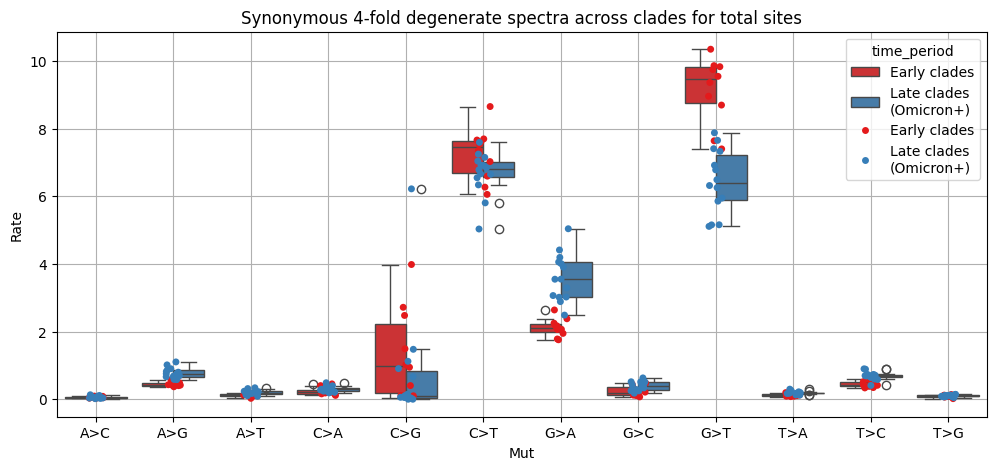

In [106]:
plt.figure(figsize=(12, 5))
_ = cat_spectra.melt(ignore_index=False, value_name='Rate', var_name='Mut').reset_index()
_['time_period'] = _.clade.map(_clade2label)
sns.boxplot(_, x='Mut', y='Rate', hue='time_period', palette='Set1')
sns.stripplot(_, x='Mut', y='Rate', hue='time_period', palette='Set1')
plt.title('Synonymous 4-fold degenerate spectra across clades for total sites')
plt.grid(True)

In [83]:
obs_annot

protein    aa_mutation nt_mutation     codon_change  synonymous  \
0                S         V1264V     G25354C          GTG>GTC        True   
1     ORF1a;ORF1ab    S549S;S549S      C1912T  TCC>TCT;TCC>TCT        True   
2                S          S221S     G22225T          TCG>TCT        True   
3     ORF1a;ORF1ab    S216S;S216S       C913T  TCC>TCT;TCC>TCT        True   
4     ORF1a;ORF1ab  S2500S;S2500S      C7765T  TCC>TCT;TCC>TCT        True   
...            ...            ...         ...              ...         ...   
5440  ORF1a;ORF1ab  V1967V;V1967V      G6166A  GTG>GTA;GTG>GTA        True   
5441  ORF1a;ORF1ab    V228V;V228V       A949G  GTA>GTG;GTA>GTG        True   
5442  ORF1a;ORF1ab  V1415V;V1415V      G4510A  GTG>GTA;GTG>GTA        True   
5443  ORF1a;ORF1ab  T1543T;T1543T      A4894G  ACA>ACG;ACA>ACG        True   
5444  ORF1a;ORF1ab  T2836T;T2836T      A8773G  ACA>ACG;ACA>ACG        True   

      noncoding  nt_site reference_nt clade_founder_nt  exclude  ...  \
0         False    25354            G                G    False  ...   
1         False     1912            C                C    False  ...   
2         False    22225            G                G    False  ...   
3         False      913            C                C    False  ...   
4         False     7765            C                C    False  ...   
...         ...      ...          ...              ...      ...  ...   
5440      False     6166            G                G    False  ...   
5441      False      949            A                A    False  ...   
5442      False     4510            G                G    False  ...   
5443      False     4894            A                A    False  ...   
5444      False     8773            A                A    False  ...   

      count_non_terminal  mean_log_size  clade  subset    codon  \
0                      4       0.198628    19A     all      GTG   
1                      3       0.562040    19A     all  TCC;TCC   
2                      2       0.366204    19A     all      TCG   
3                      4       0.670892    19A     all  TCC;TCC   
4                      2       0.358352    19A     all  TCC;TCC   
...                  ...            ...    ...     ...      ...   
5440                   1       0.693147    24E     all  GTG;GTG   
5441                   1       1.098612    24E     all  GTA;GTA   
5442                   0       0.000000    24E     all  GTG;GTG   
5443                   0       0.000000    24E     all  ACA;ACA   
5444                   0       0.000000    24E     all  ACA;ACA   

     codon_position codon_site four_fold_degenerate  Mut  rate_cat  
0                 3       1264                 True  G>C         4  
1               3;3    549;549                 True  C>T         5  
2                 3        221                 True  G>T         5  
3               3;3    216;216                 True  C>T         4  
4               3;3  2500;2500                 True  C>T         5  
...             ...        ...                  ...  ...       ...  
5440            3;3  1967;1967                 True  G>A         4  
5441            3;3    228;228                 True  A>G         4  
5442            3;3  1415;1415                 True  G>A         4  
5443            3;3  1543;1543                 True  A>G         3  
5444            3;3  2836;2836                 True  A>G         3  

[5445 rows x 22 columns]

In [107]:
cat_obs = obs_annot.groupby(['clade', 'rate_cat', 'Mut'])['count'].sum().unstack()
# cat_obs = cat_obs[cat_obs.sum(1) > 100]
cat_obs = cat_obs.div(cat_obs.sum(1), axis=0).fillna(0)
cat_obs

Mut                  A>C       A>G       A>T       C>A       C>G       C>T  \
clade rate_cat                                                               
19A   2         0.000000  0.000000  1.000000  0.000000  0.000000  0.000000   
      3         0.000000  0.250000  0.083333  0.000000  0.000000  0.083333   
      4         0.000000  0.013514  0.000000  0.013514  0.000000  0.229730   
      5         0.000000  0.000000  0.000000  0.027027  0.000000  0.540541   
20A   1         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
24C   5         0.000000  0.000000  0.000000  0.061538  0.046154  0.553846   
24E   2         0.000000  0.083333  0.083333  0.000000  0.000000  0.000000   
      3         0.024390  0.170732  0.048780  0.000000  0.024390  0.073171   
      4         0.017857  0.080357  0.000000  0.008929  0.000000  0.241071   
      5         0.000000  0.000000  0.000000  0.037500  0.000000  0.425000   

Mut                  G>A       G>C       G>T       T>A       T>C       T>G  
clade rate_cat                                                              
19A   2         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      3         0.000000  0.000000  0.000000  0.083333  0.500000  0.000000  
      4         0.067568  0.229730  0.378378  0.013514  0.054054  0.000000  
      5         0.081081  0.000000  0.351351  0.000000  0.000000  0.000000  
20A   1         0.000000  0.000000  0.000000  0.000000  1.000000  0.000000  
...                  ...       ...       ...       ...       ...       ...  
24C   5         0.107692  0.015385  0.215385  0.000000  0.000000  0.000000  
24E   2         0.000000  0.000000  0.000000  0.083333  0.583333  0.166667  
      3         0.024390  0.024390  0.073171  0.121951  0.390244  0.024390  
      4         0.187500  0.035714  0.357143  0.035714  0.026786  0.008929  
      5         0.100000  0.025000  0.387500  0.000000  0.012500  0.012500  

[130 rows x 12 columns]

In [108]:
# SYN4f
nuc_cnt = ref_sites_df.query('PosInCodon == 3 & fourfold').set_index('rate_cat')\
    .syn_muts.explode(ignore_index=False)\
        .dropna().reset_index().groupby(['rate_cat', 'syn_muts']).size().unstack()
# SYN
# nuc_cnt = ref_sites_df.set_index('rate_cat').syn_muts.explode(ignore_index=False)\
#     .dropna().reset_index().groupby(['rate_cat', 'syn_muts']).size().unstack()

nuc_cnt = nuc_cnt.div(nuc_cnt.sum(1), axis=0).fillna(0)
nuc_cnt

syn_muts       A>C       A>G       A>T       C>A       C>G       C>T  \
rate_cat                                                               
0         0.154762  0.154762  0.154762  0.011905  0.011905  0.011905   
1         0.118280  0.118280  0.118280  0.030824  0.030824  0.030824   
2         0.106072  0.106072  0.106072  0.007803  0.007803  0.007803   
3         0.121085  0.121085  0.121085  0.016129  0.016129  0.016129   
4         0.040998  0.040998  0.040998  0.165330  0.165330  0.165330   
5         0.000000  0.000000  0.000000  0.285714  0.285714  0.285714   

syn_muts       G>A       G>C       G>T       T>A       T>C       T>G  
rate_cat                                                              
0         0.047619  0.047619  0.047619  0.119048  0.119048  0.119048  
1         0.059498  0.059498  0.059498  0.124731  0.124731  0.124731  
2         0.016825  0.016825  0.016825  0.202634  0.202634  0.202634  
3         0.023609  0.023609  0.023609  0.172511  0.172511  0.172511  
4         0.089127  0.089127  0.089127  0.037879  0.037879  0.037879  
5         0.041667  0.041667  0.041667  0.005952  0.005952  0.005952

In [109]:
cat_spectra = cat_obs / nuc_cnt
# cat_spectra = cat_spectra.div(cat_spectra.sum(1), axis=0)
cat_spectra

Mut                  A>C       A>G       A>T       C>A       C>G       C>T  \
clade rate_cat                                                               
19A   2         0.000000  0.000000  9.427586  0.000000  0.000000  0.000000   
      3         0.000000  2.064672  0.688224  0.000000  0.000000  5.166667   
      4         0.000000  0.329612  0.000000  0.081737  0.000000  1.389524   
      5              NaN       NaN       NaN  0.094595  0.000000  1.891892   
20A   1         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
24C   5              NaN       NaN       NaN  0.215385  0.161538  1.938462   
24E   2         0.000000  0.785632  0.785632  0.000000  0.000000  0.000000   
      3         0.201431  1.410020  0.402863  0.000000  1.512195  4.536585   
      4         0.435559  1.960016  0.000000  0.054005  0.000000  1.458125   
      5              NaN       NaN       NaN  0.131250  0.000000  1.487500   

Mut                  G>A       G>C       G>T       T>A       T>C       T>G  
clade rate_cat                                                              
19A   2         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      3         0.000000  0.000000  0.000000  0.483062  2.898374  0.000000  
      4         0.758108  2.577568  4.245405  0.356757  1.427027  0.000000  
      5         1.945946  0.000000  8.432432  0.000000  0.000000  0.000000  
20A   1         0.000000  0.000000  0.000000  0.000000  8.017241  0.000000  
...                  ...       ...       ...       ...       ...       ...  
24C   5         2.584615  0.369231  5.169231  0.000000  0.000000  0.000000  
24E   2         0.000000  0.000000  0.000000  0.411252  2.878761  0.822503  
      3         1.033084  1.033084  3.099251  0.706920  2.262146  0.141384  
      4         2.103750  0.400714  4.007143  0.942857  0.707143  0.235714  
      5         2.400000  0.600000  9.300000  0.000000  2.100000  2.100000  

[130 rows x 12 columns]

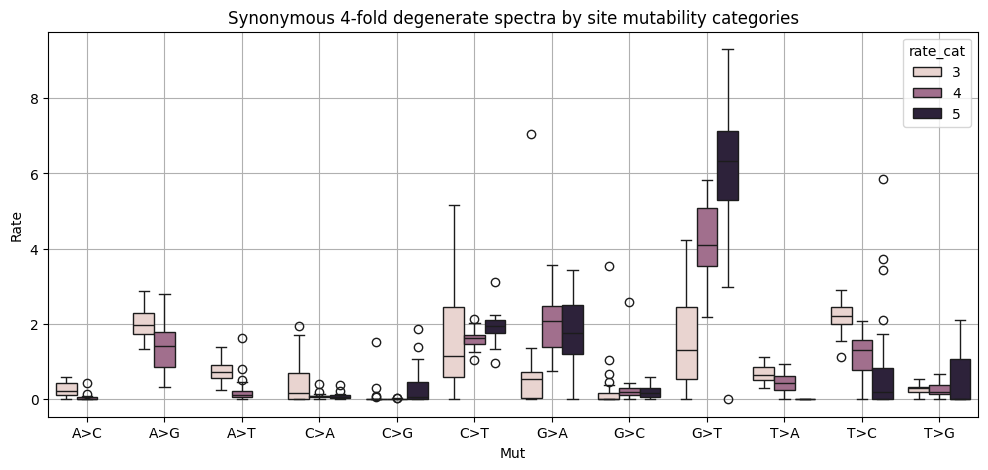

In [111]:
plt.figure(figsize=(12, 5))
_ = cat_spectra.melt(ignore_index=False, value_name='Rate').reset_index()
_['time_period'] = _.clade.map(_clade2label)
sns.boxplot(_.query('rate_cat >= 3 & rate_cat <= 5'), x='Mut', y='Rate', hue='rate_cat')
plt.title('Synonymous 4-fold degenerate spectra by site mutability categories')
plt.grid()

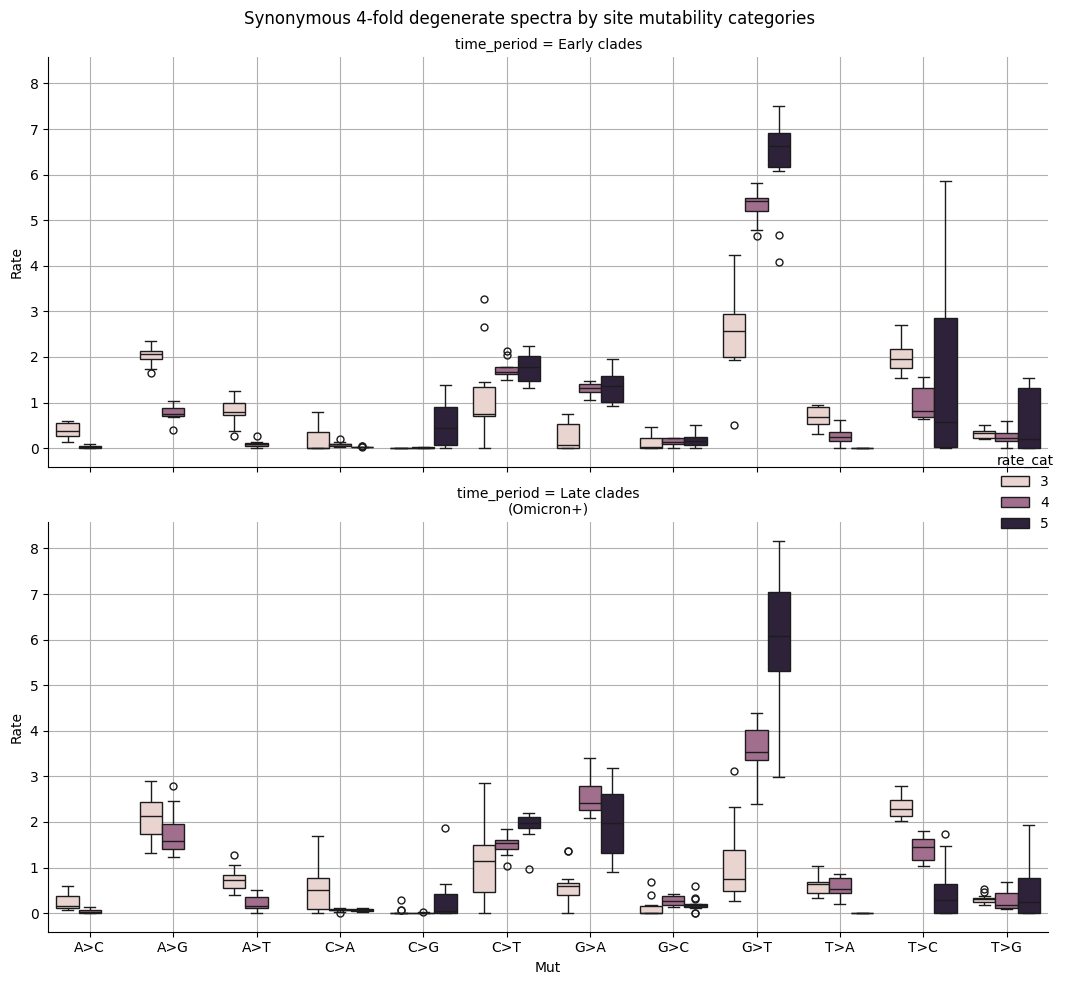

In [117]:
_ = cat_spectra.melt(ignore_index=False, value_name='Rate').reset_index()
_['time_period'] = _.clade.map(_clade2label)
g = sns.catplot(_.query('rate_cat >= 3 & rate_cat <= 5'), 
            x='Mut', y='Rate', hue='rate_cat', row='time_period',
            kind='box', aspect=2
)
g.fig.suptitle('Synonymous 4-fold degenerate spectra by site mutability categories')
for ax in g.axes.flat:
    ax.grid()
plt.tight_layout()

### Explore categories

In [42]:
site_different_cats = ref_sites_df_clades_cat.groupby(['nt_site', 'rate_cat_ns']).clade.unique().reset_index()
site_different_cats

nt_site  rate_cat_ns                                              clade
0          267            1                                         [21L, 22B]
1          268            1                                              [21L]
2          269            1                                    [20J, 21I, 24E]
3          269            2                               [20A, 20C, 20G, 23A]
4          269            3                [20B, 20E, 21J, 21K, 22A, 22D, 24B]
...        ...          ...                                                ...
68742    29671            0  [20B, 20C, 20E, 20G, 20I, 21I, 21J, 21L, 22A, ...
68743    29671            1                                              [21K]
68744    29672            0  [20A, 20C, 21I, 21J, 21K, 21L, 22A, 22B, 22D, ...
68745    29673            0  [20A, 20I, 20J, 21J, 21K, 22A, 22B, 22C, 22E, ...
68746    29674            0  [19A, 20A, 20B, 20C, 20E, 20G, 20I, 21C, 21I, ...

[68747 rows x 3 columns]

In [44]:
# there is a lot of rate cat imbalabces

_s =site_different_cats.nt_site.value_counts()
_s[_s>1]

site_different_cats[site_different_cats.nt_site.isin(_s[_s==6].index)].head(30)

nt_site  rate_cat_ns                                              clade
790        526            0                                              [23E]
791        526            1                                         [22D, 23C]
792        526            2                               [19A, 21C, 22F, 24C]
793        526            3                               [20J, 23B, 23D, 24E]
794        526            4  [20A, 20B, 20C, 20E, 20G, 20I, 21I, 21J, 21K, ...
795        526            5                                              [20F]
7501      3004            0                                              [24C]
7502      3004            1                                         [21C, 22D]
7503      3004            2                                         [23B, 24B]
7504      3004            3                               [19A, 20J, 23C, 23D]
7505      3004            4  [20A, 20B, 20C, 20E, 20G, 20I, 21I, 21J, 21K, ...
7506      3004            5                                              [20F]
11208     4396            0                     [20A, 20B, 20G, 21I, 21J, 21K]
11209     4396            1                                         [20E, 20I]
11210     4396            2                                         [22A, 24C]
11211     4396            3                                         [22C, 24B]
11212     4396            4           [21L, 22B, 22D, 22F, 23A, 23B, 23C, 23E]
11213     4396            5                               [22E, 23D, 23F, 24A]
13036     5164            0                               [19A, 20J, 22D, 23C]
13037     5164            1           [20A, 20C, 20E, 22A, 22C, 23D, 23F, 24A]
13038     5164            2                          [20B, 22B, 22E, 22F, 23A]
13039     5164            3           [20G, 20I, 21K, 21L, 23B, 24B, 24C, 24E]
13040     5164            4                                              [21J]
13041     5164            5                                              [21I]
22136     9053            0                                              [21J]
22137     9053            1                                    [20E, 22D, 23E]
22138     9053            2                          [20B, 20J, 22A, 24A, 24B]
22139     9053            3                [20C, 20G, 20I, 22E, 22F, 23B, 23D]
22140     9053            4           [19A, 20A, 21K, 21L, 22B, 22C, 23A, 23F]
22141     9053            5                                              [21I]

In [15]:
ref_sites_df.groupby('rate_cat')['MutCountTotal'].agg(['count', 'mean', 'std', 'min', 'max', 'sum']).round(2)

count     mean     std     min     max        sum
rate_cat                                                   
0           705     0.00    0.00     0.0     0.0        0.0
1          6501     9.50    7.64     1.0    26.0    61742.0
2          9047    57.11   18.67    27.0    92.0   516707.0
3          7467   145.15   38.98    93.0   234.0  1083867.0
4          5254   609.88  411.63   235.0  1921.0  3204302.0
5           286  2604.62  894.89  1925.0  8529.0   744921.0

In [32]:
ref_sites_df.groupby('rate_cat_ns')['MutCountNonsyn'].agg(['count', 'mean', 'std', 'min', 'max', 'sum']).round(2)

count     mean     std     min     max        sum
rate_cat_ns                                                   
0             6159     0.00    0.00     0.0     0.0        0.0
1             6410     4.43    3.09     1.0    11.0    28382.0
2             6613    29.35   12.08    12.0    53.0   194124.0
3             5322    93.39   28.04    54.0   154.0   497043.0
4             4523   431.64  319.47   155.0  1576.0  1952290.0
5              233  2161.03  856.50  1579.0  8529.0   503520.0

In [66]:
_ = ref_sites_df.groupby('rate_cat_ns')['MutCountNonsyn'].agg(['count','sum']).round(2)
_ / _.sum()

count       sum
rate_cat_ns                    
0            0.210492  0.000000
1            0.219070  0.008938
2            0.226008  0.061135
3            0.181887  0.156531
4            0.154580  0.614825
5            0.007963  0.158571

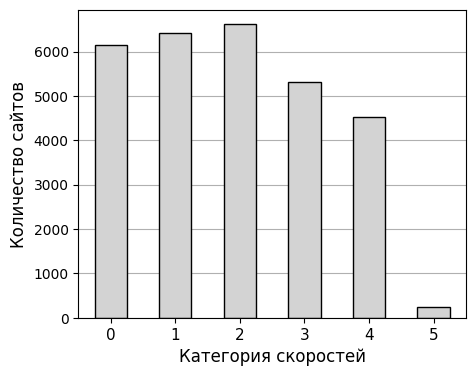

In [122]:
plt.figure(figsize=(5, 4))
ax = ref_sites_df.groupby('rate_cat_ns')['MutCountNonsyn'].agg('count').plot.bar(color='lightgray', edgecolor='k')
ax.set_xlabel('Категория скоростей', fontsize=12)
ax.set_ylabel('Количество сайтов', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=11)
ax.set_axisbelow(True)
ax.grid(axis='y')

/tmp/ipykernel_20867/3244588920.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ref_sites_df, x='rate_cat_ns', y='MutCountNonsyn', label='MutCountNonsyn', palette='grey')


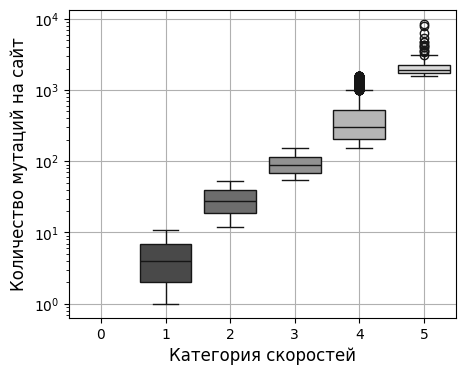

In [124]:
# sns.boxplot(ref_sites_df, x='rate_cat', y='MutCountTotal', label='MutCountTotal')
plt.figure(figsize=(5, 4))

sns.boxplot(ref_sites_df, x='rate_cat_ns', y='MutCountNonsyn', label='MutCountNonsyn', palette='grey')
plt.yscale('log')
plt.xlabel('Категория скоростей', fontsize=12)
plt.ylabel('Количество мутаций на сайт', fontsize=12)
# plt.legend()
plt.grid(True)

In [69]:
ref_sites_df.groupby('rate_cat').MutCountTotal.agg(['min', 'max',])

min     max
rate_cat                
0            0.0     0.0
1            1.0    26.0
2           27.0    92.0
3           93.0   234.0
4          235.0  1921.0
5         1925.0  8529.0

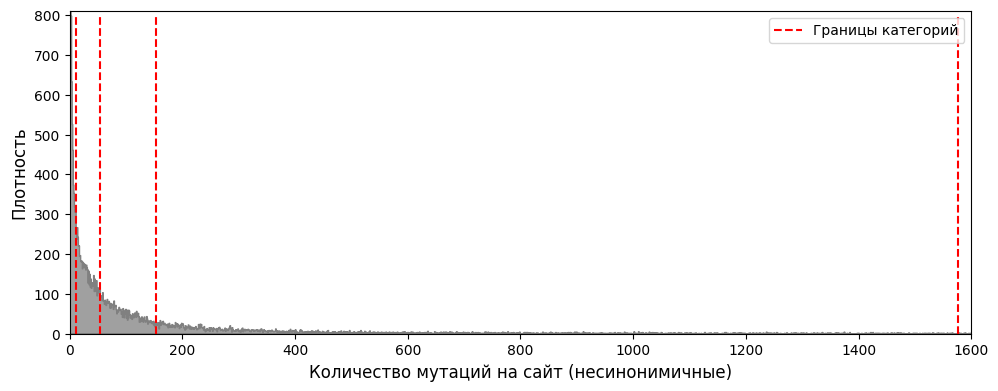

In [126]:
plt.figure(figsize=(10, 4))
sns.histplot(ref_sites_df, x='MutCountNonsyn', color='gray', element='step', discrete=True)
plt.vlines(ref_sites_df.groupby('rate_cat_ns').MutCountNonsyn.agg('max').iloc[1:-1].values, 
           ymin=0, ymax=800, color='red', linestyle='--', label='Границы категорий')

# plt.title("Mutation Count Total Distribution with Category Boundaries (Nonsyn)")
plt.ylabel('Плотность', fontsize=12)
plt.xlabel('Количество мутаций на сайт (несинонимичные)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.xlim(0, 1600)
plt.ylim(0, 810)
plt.show()

<Axes: xlabel='rate_cat_ns', ylabel='site_count'>

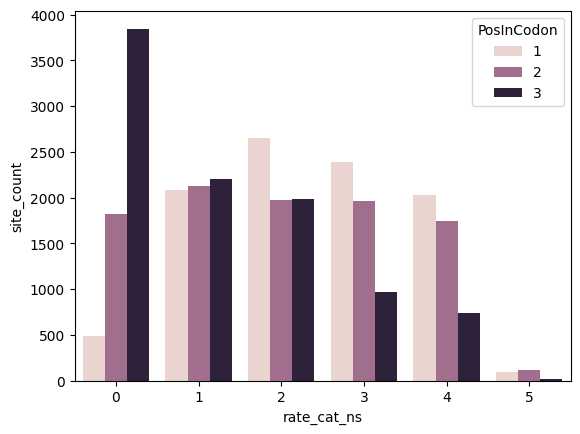

In [68]:
# 3rd pos in 0-cat is normal because 3rd pos usually have no missense sbs
_ = ref_sites_df.groupby('rate_cat_ns').PosInCodon.value_counts().rename('site_count').reset_index()
sns.barplot(_, x='rate_cat_ns', y='site_count', hue='PosInCodon')

<Axes: xlabel='rate_cat', ylabel='site_count'>

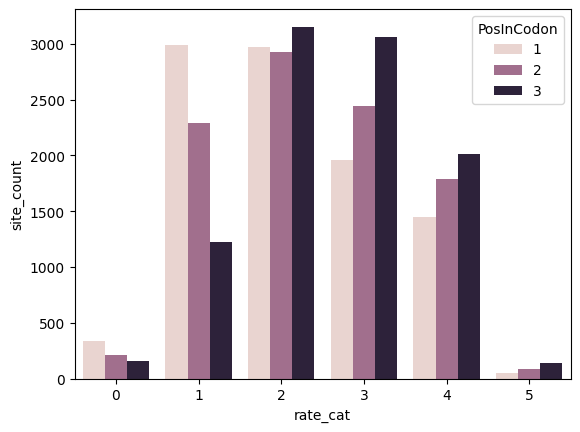

In [69]:
_ = ref_sites_df.groupby('rate_cat').PosInCodon.value_counts().rename('site_count').reset_index()
sns.barplot(_, x='rate_cat', y='site_count', hue='PosInCodon')

In [67]:
ref_sites_df[ref_sites_df.MutCountNonsyn == 0].PosInCodon.value_counts()

PosInCodon
3    3847
2    1826
1     486
Name: count, dtype: int64

In [13]:
cat_aa_content = ref_sites_df.groupby('rate_cat_ns').AA.value_counts().unstack()
cat_aa_content = cat_aa_content.div(cat_aa_content.sum(1), axis=0).fillna(0)
cat_aa_content

AA                  *       Ala       Arg       Asn       Asp       Cys  \
rate_cat_ns                                                               
0            0.022569  0.089300  0.033285  0.022082  0.011041  0.024355   
1            0.024961  0.018409  0.030733  0.056318  0.036973  0.054290   
2            0.022683  0.025556  0.021624  0.080145  0.049599  0.024044   
3            0.011086  0.050169  0.031003  0.068207  0.048666  0.019542   
4            0.008623  0.109220  0.047756  0.016140  0.049746  0.016140   
5            0.000000  0.107296  0.042918  0.004292  0.021459  0.000000   

AA                Gln       Glu       Gly       His  ...       Leu       Lys  \
rate_cat_ns                                          ...                       
0            0.029550  0.008605  0.078584  0.022731  ...  0.155869  0.016236   
1            0.038066  0.029953  0.043682  0.024961  ...  0.161466  0.054758   
2            0.046121  0.051868  0.028126  0.020414  ...  0.118706  0.092999   
3            0.046787  0.077039  0.037580  0.019542  ...  0.071402  0.077039   
4            0.038912  0.038249  0.061906  0.029184  ...  0.095070  0.032501   
5            0.072961  0.008584  0.030043  0.068670  ...  0.120172  0.012876   

AA                Met       Phe       Pro       Ser       Thr       Trp  \
rate_cat_ns                                                               
0            0.017048  0.021919  0.056990  0.079558  0.099204  0.005196   
1            0.026677  0.074103  0.017941  0.057098  0.037598  0.018409   
2            0.029790  0.068199  0.013610  0.061848  0.071375  0.008771   
3            0.051297  0.040962  0.019166  0.071026  0.063886  0.007704   
4            0.036922  0.013044  0.070086  0.074950  0.088658  0.011718   
5            0.008584  0.000000  0.115880  0.120172  0.214592  0.004292   

AA                Tyr       Val  
rate_cat_ns                      
0            0.049846  0.123559  
1            0.056162  0.056474  
2            0.043853  0.064419  
3            0.031567  0.072529  
4            0.017687  0.090206  
5            0.004292  0.025751  

[6 rows x 21 columns]

<Axes: xlabel='rate_cat_ns', ylabel='rate_cat_ns'>

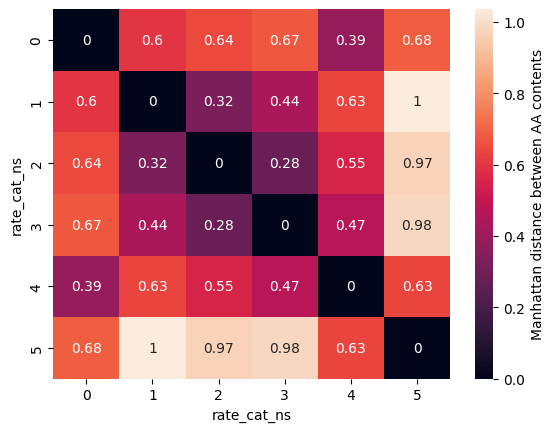

In [62]:
_ = pd.DataFrame(squareform(pdist(cat_aa_content, 'cityblock')), 
                 index=cat_aa_content.index, columns=cat_aa_content.index)
sns.heatmap(_, annot=True, cbar_kws={'label': 'Manhattan distance between AA contents'})

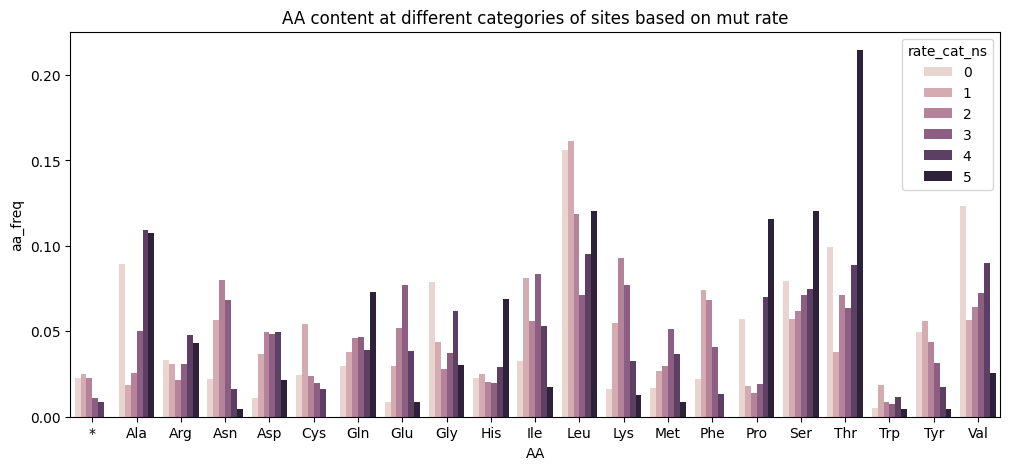

In [52]:
plt.figure(figsize=(12, 5))
_ = cat_aa_content.melt(ignore_index=False, value_name='aa_freq').reset_index()
sns.barplot(_, hue='rate_cat_ns', y='aa_freq', x='AA')
plt.title('AA content at different categories of sites based on mut rate');

In [75]:
obs

protein    aa_mutation nt_mutation     codon_change  nt_site  \
0              ORF1ab         P5401L     C16466T          CCA>CTA    16466   
1                   M           I82T     T26767C          ATC>ACC    26767   
3              ORF1ab         P4715L     C14408T          CCT>CTT    14408   
4              ORF1ab         A6319V     C19220T          GCT>GTT    19220   
5              ORF1ab         I5658V     A17236G          ATA>GTA    17236   
...               ...            ...         ...              ...      ...   
1553870  ORF1a;ORF1ab  V4369A;V4369A     T13371C  GTC>GCC;GTC>GCC    13371   
1553871  ORF1a;ORF1ab  V4350A;V4350A     T13314C  GTA>GCA;GTA>GCA    13314   
1553874  ORF1a;ORF1ab  V3763F;V3763F     G11552T  GTT>TTT;GTT>TTT    11552   
1553875  ORF1a;ORF1ab  V3759G;V3759G     T11541G  GTT>GGT;GTT>GGT    11541   
1553876  ORF1a;ORF1ab  V4102A;V4102A     T12570C  GTA>GCA;GTA>GCA    12570   

        reference_nt clade_founder_nt  exclude  count  count_terminal  ...  \
0                  C                C    False     70              37  ...   
1                  T                T    False     58              18  ...   
3                  C                C    False     52              26  ...   
4                  C                C    False     50              15  ...   
5                  A                A    False     48              24  ...   
...              ...              ...      ...    ...             ...  ...   
1553870            T                T    False      1               1  ...   
1553871            T                T    False      1               1  ...   
1553874            G                G    False      1               1  ...   
1553875            T                T    False      1               0  ...   
1553876            T                T    False      1               0  ...   

         mean_log_size  clade subset    codon codon_position codon_site  Mut  \
0             0.708825    19A    all      CCA              2       5401  C>T   
1             1.237886    19A    all      ATC              2         82  T>C   
3             0.678436    19A    all      CCT              2       4715  C>T   
4             1.097059    19A    all      GCT              2       6319  C>T   
5             0.581333    19A    all      ATA              1       5658  A>G   
...                ...    ...    ...      ...            ...        ...  ...   
1553870       0.000000    24E    all  GTC;GTC            2;2  4369;4369  T>C   
1553871       0.000000    24E    all  GTA;GTA            2;2  4350;4350  T>C   
1553874       0.000000    24E    all  GTT;GTT            1;1  3763;3763  G>T   
1553875       0.693147    24E    all  GTT;GTT            2;2  3759;3759  T>G   
1553876       1.098612    24E    all  GTA;GTA            2;2  4102;4102  T>C   

        aa1 aa2 aa_site  
0         P   L    5401  
1         I   T      82  
3         P   L    4715  
4         A   V    6319  
5         I   V    5658  
...      ..  ..     ...  
1553870   V   A    4369  
1553871   V   A    4350  
1553874   V   F    3763  
1553875   V   G    3759  
1553876   V   A    4102  

[440648 rows x 21 columns]

In [86]:
ref_sites_df[['gene', 'aa_site', 'rate_cat', 'rate_cat_ns']]

gene  aa_site  rate_cat  rate_cat_ns
0      ORF1ab      NaN         0            0
1      ORF1ab      1.0         1            1
2      ORF1ab      1.0         1            1
3      ORF1ab      2.0         4            4
4      ORF1ab      2.0         3            3
...       ...      ...       ...          ...
29255   ORF10     38.0         4            4
29256   ORF10     38.0         3            1
29257   ORF10      NaN         2            0
29258   ORF10      NaN         2            0
29259   ORF10      NaN         3            0

[29260 rows x 4 columns]

In [129]:
obs['gene'] = obs['protein'].replace('ORF1a;ORF1ab', 'ORF1ab')
obs['MutAA'] = obs['aa1'] + '>' + obs['aa2']

In [130]:
_sites_cat = ref_sites_df[['nt_site', 'rate_cat', 'rate_cat_ns']].dropna()
_sites_cat['nt_site'] = _sites_cat['nt_site'].astype(int)
_sites_cat

nt_site  rate_cat  rate_cat_ns
1          267         1            1
2          268         1            1
3          269         4            4
4          270         3            3
5          271         3            3
...        ...       ...          ...
29251    29666         4            5
29252    29667         3            3
29254    29669         3            3
29255    29670         4            4
29256    29671         3            1

[23101 rows x 3 columns]

In [131]:
cat_obs = obs[['clade', 'gene', 'nt_site', 'aa_site', 'aa_mutation', 'MutAA', 'count']]\
    .merge(ref_sites_df_clades_cat, on=['clade', 'gene', 'nt_site'])
print(cat_obs.shape)
cat_obs_mut_freqs = cat_obs.groupby(['rate_cat_ns', 'MutAA'])['count'].sum().unstack().fillna(0)
cat_obs_mut_freqs

(440648, 19)


MutAA        *>C   *>E   *>G  *>K   *>L    *>Q  *>R   *>S  *>W  *>Y  ...  \
rate_cat_ns                                                          ...   
1            2.0   1.0   0.0  0.0   0.0    0.0  1.0   0.0  1.0  6.0  ...   
2            3.0   1.0   0.0  3.0   3.0    1.0  8.0   0.0  2.0  2.0  ...   
3            6.0   2.0   1.0  2.0  12.0    5.0  3.0   4.0  3.0  4.0  ...   
4            4.0  62.0  12.0  6.0  39.0   38.0  1.0  10.0  9.0  3.0  ...   
5            0.0  55.0  12.0  2.0   1.0  105.0  0.0   0.0  0.0  0.0  ...   

MutAA           W>L     W>R    W>S    Y>*     Y>C    Y>D    Y>F     Y>H  \
rate_cat_ns                                                               
1             343.0   272.0   52.0  262.0  1621.0   43.0  693.0  2215.0   
2             598.0   370.0   53.0  299.0  3910.0   77.0  906.0  5117.0   
3             772.0  1231.0   64.0  112.0  5544.0  100.0  694.0  7011.0   
4            6048.0  1447.0  568.0   39.0  6230.0  538.0  572.0  8603.0   
5             231.0    13.0   23.0    0.0    55.0  300.0  230.0   765.0   

MutAA          Y>N    Y>S  
rate_cat_ns                
1            117.0   85.0  
2            263.0  183.0  
3            369.0  268.0  
4            506.0  279.0  
5             29.0   40.0  

[5 rows x 170 columns]

In [132]:
def calc_entropy(freqs: pd.Series):
    if len(freqs) == 1:
        return 0.0
    p = freqs / freqs.sum()
    p = p[p > 0]
    H = - (p * np.log2(p)).sum()
    return H

entropy = cat_obs.groupby(['clade', 'gene', 'rate_cat_ns', 'aa_site', 'MutAA'])['count'].sum()\
    .reset_index().groupby(['clade', 'gene', 'rate_cat_ns', 'aa_site'])['count']\
        .apply(calc_entropy)

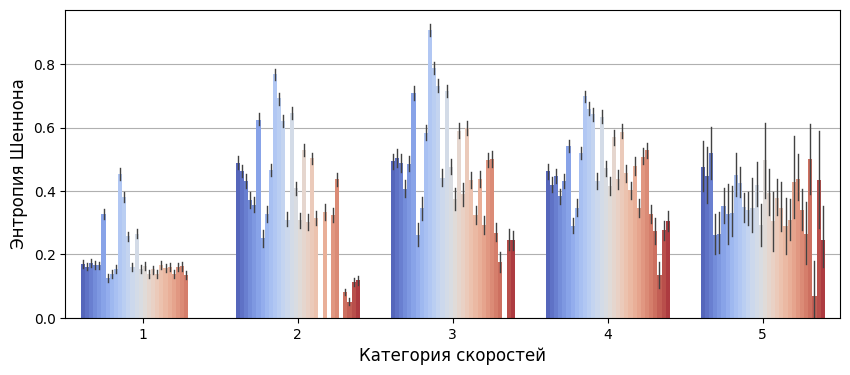

In [133]:
plt.figure(figsize=(10, 4))
ax = sns.barplot(data=entropy.rename('entropy').reset_index(), 
            x='rate_cat_ns', y='entropy', hue='clade', legend=False,
            palette='coolwarm', err_kws={'linewidth':1}
)
# plt.title('Shannon Entropy of AA mutations distribution per site for clades')
plt.ylabel('Энтропия Шеннона', fontsize=12)
plt.xlabel('Категория скоростей', fontsize=12)
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

In [119]:
for c in range(1, 6):
    print('rate_cat', c)
    print(cat_obs_mut_freqs.loc[c].sort_values(ascending=False).head(10))
    print()

rate_cat 1
MutAA
F>L    1475.0
I>M    1042.0
D>E     985.0
N>K     949.0
V>A     947.0
L>F     916.0
K>N     866.0
L>V     769.0
L>S     718.0
L>P     592.0
Name: 1, dtype: float64

rate_cat 2
MutAA
V>A    10515.0
T>A     9437.0
F>L     8527.0
D>E     6465.0
K>R     6306.0
E>D     5810.0
K>E     5168.0
K>N     5018.0
N>K     4837.0
N>D     4493.0
Name: 2, dtype: float64

rate_cat 3
MutAA
I>V    24067.0
V>I    18389.0
N>S    16993.0
K>R    16849.0
T>A    15925.0
A>T    13491.0
I>T    13422.0
F>L    11796.0
E>G    11747.0
D>G    11245.0
Name: 3, dtype: float64

rate_cat 4
MutAA
T>I    231464.0
A>V    171438.0
L>F    117184.0
P>S    106918.0
P>L     72998.0
A>S     64104.0
S>F     59877.0
V>F     53291.0
V>I     52632.0
H>Y     50011.0
Name: 4, dtype: float64

rate_cat 5
MutAA
T>I    107777.0
A>V     58422.0
L>F     42398.0
P>L     35079.0
H>Y     30637.0
S>F     29971.0
S>L     29378.0
P>S     23603.0
K>R     18250.0
R>C     12112.0
Name: 5, dtype: float64



<Axes: xlabel='rate_cat_ns', ylabel='rate_cat_ns'>

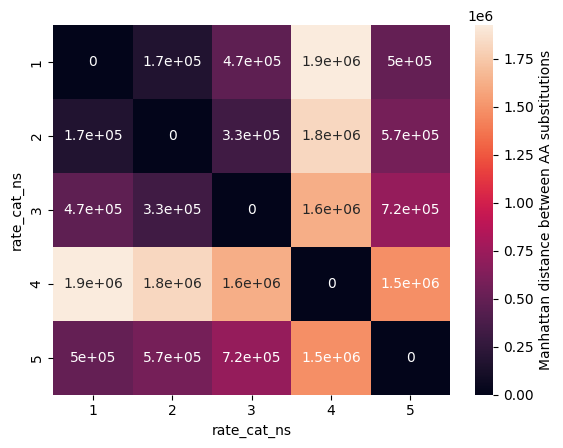

In [122]:
_ = pd.DataFrame(squareform(pdist(cat_obs_mut_freqs, 'cityblock')), 
                 index=cat_obs_mut_freqs.index, columns=cat_obs_mut_freqs.index)
sns.heatmap(_, annot=True, cbar_kws={'label': 'Manhattan distance between AA substitutions'})

In [137]:
cat_obs_mut_freqs.sum().describe()

count       170.000000
mean      18678.582353
std       39811.901672
min          13.000000
25%        1698.500000
50%        5304.000000
75%       16525.500000
max      348170.000000
dtype: float64

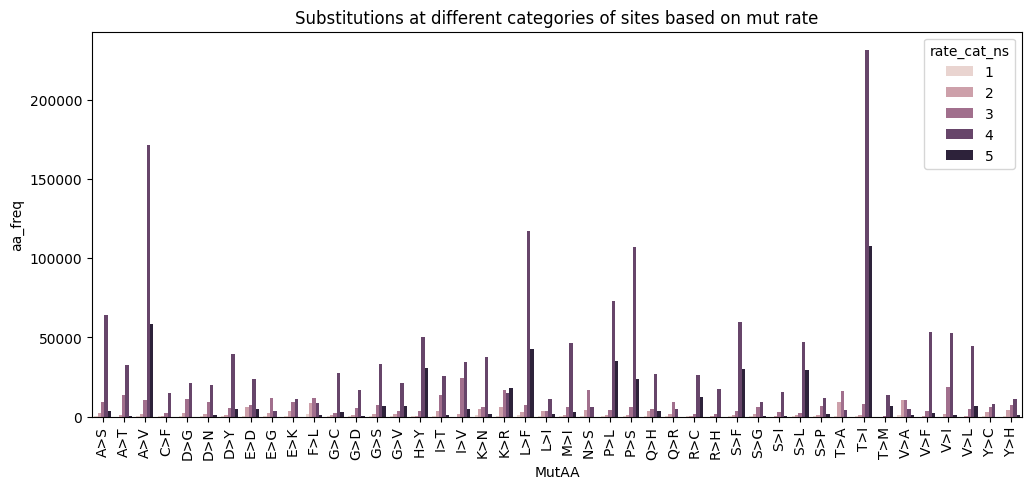

In [143]:
plt.figure(figsize=(12, 5))
_ = cat_obs_mut_freqs.loc[:, cat_obs_mut_freqs.sum() > 16000]\
    .melt(ignore_index=False, value_name='aa_freq').reset_index()
sns.barplot(_, hue='rate_cat_ns', y='aa_freq', x='MutAA')
plt.xticks(rotation=90)
plt.title('Substitutions at different categories of sites based on mut rate');

#### compare rate categories with "landscape" categories

In [33]:
# compare with landscapes
df_land = pd.read_csv('./data/sites_landscape_labels.csv')
df_land

gene  aa_site     min      max      mean   median       std  count  \
0         E        1 -7.1032 -3.15600 -4.558900 -4.20155  1.412269      6   
1         E        2 -5.1893 -2.27390 -3.369967 -3.16075  0.991358      6   
2         E        3 -2.4956 -0.76330 -1.350945 -1.07244  0.782417      4   
3         E        4 -3.1612 -0.36699 -2.383348 -2.82070  1.099300      6   
4         E        5 -3.5840  0.72401 -1.498047 -2.14025  1.698920      6   
...     ...      ...     ...      ...       ...      ...       ...    ...   
16759  nsp9      109 -5.1893  1.11350 -2.792800 -3.35530  2.174497      6   
16760  nsp9      110 -5.1071 -1.46820 -2.825300 -2.48540  1.395265      5   
16761  nsp9      111 -7.2405 -1.89070 -4.397983 -4.42670  1.752579      6   
16762  nsp9      112 -5.0843 -0.80668 -2.522769 -2.44460  1.528106      7   
16763  nsp9      113 -5.1893 -0.81593 -2.809438 -2.64880  1.468441      6   

       max=0 ref_aa  subset_of_ORF1ab      landscape_char  
0       True      M             False      ref_is_highest  
1       True      Y             False      ref_is_highest  
2       True      S             False      ref_is_highest  
3       True      F             False      ref_is_highest  
4      False      V             False  ref_is_not_highest  
...      ...    ...               ...                 ...  
16759  False      T              True  ref_is_not_highest  
16760   True      V              True      ref_is_highest  
16761   True      R              True      ref_is_highest  
16762   True      L              True      ref_is_highest  
16763   True      Q              True      ref_is_highest  

[16764 rows x 12 columns]

In [34]:
# sites that have no mutations have no aa_site in obs and therefore in ref_sites_df
# we must assign manually aa_site for invariant sites:

def get_site_aa(ser):
    # 13468
    nt_site = ser['Pos']
    gene_site = ser['PosInGene']
    gene = ser['gene']

    if gene != 'ORF1ab':
        return (gene_site - 1) // 3 + 1

    if nt_site <= 13468:
        return (gene_site - 1) // 3 + 1
    elif 13468 < nt_site < 13483:
        return np.nan
    else: 
        return gene_site // 3 + 1

ref_sites_df['aa_site_my'] = ref_sites_df.apply(get_site_aa, axis=1)
ref_sites_df.query('aa_site != aa_site_my & aa_site.notnull()')

Pos Nuc Context  Strand       Type    gene  PosInGene  PosInCodon  \
13215  13481   T     GTA       1  stem_loop  ORF1ab      13216           1   

      Codon  MutCountTotal  MutCountNonsyn  nt_site codon_position  aa_site  \
13215   TAA            6.0             6.0  13481.0              2   4406.0   

      AA  rate_cat  rate_cat_ns  aa_site_my  
13215  *         1            1         NaN

In [43]:
ref_sites_df['aa_site_from_obs'] = ref_sites_df['aa_site']
ref_sites_df['aa_site'] = ref_sites_df['aa_site_my']

In [44]:
big_label = ref_sites_df.merge(df_land[['gene', 'aa_site', 'landscape_char']])
big_label.query('gene == "S"')

Pos Nuc Context  Strand Type gene  PosInGene  PosInCodon Codon  \
21066  21563   A     AAT       1  CDS    S          1           1   ATG   
21067  21564   T     ATG       1  CDS    S          2           2   ATG   
21068  21565   G     TGT       1  CDS    S          3           3   ATG   
21069  21566   T     GTT       1  CDS    S          4           1   TTT   
21070  21567   T     TTT       1  CDS    S          5           2   TTT   
...      ...  ..     ...     ...  ...  ...        ...         ...   ...   
24835  25374   A     CAT       1  CDS    S       3812           2   CAT   
24836  25375   T     ATT       1  CDS    S       3813           3   CAT   
24837  25376   T     TTA       1  CDS    S       3814           1   TAC   
24838  25377   A     TAC       1  CDS    S       3815           2   TAC   
24839  25378   C     ACA       1  CDS    S       3816           3   TAC   

       MutCountTotal  MutCountNonsyn  nt_site codon_position  aa_site   AA  \
21066            0.0             0.0      NaN            NaN      1.0  Met   
21067            0.0             0.0      NaN            NaN      1.0  Met   
21068            2.0             2.0  21565.0              3      1.0  Met   
21069           54.0            54.0  21566.0              1      2.0  Phe   
21070           21.0            21.0  21567.0              2      2.0  Phe   
...              ...             ...      ...            ...      ...  ...   
24835            8.0             8.0  25374.0              2   1271.0  His   
24836           75.0             0.0      NaN            NaN   1271.0  His   
24837           50.0            50.0  25376.0              1   1272.0  Tyr   
24838            6.0             6.0  25377.0              2   1272.0  Tyr   
24839          490.0            17.0  25378.0              3   1272.0  Tyr   

       rate_cat  rate_cat_ns  aa_site_my  aa_site_from_obs      landscape_char  
21066         0            0         1.0               NaN      ref_is_highest  
21067         0            0         1.0               NaN      ref_is_highest  
21068         1            1         1.0               1.0      ref_is_highest  
21069         2            3         2.0               2.0  ref_is_not_highest  
21070         1            2         2.0               2.0  ref_is_not_highest  
...         ...          ...         ...               ...                 ...  
24835         1            1      1271.0            1271.0      ref_is_highest  
24836         2            0      1271.0               NaN      ref_is_highest  
24837         2            2      1272.0            1272.0      ref_is_highest  
24838         1            1      1272.0            1272.0      ref_is_highest  
24839         4            2      1272.0            1272.0      ref_is_highest  

[3774 rows x 20 columns]

In [48]:
big_label.gene.value_counts()

gene
ORF1ab    21066
S          3774
N          1242
ORF3a       825
M           663
ORF7a       359
ORF8        357
E           225
ORF6        183
ORF7b       123
ORF10       111
Name: count, dtype: int64

In [45]:
big_label.groupby('landscape_char').rate_cat_ns.value_counts().unstack()

rate_cat_ns              0       1       2       3       4      5
landscape_char                                                   
ref_is_highest      4071.0  5190.0  3906.0  2108.0  1342.0    NaN
ref_is_not_highest  1891.0  1184.0  2676.0  3175.0  3153.0  232.0

In [47]:
big_label.groupby('landscape_char').rate_cat_ns.value_counts().unstack().sum().sum()

np.float64(28928.0)

### Fitting observed substitution spectra by site-specific rates

In [70]:
ref_sites_df.query('rate_cat == 1').head()

Pos Nuc Context  Strand         Type    gene  PosInGene  PosInCodon  \
1    267   T     ATG       1  mat_peptide  ORF1ab          2           2   
2    268   G     TGG       1  mat_peptide  ORF1ab          3           3   
129  395   C     TCA       1  mat_peptide  ORF1ab        130           1   
157  423   T     TTA       1  mat_peptide  ORF1ab        158           2   
265  531   T     GTA       1  mat_peptide  ORF1ab        266           2   

    Codon  MutCountTotal  MutCountNonsyn  nt_site codon_position  aa_site  \
1     ATG            2.0             2.0    267.0            2;2      1.0   
2     ATG            1.0             1.0    268.0            3;3      1.0   
129   CAA           26.0            25.0    395.0            1;1     44.0   
157   TTA           12.0            12.0    423.0            2;2     53.0   
265   GTA           13.0            13.0    531.0            2;2     89.0   

      AA  rate_cat  rate_cat_ns  
1    Met         1            1  
2    Met         1            1  
129  Gln         1            2  
157  Leu         1            2  
265  Val         1            2

In [25]:
# cur_rate_cat = 'rate_cat'    # rate cats based on all mutations
cur_rate_cat = 'rate_cat_ns' # rate cats based on nonsynonymous mutations
mut_cnt_col = 'MutCountNonsyn' if cur_rate_cat == 'rate_cat_ns' else 'MutCountTotal'
print(cur_rate_cat)

# check 3 different approaches to get amino acid counts for normalization
def get_site_specific_aa_counts(df, site_cat):
    aa_counts = df.query(f'AA != "*" & {cur_rate_cat} == @site_cat').AA.value_counts().to_dict()
    return aa_counts

def get_uniform_aa_counts():
    return {x: 1 for x in amino_acid_codes.values()}
    
def get_original_aa_counts(df_obs):
    _orig_aa_cnt = df_obs.query('aa1 != "*"').groupby('aa1')['count'].sum()\
        .rename(index=amino_acid_codes).to_dict()
    return _orig_aa_cnt


metrics_total = []
d_to_eq_data = []
for clade in tqdm.tqdm(clades_spectra.clade.unique(), desc='Clades'):
    spectrum_clade = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_clade['rate'] /= spectrum_clade['rate'].sum()

    exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    obs_clade = obs[obs['clade'] == clade]

    cur_ref_sites_df = ref_sites_df_clades.query('clade == @clade').copy()
    cur_ref_sites_df['Pos'] = cur_ref_sites_df['nt_site']
    categories, rates, alpha = categorize_site_rates_robust_plus_invariant(
        cur_ref_sites_df[mut_cnt_col], 6, 99, plot=False, verbose=False)
    cur_ref_sites_df[cur_rate_cat] = categories

    for i, rcat in enumerate(cur_ref_sites_df[cur_rate_cat].unique()):
        cur_sites = cur_ref_sites_df.query(f'{cur_rate_cat} == @rcat').Pos.tolist()
        df_obs = obs_clade[obs_clade.nt_site.isin(cur_sites)]
        
        cur_aa_freqs_dct = get_site_specific_aa_counts(cur_ref_sites_df, rcat)
        # cur_aa_freqs_dct = get_original_aa_counts(df_obs)
        
        # Distance to equilibrium estimation
        _, cur_aa_freq = get_equilibrium_freqs(spectrum_clade, 'rate')
        cur_aa_freq['obs_cnt'] = cur_aa_freq['aa'].map(cur_aa_freqs_dct).fillna(0)
        cur_aa_freq['obs_freq'] = cur_aa_freq['obs_cnt'] / cur_aa_freq['obs_cnt'].sum()

        dm = cityblock(cur_aa_freq['eq_freq'], cur_aa_freq['obs_freq'])
        de = euclidean(cur_aa_freq['eq_freq'], cur_aa_freq['obs_freq'])

        d_to_eq_data.append({
            'clade': clade,
            'rcat': rcat,
            'cityblock': dm, 
            'euclidean': de, 
        })

        if len(df_obs) == 0:
            continue

        aa_subst = prepare_aa_subst(df_obs, exp_aa_subst, cur_aa_freqs_dct)
        
        cur_metrics = calc_metrics(aa_subst)
        cur_metrics['nt_sites'] = df_obs.nt_site.nunique()
        cur_metrics['clade'] = clade
        cur_metrics['rate_cat'] = rcat
        metrics_total.append(cur_metrics)

    # for total sites set
    aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
    # aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, get_uniform_aa_counts())
    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['nt_sites'] = obs_clade.nt_site.nunique()
    cur_metrics['clade'] = clade
    cur_metrics['rate_cat'] = 'total'
    metrics_total.append(cur_metrics)

metrics_total_df = pd.DataFrame(metrics_total).set_index(['clade', 'rate_cat', 'nt_sites'])\
        .drop(['mape','wape','slope','intercept', 'ks_stat','ks_p','rmse','log_likelihood'], axis=1)
metrics_total_df.to_csv(f'data/fit_metrics_site_{cur_rate_cat}5.csv', float_format='%g')

d_to_eq_df = pd.DataFrame(d_to_eq_data)
d_to_eq_df['time_period'] = d_to_eq_df['clade'].map(_clade2label)
d_to_eq_df.to_csv(f'data/dist_to_eq_site_{cur_rate_cat}5.csv', float_format='%g', index=False)

rate_cat_ns


Clades: 100%|██████████| 24/24 [00:09<00:00,  2.62it/s]


In [139]:
d_to_eq_df

clade  rcat  cityblock  euclidean              time_period
0     20A     2   1.007015   0.343604             Early clades
1     20A     1   0.937356   0.316556             Early clades
2     20A     3   1.062285   0.356621             Early clades
3     20A     0   0.854268   0.317141             Early clades
4     20A     4   1.140377   0.381092             Early clades
..    ...   ...        ...        ...                      ...
138   24A     3   0.943343   0.290138  Late clades\n(Omicron+)
139   24A     2   0.901879   0.274211  Late clades\n(Omicron+)
140   24A     1   0.794209   0.248344  Late clades\n(Omicron+)
141   24A     0   0.709699   0.240803  Late clades\n(Omicron+)
142   24A     5   1.259091   0.404350  Late clades\n(Omicron+)

[143 rows x 5 columns]

In [26]:
metrics_total_df['time_period'] = metrics_total_df.index.get_level_values(0).map(_clade2label).map(_clade2label_ru)
metrics_total_df

r2  spearman_corr    spearman_p  pearson_corr  \
clade rate_cat nt_sites                                                        
20A   2        3569     -1.031232       0.649989  2.264510e-19      0.458869   
      1        4397     -1.654785       0.545259  5.413694e-13      0.341841   
      3        1807     -0.128910       0.717030  5.756521e-25      0.636439   
      4        2186      0.501483       0.709262  3.086392e-24      0.734471   
      5        124      -0.015122       0.472855  9.964670e-10      0.260552   
...                           ...            ...           ...           ...   
24A   3        1952     -0.439473       0.680685  9.507916e-22      0.579389   
      2        3502     -1.241423       0.615445  5.282154e-17      0.421665   
      1        3861     -1.716399       0.568990  3.041527e-14      0.314805   
      5        118      -0.020677       0.340292  2.037771e-05      0.199897   
      total    11685     0.662479       0.758251  2.748880e-29      0.823546   

                         pearson_corr_squared     pearson_p  mut_count  \
clade rate_cat nt_sites                                                  
20A   2        3569                  0.210561  3.513306e-09     8357.0   
      1        4397                  0.116855  1.857590e-05     4328.0   
      3        1807                  0.405055  2.086719e-18     8534.0   
      4        2186                  0.539448  1.072170e-26    35219.0   
      5        124                   0.067887  1.280969e-03     7993.0   
...                                       ...           ...        ...   
24A   3        1952                  0.335692  7.996510e-15     9348.0   
      2        3502                  0.177801  7.707210e-08     8334.0   
      1        3861                  0.099102  8.725748e-05     3824.0   
      5        118                   0.039959  1.418440e-02     9409.0   
      total    11685                 0.678228  2.868359e-38    64920.0   

                         mut_type_count  corr_chem_vs_rel_freq  \
clade rate_cat nt_sites                                          
20A   2        3569                 146              -0.106061   
      1        4397                 143              -0.127354   
      3        1807                 143              -0.050509   
      4        2186                 140              -0.062426   
      5        124                   91              -0.179518   
...                                 ...                    ...   
24A   3        1952                 146              -0.082447   
      2        3502                 144              -0.117092   
      1        3861                 139              -0.097933   
      5        118                   71              -0.150848   
      total    11685                150              -0.215114   

                         corr_chem_vs_rel_freq_pval                time_period  
clade rate_cat nt_sites                                                         
20A   2        3569                        0.196443               Ранние клады  
      1        4397                        0.120414               Ранние клады  
      3        1807                        0.539331               Ранние клады  
      4        2186                        0.447909               Ранние клады  
      5        124                         0.027939               Ранние клады  
...                                             ...                        ...  
24A   3        1952                        0.315846  Поздние клады\n(Омикрон+)  
      2        3502                        0.153580  Поздние клады\n(Омикрон+)  
      1        3861                        0.233156  Поздние клады\n(Омикрон+)  
      5        118                         0.065386  Поздние клады\n(Омикрон+)  
      total    11685                       0.008203  Поздние клады\n(Омикрон+)  

[143 rows x 11 columns]

/tmp/ipykernel_133765/1455901043.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _['rate_cat'] = _['rate_cat'].replace('total', 6)


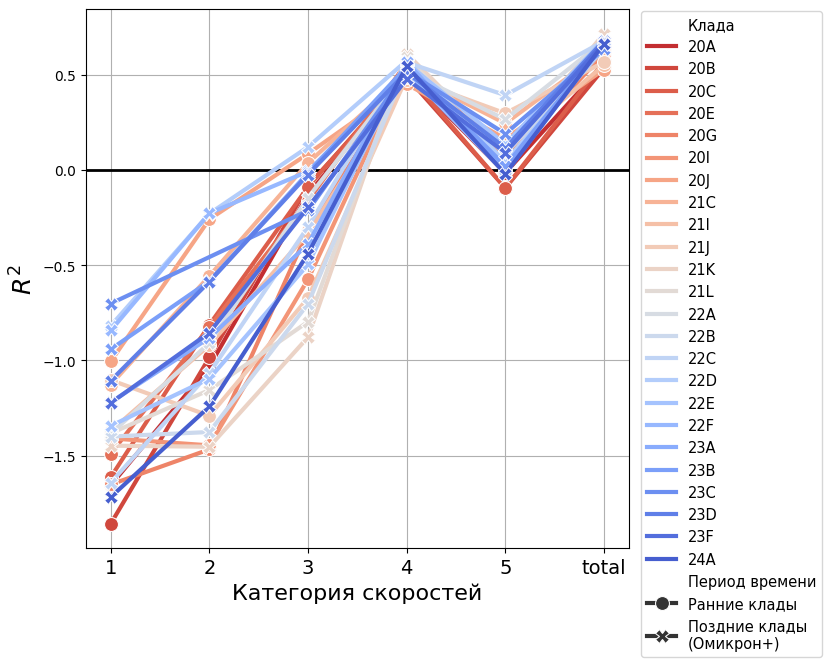

In [ ]:
_ = metrics_total_df.reset_index()
_['rate_cat'] = _['rate_cat'].replace('total', 6) 
_['Клада'] = _['clade']
_['Период времени'] = _['time_period']

plt.figure(figsize=(7, 7))
ax = sns.lineplot(
    _, x='rate_cat', y='r2', hue='Клада', style='Период времени', 
    markers=True, dashes=False, palette='coolwarm_r', 
    linewidth=3, markersize=10,
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
ax.set_xticks(range(1, 7), ['1', '2', '3', '4', '5', 'total'])
ax.set_ylabel('$R^2$', fontsize=18)
ax.set_xlabel('Категория скоростей', fontsize=16)
bou = ax.get_xbound()
ax.hlines(0, *bou, color='black', linestyle='-', linewidth=2, zorder=1)
ax.set_xbound(bou)

plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left', fontsize=10.5)
plt.xticks(fontsize=14)
plt.show()

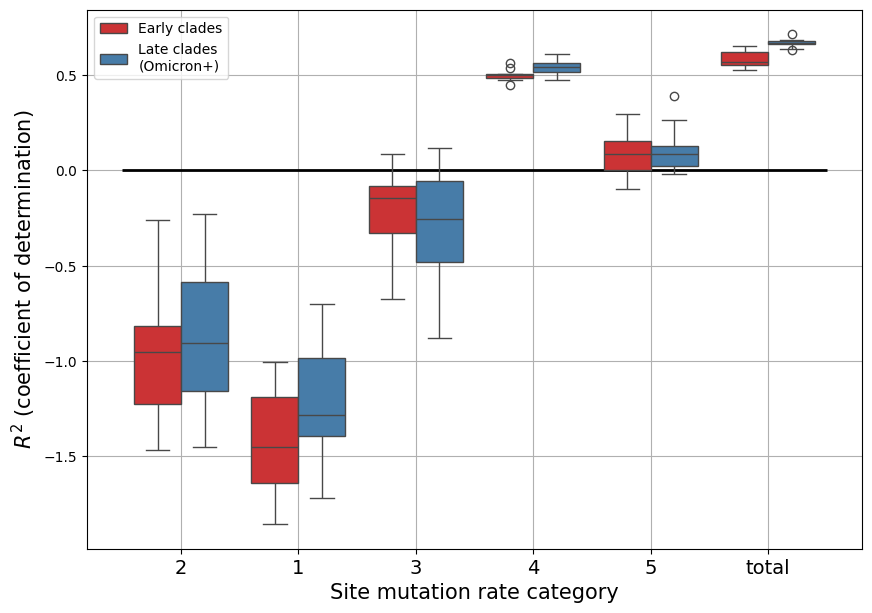

In [109]:
plt.figure(figsize=(10, 7))
ax = sns.boxplot(
    metrics_total_df, x='rate_cat', y='r2', hue='time_period', 
    palette='Set1', 
    # linewidth=1,
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
ax.set_ylabel('$R^2$ (coefficient of determination)', fontsize=15)
ax.set_xlabel('Site mutation rate category', fontsize=15)
bou = ax.get_xbound()
ax.hlines(0, *bou, color='black', linestyle='-', linewidth=2, zorder=1)

plt.legend(loc='upper left')
plt.xticks(fontsize=14)
plt.show()

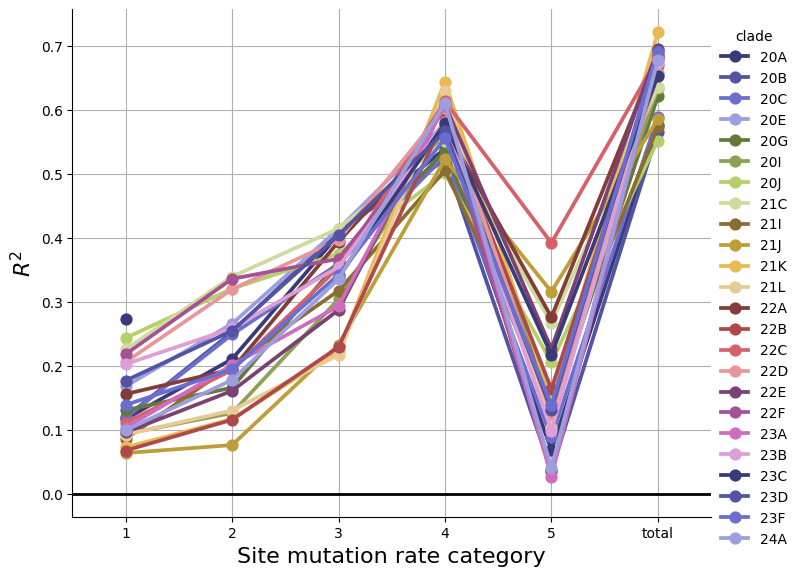

In [ ]:
_ = metrics_total_df.reset_index().melt(
    ['clade', 'rate_cat'], ['pearson_corr_squared', ])

g = sns.catplot(
    data=_, y='value', col='variable', x='rate_cat', hue='clade',
    kind='point', height=6, aspect=1.2, sharey=False, palette='tab20b',
    order=list(range(1,6))+['total'],
)
for ax in g.axes.flat:
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_title('')
    ax.set_ylabel('$R^2$', fontsize=16)
    ax.set_xlabel('Site mutation rate category', fontsize=16)
    bou = ax.get_xbound()
    ax.hlines(0, *bou, color='black', linestyle='-', linewidth=2, zorder=1)
    ax.set_xlim(bou)

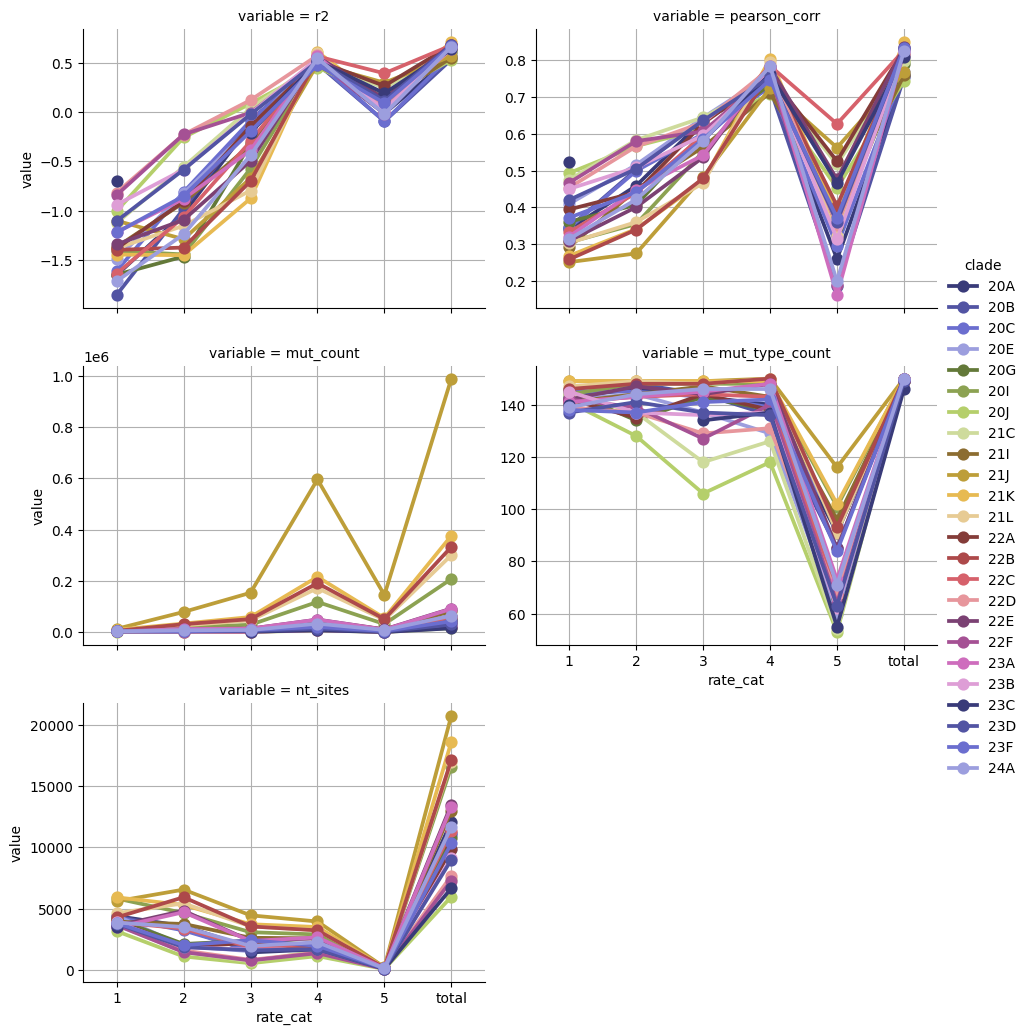

In [84]:
_ = metrics_total_df.reset_index().melt(
    ['clade', 'rate_cat'], ['r2', 'pearson_corr', 'mut_count', 'mut_type_count','nt_sites'])

g = sns.catplot(
    data=_, y='value', col='variable', x='rate_cat', hue='clade',
    col_wrap=2, kind='point', height=4, aspect=1.2, sharey=False, palette='tab20b',
    order=list(range(1,6))+['total'],
)
for ax in g.axes.flat:
    ax.grid()
    ax.set_axisbelow(True)

# g.axes_dict['mut_count'].set_ylim(0, 200000)

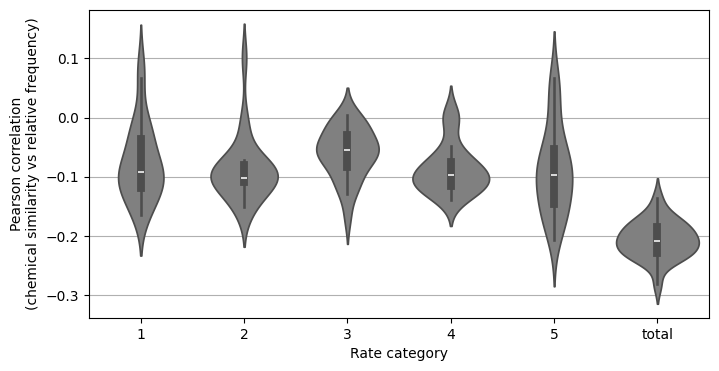

In [86]:
plt.figure(figsize=(8, 4))
ax=sns.violinplot(
    data=metrics_total_df.reset_index(), 
    x='rate_cat', y='corr_chem_vs_rel_freq', color='gray',
    order=[1,2,3,4,5,'total'])
plt.ylabel('Pearson correlation\n(chemical similarity vs relative frequency)',)
plt.xlabel('Rate category')
ax.set_axisbelow(True)
plt.grid(True, axis='y')

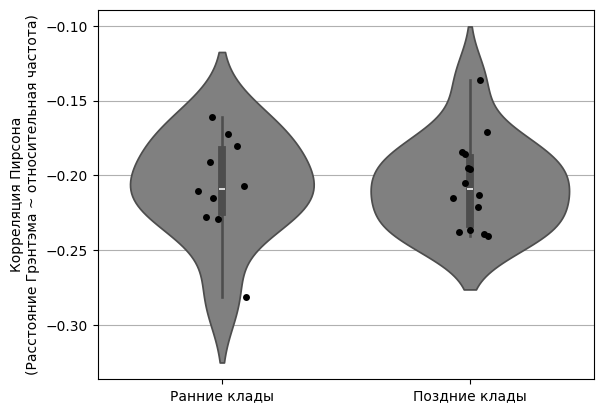

In [47]:
# plt.figure(figsize=(4, 4))
ax=sns.violinplot(
    data=metrics_total_df.reset_index().query('rate_cat == "total"'), 
    x='time_period', y='corr_chem_vs_rel_freq', color='gray',
)
ax=sns.stripplot(
    data=metrics_total_df.reset_index().query('rate_cat == "total"'), 
    x='time_period', y='corr_chem_vs_rel_freq', color='k',
)
plt.xlabel('')
plt.xticks([0, 1], ['Ранние клады', 'Поздние клады'])
plt.ylabel('Корреляция Пирсона\n(Расстояние Грэнтэма ~ относительная частота)',)
plt.grid(True, axis='y')
ax.set_axisbelow(True)

/tmp/ipykernel_38126/1378842234.py:2: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:gray'` for the same effect.

  ax=sns.violinplot(


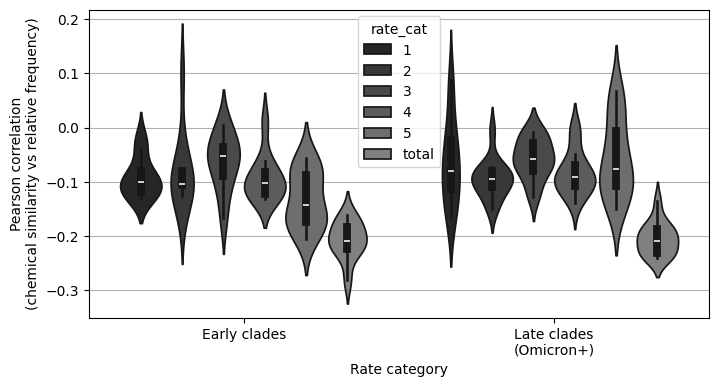

In [ ]:
# no difference between early and late clades
plt.figure(figsize=(8, 4))
ax=sns.violinplot(
    data=metrics_total_df.reset_index(), 
    hue='rate_cat', y='corr_chem_vs_rel_freq', x='time_period',
    color='gray', hue_order=[1,2,3,4,5,'total'])
plt.ylabel('Pearson correlation\n(chemical similarity vs relative frequency)',)
plt.xlabel('Rate category')
ax.set_axisbelow(True)
plt.grid(True, axis='y')

In [ ]:
metrics_total_df.query('corr_chem_vs_rel_freq_pval < 0.05').reset_index().rate_cat.value_counts()

rate_cat
total    23
5         4
2         1
3         1
1         1
Name: count, dtype: int64

### Distance to equilibrium VIZ

In [148]:
d_to_eq_df

clade  rcat  cityblock  euclidean              time_period
0     20A     2   1.007015   0.343604             Early clades
1     20A     1   0.937356   0.316556             Early clades
2     20A     3   1.062285   0.356621             Early clades
3     20A     0   0.854268   0.317141             Early clades
4     20A     4   1.140377   0.381092             Early clades
..    ...   ...        ...        ...                      ...
138   24A     3   0.943343   0.290138  Late clades\n(Omicron+)
139   24A     2   0.901879   0.274211  Late clades\n(Omicron+)
140   24A     1   0.794209   0.248344  Late clades\n(Omicron+)
141   24A     0   0.709699   0.240803  Late clades\n(Omicron+)
142   24A     5   1.259091   0.404350  Late clades\n(Omicron+)

[143 rows x 5 columns]

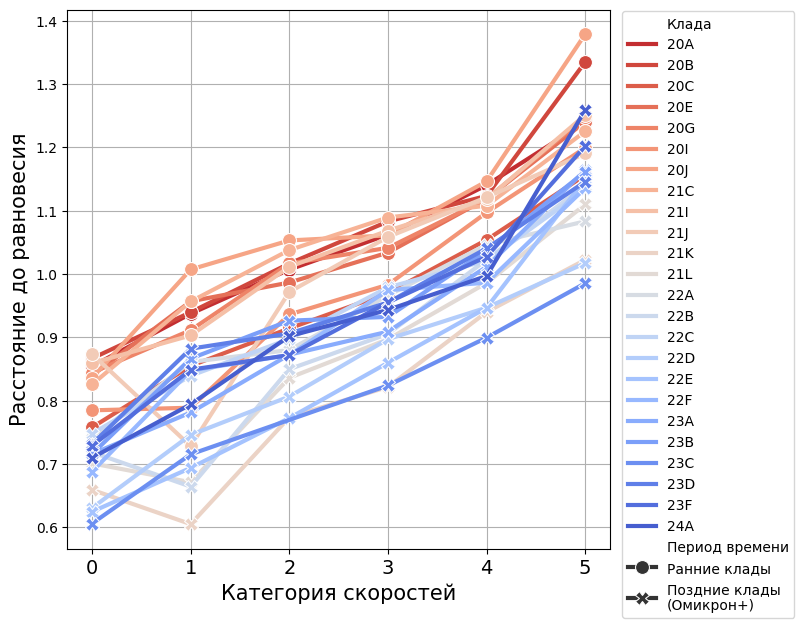

In [154]:
plt.figure(figsize=(7, 7))
_ = d_to_eq_df.copy()
_['Клада'] = _['clade']
_['Период времени'] = _['time_period'].map(_clade2label_ru)
ax = sns.lineplot(
    _, x='rcat', y='cityblock', hue='Клада', style='Период времени', 
    markers=True, dashes=False, palette='coolwarm_r', 
    linewidth=3, markersize=10, 
)

ax.grid()
ax.set_axisbelow(True)
ax.set_title('')
ax.set_xticks(range(6))
ax.set_ylabel('Расстояние до равновесия', fontsize=15)
ax.set_xlabel('Категория скоростей', fontsize=15)

plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left')
# plt.grid(axis='y', alpha=0.7)
plt.xticks(fontsize=14)
plt.show()

### Calculate aa content of most variable and constant sites

In [88]:
# add indexes to amino acids
naa = ref_sites_df.query('AA != "*"').shape[0] // 3
aa_indexes = np.repeat(np.arange(naa), 3)+1
ref_sites_df['aa_index'] = -1
ref_sites_df.loc[(ref_sites_df['AA'] != "*"), 'aa_index'] = aa_indexes

In [89]:
ref_sites_df.tail(3100).head(10)

Pos Nuc Context  Strand Type gene  PosInGene  PosInCodon Codon  \
26160  26465   T     CTG       1  CDS    E        221           2   CTG   
26161  26466   G     TGG       1  CDS    E        222           3   CTG   
26162  26467   G     GGT       1  CDS    E        223           1   GTC   
26163  26468   T     GTC       1  CDS    E        224           2   GTC   
26164  26469   C     TCT       1  CDS    E        225           3   GTC   
26165  26470   T     CTA       1  CDS    E        226           1   TAA   
26166  26471   A     TAA       1  CDS    E        227           2   TAA   
26167  26472   A     AAA       1  CDS    E        228           3   TAA   
26168  26523   A     CAT       1  CDS    M          1           1   ATG   
26169  26524   T     ATG       1  CDS    M          2           2   ATG   

       MutCountTotal  MutCountNonsyn  nt_site codon_position  rate_cat  \
26160           57.0            57.0  26465.0              2         2   
26161          161.0             0.0      NaN            NaN         3   
26162          929.0           929.0  26467.0              1         4   
26163           35.0            35.0  26468.0              2         2   
26164          370.0             0.0      NaN            NaN         4   
26165            2.0             0.0      NaN            NaN         1   
26166            8.0             0.0      NaN            NaN         1   
26167           11.0             0.0      NaN            NaN         1   
26168            6.0             6.0  26523.0              1         1   
26169            5.0             5.0  26524.0              2         1   

       rate_cat_ns   AA  aa_index  
26160            3  Leu      8546  
26161            0  Leu      8546  
26162            4  Val      8547  
26163            2  Val      8547  
26164            0  Val      8547  
26165            0    *        -1  
26166            0    *        -1  
26167            0    *        -1  
26168            1  Met      8548  
26169            1  Met      8548

In [90]:
aa_mutability = ref_sites_df.query('AA != "*"').groupby(['aa_index', 'AA'])['MutCountNonsyn'].sum()
aa_mutability = aa_mutability.sort_values()

n = 2000 # number of sites to consider as most variable or most constant
constant_sites_aa_content = aa_mutability.head(n).reset_index()['AA'].value_counts().to_dict()
variable_sites_aa_content = aa_mutability.tail(n).reset_index()['AA'].value_counts().to_dict()

In [91]:
_, cur_aa_freq = get_equilibrium_freqs(spectrum_20A, 'rate')
cur_aa_freq['var_sites'] = cur_aa_freq['aa'].map(variable_sites_aa_content)
cur_aa_freq['const_sites'] = cur_aa_freq['aa'].map(constant_sites_aa_content)
cur_aa_freq['var_freq'] = cur_aa_freq['var_sites'] / cur_aa_freq['var_sites'].sum()
cur_aa_freq['const_freq'] = cur_aa_freq['const_sites'] / cur_aa_freq['const_sites'].sum()
cur_aa_freq

aa   eq_freq  var_sites  const_sites  var_freq  const_freq
0   Phe  0.314637         16          159    0.0080      0.0795
1   Leu  0.197825        211          354    0.1055      0.1770
2   Ser  0.119281        180          130    0.0900      0.0650
3   Ile  0.086898         63           98    0.0315      0.0490
4   Tyr  0.073639         22          158    0.0110      0.0790
5   Val  0.044165        121          103    0.0605      0.0515
6   Cys  0.035283         38          121    0.0190      0.0605
7   Thr  0.025257        262           85    0.1310      0.0425
8   His  0.020183         76           52    0.0380      0.0260
9   Pro  0.017862        150           55    0.0750      0.0275
10  Asn  0.017199         25          105    0.0125      0.0525
11  Arg  0.009142         99           65    0.0495      0.0325
12  Asp  0.008012         84           54    0.0420      0.0270
13  Ala  0.007127        256           57    0.1280      0.0285
14  Met  0.006878         65           34    0.0325      0.0170
15  Gln  0.005073         79           83    0.0395      0.0415
16  Lys  0.004677         62           54    0.0310      0.0270
17  Gly  0.002844        114          144    0.0570      0.0720
18  Glu  0.002015         58           47    0.0290      0.0235
19  Trp  0.002004         19           42    0.0095      0.0210

In [92]:
cur_aa_freq.sort_values('eq_freq').tail().sum()

aa             TyrIleSerLeuPhe
eq_freq               0.792281
var_sites                  492
const_sites                899
var_freq                 0.246
const_freq              0.4495
dtype: object

In [93]:
d_var = cityblock(cur_aa_freq['eq_freq'], cur_aa_freq['var_freq'])
d_const = cityblock(cur_aa_freq['eq_freq'], cur_aa_freq['const_freq'])
print(d_var, d_const)

1.1345236738029898 0.696283075519111


## view the scatterplots with negative R2

In [ ]:
def plot_subst_freqs_linear(aa_subst, title=''):
    aa_subst = aa_subst.copy()

    y_true, y_pred = aa_subst['nobs_freqs'], aa_subst['nexp_freqs']
    cor_res = spearmanr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Spearman correlation: {cor_res.correlation:.3f} (p-value: {cor_res.pvalue:.3g})")

    plt.figure(figsize=(8, 8))
    ax = sns.regplot(aa_subst, color='blue', scatter_kws={'alpha':0.5, 's':50},
                y='nobs_freqs', x='nexp_freqs')

    _max = round(max(y_true), 2)
    plt.plot([0, _max], [0, _max], color='black', linestyle='--',)
    plt.ylabel('Observed AA substitution frequencies', fontsize=16)
    plt.xlabel('Predicted AA substitution frequencies', fontsize=16)
    plt.grid()
    # plt.ylabel('Наблюдаемые частоты замещений аминокислот', fontsize=14)
    # plt.xlabel('Ожидаемые частоты замещений аминокислот', fontsize=14)
    plt.title(title, fontsize=16)
    # plt.legend(title=f"spearmanr={cor_res.correlation:.2f} (p={cor_res.pvalue:.1g})", title_fontsize=14)
    plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)
    # plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
    plt.show()

In [19]:
aa_subst_total_df = pd.read_csv('data/aa_subst_total_rates.csv', index_col=0)
aa_subst_total_df

aa1  aa2  nobs  ref_aa1_freq  nobs_scaled  rate_exp       nexp  \
0      Ala  Asp    75      0.118787     34.71640  0.299600    43.8053   
1      Ala  Glu     6      0.118787      2.77731  0.299600    43.8053   
2      Ala  Gly     8      0.118787      3.70308  0.210660    30.8012   
3      Ala  Pro    13      0.118787      6.01751  0.457080    66.8309   
4      Ala  Ser  1119      0.118787    517.96800  9.487600  1387.2100   
...    ...  ...   ...           ...          ...       ...        ...   
32395  Val  Gly    45      0.078016     29.68430  0.173924    17.9375   
32396  Val  Ile   466      0.078016    307.39800  2.494230   257.2400   
32397  Val  Leu   258      0.078016    170.19000  2.614820   269.6770   
32398  Val  Met    32      0.078016     21.10890  0.831410    85.7465   
32399  Val  Phe   209      0.078016    137.86700  2.228000   229.7820   

            diff         pe  nobs_freqs  nexp_freqs clade branches  \
0       -9.08895   -26.1806    0.001049    0.001324   20A      all   
1      -41.02800 -1477.2600    0.000084    0.001324   20A      all   
2      -27.09810  -731.7720    0.000112    0.000931   20A      all   
3      -60.81340 -1010.6100    0.000182    0.002020   20A      all   
4     -869.23900  -167.8170    0.015655    0.041926   20A      all   
...          ...        ...         ...         ...   ...      ...   
32395   11.74690    39.5726    0.001486    0.000898   24A      all   
32396   50.15810    16.3170    0.015388    0.012877   24A      all   
32397  -99.48640   -58.4560    0.008520    0.013500   24A      all   
32398  -64.63770  -306.2110    0.001057    0.004292   24A      all   
32399  -91.91510   -66.6693    0.006902    0.011503   24A      all   

        sites_sample  sample_cutoff  
0      most variable             10  
1      most variable             10  
2      most variable             10  
3      most variable             10  
4      most variable             10  
...              ...            ...  
32395         random             30  
32396         random             30  
32397         random             30  
32398         random             30  
32399         random             30  

[32400 rows x 15 columns]

In [ ]:
i=0
for _, gr in aa_subst_total_df.groupby(['clade', 'branches', 'sites_sample', 'sample_cutoff']):
    cur_metrics = calc_metrics(gr)
    r2 = cur_metrics['r2']
    i+=1
    # if i > 5:
    #     break
    # if r2<-1.6:
        # gr['nexp_freqs'] = gr['nobs_freqs'].mean()
    if r2>.8:
        print(r2)
        break

0.8003752243601783


In [82]:
gr['nexp_freqs'] = gr['nobs_freqs'].mean()
r2_score(gr['nobs_freqs'], gr['nexp_freqs'])

0.0

In [83]:
gr['nexp_freqs'] = gr['nobs_freqs'].mean()
gr['nexp_freqs'] /= gr['nexp_freqs'].sum()
r2_score(gr['nobs_freqs'], gr['nexp_freqs'])

-2.220446049250313e-16

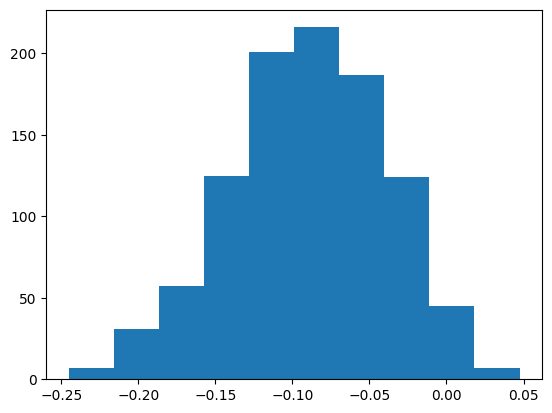

In [80]:
_d = []
for _ in range(1000):
    gr['nexp_freqs'] = np.random.random(len(gr))
    gr['nexp_freqs'] /= gr['nexp_freqs'].sum()
    r2 = r2_score(gr['nobs_freqs'], gr['nexp_freqs'])
    _d.append(r2)
plt.hist(_d);

/home/kpotoh/.pyenv/.venv_bio/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


-0.10662335407434731
Spearman correlation: -0.017 (p-value: 0.834)


/tmp/ipykernel_19245/544917984.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)


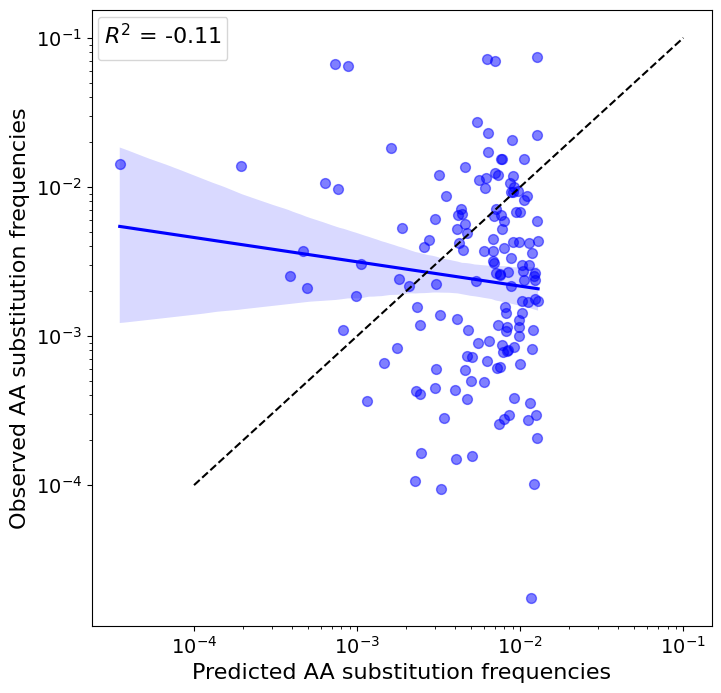

In [73]:
plot_subst_freqs(gr)

Spearman correlation: 0.811 (p-value: 2.45e-36)


/tmp/ipykernel_19245/3066355826.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=16)


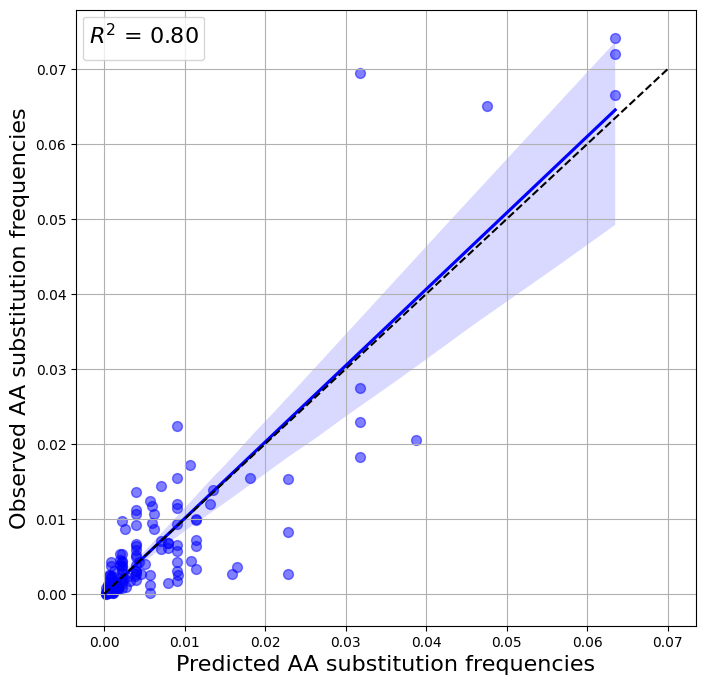

In [59]:
plot_subst_freqs_linear(gr)